In [1]:
import pandas as pd
import numpy as np
import gzip
import os
import datetime
import pandas as pd
import calendar
import numpy as np
import glob
import sys
import gc
import re
#import quantstats as qs
import time

import matplotlib.pyplot as plt

import nest_asyncio # install this package to avoid running in loop

import urllib
import pandas_ta as ta

import warnings

import requests

import hmac
import hashlib

import aiohttp
import asyncio

import logging
from datetime import timezone

import nest_asyncio

# Filter depreciation warnings from pandas regarding the append method
warnings.filterwarnings('ignore', category=FutureWarning, message=".*append.*")
pd.options.mode.chained_assignment = None

# Set pandas to display all digits for floating-point numbers
pd.options.display.float_format = '{:.8f}'.format

import os
from dotenv import load_dotenv

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Ignore only FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Ignore only RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

import importlib


from Orats_options_fetch_functions import *

from faster_numba_strategy_functions import *

import strategy_functions

importlib.reload(strategy_functions)
from strategy_functions import *

# import Common_functions

# importlib.reload(strategy_functions)
# importlib.reload(Common_functions)

# from Common_functions import *
# coin_desk_api_key =  "e43c1fd991e660b9bf959645f0800bb7e76fb4a3537ab773cec62b2fad31af2d"
from datetime import time
from pathlib import Path
# Get the user's home directory dynamically
home_dir = Path.home()
#====================================

strategy_name = "Straddle_0DTE"

# Create a folder for the strategy_name if it doesn't exist in home directory

strategy_folder = os.path.join(home_dir, strategy_name)
if not os.path.exists(strategy_folder):
    os.makedirs(strategy_folder)

# Create the full path to the output file. this file contains all the trades

output_all_trades_file = os.path.join(strategy_folder, f"All_trades_{strategy_name}.csv")
trade_html_file = os.path.join(strategy_folder, f"Trade_stats_{strategy_name}.html")

#=== location to store the trade dataframe for debug

base_folder_df = "strategy_dataframe"
df_folder = os.path.join(strategy_folder, base_folder_df)
if not os.path.exists(df_folder):
    os.makedirs(df_folder)
    print("\n Created strategy dataframe folder : " ,df_folder )

#----- symbol_wise_trades

trades_folder = "sym_wise_trades"
trades_strategy_folder = os.path.join(strategy_folder, trades_folder)

if not os.path.exists(trades_strategy_folder):
    print("\n Making folder for symbol wise trades of strategy" , trades_strategy_folder)
    os.makedirs(trades_strategy_folder)

logger = setup_logger("Straddle_0DTE", strategy_folder, log_file="strategy.log" , to_console=False)


In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to an in-memory database
con = duckdb.connect()

# --- Your setup code (which is correct) ---
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")
con.execute("""
SET s3_endpoint='122.176.133.73:9000';
SET s3_use_ssl=false;
SET s3_access_key_id='minioadmin';
SET s3_secret_access_key='minioadmin';
""")
con.execute("SET s3_url_style='path';") 
con.execute("PRAGMA threads=8;")
con.execute("PRAGMA enable_object_cache;")

# --- THE MISSING STEP: Querying a file from S3 ---
# Replace with your actual S3 bucket and file path
# This can be a .parquet, .csv, or .json file
s3_file_path = 's3://duckdata/ORATS/Options/**/*.parquet'

try:
    # Execute a query on the S3 file and fetch the result as a Pandas DataFrame
    print(f"Querying data from: {s3_file_path}")
    df = con.execute(f"""
        SELECT *
        FROM '{s3_file_path}'
        LIMIT 2;
    """).df()

    print("\n✅ Query successful! First 5 rows of data:")
    print(df.head())

except Exception as e:
    print(f"\n❌ An error occurred during the query: {e}")

# finally:
#     # It's good practice to close the connection
#     con.close()

Querying data from: s3://duckdata/ORATS/Options/**/*.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


✅ Query successful! First 5 rows of data:
      expiry       strike  dte  optionType                  ts         low  \
0 2024-01-26 421.00000000   25          -1 2024-01-02 17:13:00 17.18000000   
1 2024-01-12 414.00000000   11          -1 2024-01-02 17:13:00 10.41500000   

         high        open       close     volume  ...      askSize  \
0 17.18000000 17.18000000 17.18000000 0.00000000  ...  50.00000000   
1 10.41500000 10.41500000 10.41500000 0.00000000  ... 151.00000000   

     bidPrice    askPrice      bidIv      askIv         iv          oi  \
0 17.12000000 17.24000000 0.13785700 0.14511500 0.14148600 15.00000000   
1 10.34000000 10.49000000 0.14267100 0.15199600 0.14733300 54.00000000   

    stockPrice        day ticker  
0 404.00000000 2024-01-02    QQQ  
1 404.00000000 2024-01-02    QQQ  

[2 rows x 21 columns]


In [7]:
com_df2

,timestamp,SPY_close
0,2024-01-02 09:31:00,472.44000000
1,2024-01-02 09:32:00,472.63000000
2,2024-01-02 09:33:00,472.78000000
3,2024-01-02 09:34:00,472.68000000
4,2024-01-02 09:35:00,472.62000000
...,...,...
94266,2024-12-24 12:56:00,600.60000000
94267,2024-12-24 12:57:00,600.75000000
94268,2024-12-24 12:58:00,600.98000000
94269,2024-12-24 12:59:00,600.96000000


In [15]:


ifol = r"C:\Data\Aggregate_Data\Options\USA\Raw_SPY_1min_2024_2025_ORATS_close.parquet"
#== read the RELIANCE data

com_df2 = pd.read_parquet(ifol)

if 'timestamp' in com_df2.columns:
    com_df2['timestamp'] = pd.to_datetime(com_df2['timestamp'])
    com_df2.set_index('timestamp', inplace=True)

com_df2 = com_df2[~com_df2.index.duplicated(keep='first')]

com_df2.dropna(how='all', inplace=True)

vix_df = pd.read_parquet(r"C:\Data\Aggregate_Data\VIX_1_min_2019_2025.parquet")
com_df2 = com_df2.join(vix_df)


final_symbols = com_df2.filter(like='close').columns.str.replace('_close', '')
print("Total symbols found after all filtering: ", len(final_symbols))

# Calculate the number of rows in the DataFrame

com_df2[[f"{symbol}_intraday_low" for symbol in final_symbols]] =com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: intraday_low(com_df2, low_col=x.name,agg_func='min'))

com_df2[[f"{symbol}_intraday_high" for symbol in final_symbols]] =com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: intraday_high(com_df2, high_col=x.name,agg_func='max'))

com_df2[[f"{symbol}_todayo" for symbol in final_symbols]] = com_df2[[f'{symbol}_close' for symbol in final_symbols]].resample('D').transform('first')

# com_df2[[f"{symbol}_daily_ROC" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change(periods=50)

# com_df2[[f"{symbol}_ROC" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change()

# com_df2[[f"{symbol}_ROC_4" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change(periods=4)

com_df2[[f"{symbol}_prevdayl" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_low_numba(com_df2, n=1, column=x.name))

com_df2[[f"{symbol}_prevdayh" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=1, column=x.name))

com_df2[[f"{symbol}_secdayh" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=2, column=x.name))


# This single call does it for the 20-day MA
ma_20d_df = calculate_daily_ma_vectorized(df=com_df2, symbols=final_symbols, periods=3 , agg_func='last' , col_suffix='close')

    # Join the new features back to the main DataFrame
com_df2 = pd.concat([com_df2, ma_20d_df] , axis=1 , join='outer')


com_df2[[f"{symbol}_ma" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(2).mean()
com_df2[[f"{symbol}_high5" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(15).max()
com_df2[[f"{symbol}_low5" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(15).min()

com_df2[[f"{symbol}_ROC_15" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma" for symbol in final_symbols]].pct_change(periods=15)


#com_df2[[f"{symbol}_ma_3d_low" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma" for symbol in final_symbols]].values / com_df2[[f"{symbol}_3d_MA" for symbol in final_symbols]].values

com_df2[[f"{symbol}_prevdayc" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: calculate_prev_day_close(com_df2, close_col=x.name, n_days=1))

com_df2[[f"{symbol}_secdayc" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: calculate_prev_day_close(com_df2, close_col=x.name, n_days=2))


# #=== hourly volume
# com_df2[[f"{symbol}_vol_ma" for symbol in final_symbols]] = com_df2[[f"{symbol}_volume" for symbol in final_symbols]].rolling(4).mean()

# #==avg 3 day volume

# com_df2[[f"{symbol}_3d_vol_MA" for symbol in final_symbols]] = com_df2[[f"{symbol}_volume" for symbol in final_symbols]].apply(lambda x: daily_moving_average(com_df2, timeframe='1D', column=x.name, periods=3, agg_func='last'))

com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(5).mean()

com_df2[[f"{symbol}_3dlow" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]].apply(lambda x: get_x_day_low_numba(com_df2, n=3, column=x.name))

com_df2[[f"{symbol}_3dhigh" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=3, column=x.name))



# 1. Get the lists of column names
high_3d_cols = [f"{symbol}_3dhigh" for symbol in final_symbols]
low_3d_cols = [f"{symbol}_3dlow" for symbol in final_symbols]

# 2. Perform the calculation on NumPy arrays
range_values = (com_df2[high_3d_cols].values / com_df2[low_3d_cols].values) - 1

# 3. Create a new DataFrame from the results
# This is the key step to avoid the error.
range_cols = [f"{symbol}_3d_rng" for symbol in final_symbols]
range_df = pd.DataFrame(range_values, index=com_df2.index, columns=range_cols)

# 4. Join the new DataFrame back to the main one
com_df2 = com_df2.join(range_df)



# # Calculate highest high of last 4 bars
# com_df2[[f"{symbol}_high_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(10).max()

# # Calculate lowest low of last 4 bars
# com_df2[[f"{symbol}_low_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(10).min()

# # 1. Get the lists of column names
# high_cols = [f"{symbol}_high_4bar" for symbol in final_symbols]
# low_cols = [f"{symbol}_low_4bar" for symbol in final_symbols]

# # 2. Perform the calculation on the NumPy arrays
# range_values = com_df2[high_cols].values - com_df2[low_cols].values

# # 3. Create a new DataFrame from the result (This is the key step)
# range_cols = [f"{symbol}_range_4bar" for symbol in final_symbols]
# range_df = pd.DataFrame(range_values, index=com_df2.index, columns=range_cols)

# # 4. Join the new DataFrame back to the main one
# com_df2 = com_df2.join(range_df)


# # Calculate mean range (average of the 4-bar ranges)
# com_df2[[f"{symbol}_mean_range_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_range_4bar" for symbol in final_symbols]].rolling(12).mean()


# gc.collect()

# for symbol in final_symbols:

   
#     com_df2[f'{symbol}_iATR2'] = com_df2[f"{symbol}_ATR"].values / com_df2[f"{symbol}_close"].values


# 1. Define the column groups
close_cols = [f"{symbol}_close" for symbol in final_symbols]
low_3d_cols = [f"{symbol}_3dlow" for symbol in final_symbols]
high_3d_cols = [f"{symbol}_3dhigh" for symbol in final_symbols]

# 2. Perform the calculation in a more chained and memory-conscious way
# Using .to_numpy(dtype=np.float32) can cut memory usage by 50%
numerator = com_df2[close_cols].to_numpy(dtype=np.float32) - com_df2[low_3d_cols].to_numpy(dtype=np.float32)
denominator = com_df2[high_3d_cols].to_numpy(dtype=np.float32) - com_df2[low_3d_cols].to_numpy(dtype=np.float32)

# np.divide handles division by zero safely
percentile_values = np.divide(numerator, denominator, where=denominator != 0)

# 3. Create the new feature DataFrame
pctl_cols = [f"{symbol}_3d_Pctl" for symbol in final_symbols]
percentile_df = pd.DataFrame(percentile_values, index=com_df2.index, columns=pctl_cols)

# 4. Clip values and join back (same as your code)
percentile_df = percentile_df.clip(0, 1)
com_df2 = com_df2.join(percentile_df)

com_df2['decent'] = np.where((com_df2['SPY_todayo'] < com_df2['SPY_prevdayc'] * 1.01) & (com_df2['SPY_todayo'] > com_df2['SPY_prevdayc'] * 0.99), 1, 0)
com_df = com_df2[com_df2['decent']==1]
com_df = com_df[com_df.index.year>=2024]

Total symbols found after all filtering:  2
Calculating 3-day MA for 2 symbols...


In [14]:
final_symbols

Index(['SPY', 'VIX'], dtype='object')

In [4]:
def fetch_atm_options_for_dataframe(con, ticker, com_df, price_col='SPY_close'):
    """
    Efficiently fetches the closest ATM call and put for every row in a DataFrame.
    """
    print(f"🚀 Preparing to fetch ATM options for {len(com_df)} timestamps...")
    
    try:
        # --- DATA PREPARATION ---
        timestamps_to_query = com_df.reset_index()
        timestamps_to_query = timestamps_to_query[['index', price_col]]
        timestamps_to_query.rename(columns={'index': 'ts', price_col: 'ref_price'}, inplace=True)

        # --- THE FIX IS HERE: Add the missing timezone handling ---
        # 1. Check if the timestamp column is naive or aware
        if timestamps_to_query['ts'].dt.tz is None:
            # If naive, localize to NY first
            aware_timestamps = timestamps_to_query['ts'].dt.tz_localize('America/New_York')
        else:
            # If already aware, just use it
            aware_timestamps = timestamps_to_query['ts']
            
        # 2. Create the 'ts_utc' column needed for the fast JOIN
        timestamps_to_query['ts_utc'] = aware_timestamps.dt.tz_convert('UTC')
        
        # 3. Add other necessary columns for filtering
        timestamps_to_query['expiry_str'] = (aware_timestamps).dt.strftime('%Y-%m-%d')
        print(f"Timestamps are:{timestamps_to_query}")
        # --- Path generation (your existing code is correct) ---
        unique_days = timestamps_to_query['ts'].dt.strftime('%Y-%m-%d').unique()
        path_list = [f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'" for d in unique_days]
        paths_str = ", ".join(path_list)
        
        con.register('timestamps_to_query', timestamps_to_query)

        # (Your query follows, it will now work because 'ts_utc' exists)
        query = f"""
            WITH JoinedData AS (
                SELECT 
                    t.ts AS target_ts,
                    t.ref_price,
                    o.ts AS option_ts, -- The actual timestamp from the options file
                    o.strike,
                    o.expiry,
                    o.dte,
                    o.optionType,
                    o.bidPrice,
                    o.askPrice,
                    o.iv,
                    o.stockPrice,
                    o.ticker
                FROM timestamps_to_query AS t
                JOIN read_parquet([{paths_str}]) AS o
                  ON t.ts_utc = o.ts -- This JOIN condition will now succeed
                WHERE 
                    o.dte = 1 AND
                    o.expiry = t.expiry_str AND
                    o.optionType = 1 AND o.strike = ROUND(o.stockPrice)
            )
            SELECT *
            FROM JoinedData
            QUALIFY ROW_NUMBER() OVER (
                PARTITION BY target_ts, optionType
                
            ) = 1;
        """
        
        print("   Executing batched query...")
        atm_options = con.execute(query).df()
        
        return atm_options

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

In [ ]:
import pandas as pd

def fetch_atm_options_for_dataframe(con, ticker, com_df):
    """
    Efficiently fetches the exact ATM call and put (where strike matches the
    rounded stock price) for every row in a DataFrame.
    """
    print(f"🚀 Preparing to fetch ATM options for {len(com_df)} timestamps...")
    
    try:
        # --- SIMPLIFIED DATA PREPARATION ---
        # 1. Reset the index to get the timestamp column
        timestamps_to_query = com_df.reset_index()
        
        # 2. Select ONLY the timestamp column. price_col is no longer needed.
        timestamps_to_query = timestamps_to_query[['index']]
        timestamps_to_query.rename(columns={'index': 'ts'}, inplace=True)

        # 3. Handle timezones and create necessary columns
        if timestamps_to_query['ts'].dt.tz is None:
            aware_timestamps = timestamps_to_query['ts'].dt.tz_localize('America/New_York')
        else:
            aware_timestamps = timestamps_to_query['ts']
        print(f"aware timtsamps are :{aware_timestamps}")    
        timestamps_to_query['ts_utc'] = aware_timestamps.dt.tz_convert('UTC')
        timestamps_to_query['expiry_str'] = (aware_timestamps).dt.strftime('%Y-%m-%d')
        
        # --- Path generation ---
        unique_days = timestamps_to_query['ts'].dt.strftime('%Y-%m-%d').unique()
        path_list = [f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'" for d in unique_days]
        paths_str = ", ".join(path_list)
        
        con.register('timestamps_to_query', timestamps_to_query)

        # --- SIMPLIFIED QUERY ---
        query = f"""
            WITH JoinedData AS (
                SELECT 
                    t.ts AS target_ts,
                    o.ts AS option_ts, -- The actual timestamp from the options file
                    o.strike,
                    o.expiry,
                    o.dte,
                    o.optionType,
                    o.bidPrice,
                    o.askPrice,
                    o.iv,
                    o.stockPrice,
                    o.ticker
                FROM timestamps_to_query AS t
                JOIN read_parquet([{paths_str}]) AS o
                  ON t.ts_utc = o.ts
                WHERE 
                    o.dte = 1 AND
                    o.expiry = t.expiry_str AND
                    
                    CAST(o.strike AS INTEGER) = CAST(ROUND(o.stockPrice) AS INTEGER) AND
                    o.optionType = 1
            )
            SELECT *
            FROM JoinedData
            QUALIFY ROW_NUMBER() OVER (
                PARTITION BY target_ts
                
            ) = 1;
        
            
        """
  
        print("   Executing simplified batched query...")
        atm_options = con.execute(query).df()
        if atm_options.empty:
            print(f"None of data is present ")
        atm_options['option_ts'] = pd.to_datetime(atm_options['option_ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        
        return atm_options

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

In [ ]:
import pandas as pd
import duckdb

def fetch_atm_options_for_dataframe_CORRECTED(con, ticker, com_df):
    """
    Corrected version that properly handles timezones and uses a robust
    nearest-match query to find ATM options.
    """
    print(f"🚀 Preparing to fetch ATM options for {len(com_df)} timestamps...")
    
    try:
        # --- CORRECTED DATA PREPARATION ---
        timestamps_to_query = com_df.reset_index()
        timestamps_to_query.rename(columns={'index': 'ts'}, inplace=True)

        # 1. Ensure the timestamp is naive (represents wall-clock time in NY)
        if timestamps_to_query['ts'].dt.tz is not None:
            timestamps_to_query['ts'] = timestamps_to_query['ts'].dt.tz_localize(None)

        # 2. Localize to NY time, then immediately convert to UTC
        # This is a more robust way to handle the conversion.
        timestamps_to_query['ts_utc'] = timestamps_to_query['ts'].dt.tz_localize(
            'America/New_York', ambiguous='infer'
        ).dt.tz_convert('UTC')
        
        timestamps_to_query['expiry_str'] = timestamps_to_query['ts'].dt.strftime('%Y-%m-%d')
        
        # --- Path generation ---
        unique_days = timestamps_to_query['ts'].dt.strftime('%Y-%m-%d').unique()
        path_list = [f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'" for d in unique_days]
        paths_str = ", ".join(path_list)
        
        con.register('timestamps_to_query', timestamps_to_query)

        # --- ROBUST NEAREST MATCH QUERY (The correct long-term solution) ---
        query = f"""
            WITH RankedOptions AS (
                SELECT 
                    t.ts AS target_ts,
                    o.ts AS option_ts,
                    o.strike,
                    o.stockPrice,
                    o.expiry,
                    o.dte,
                    o.optionType,
                    o.bidPrice,
                    o.askPrice,
                    o.iv,
                    
                    ROW_NUMBER() OVER (
                        PARTITION BY t.ts
                        ORDER BY abs(epoch(o.ts) - epoch(t.ts_utc)) ASC
                    ) as rn
                FROM timestamps_to_query AS t
                JOIN read_parquet([{paths_str}]) AS o
                    ON strftime(t.ts_utc, '%Y-%m-%d') = strftime(o.ts, '%Y-%m-%d')
                WHERE
                    CAST(o.strike AS INTEGER) = CAST(ROUND(o.stockPrice) AS INTEGER)
                    AND o.expiry = t.expiry_str AND o.optionType = 1
            )
            SELECT * EXCLUDE(rn)
            FROM RankedOptions
            WHERE rn = 1;
        """
 
        print("   Executing robust batched query...")
        atm_options = con.execute(query).df()
        
        if atm_options.empty:
            print(f"--> No ATM options found for the given timestamps.")
        
        
        atm_options['option_ts'] = pd.to_datetime(atm_options['option_ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        return atm_options
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

In [16]:

def find_straddle_at_timestamp(con, ticker, timestamp, expiry_str, underlying_price, percentage_away):
    """
    Finds the closest matching call and put for a straddle at a single timestamp.

    Args:
        con: The DuckDB connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        timestamp (pd.Timestamp): The specific timestamp to query (e.g., in EST).
        expiry_str (str): The expiry date for the options, in 'YYYY-MM-DD' format.
        underlying_price (float): The reference stock price to calculate strikes from.
        percentage_away (float): The percentage to calculate strike distance.

    Returns:
        pd.DataFrame: A DataFrame with the data for the two selected options,
                      or an empty DataFrame if not found.
    """
    # date_str = timestamp.strftime('%Y-%m-%d')
    # utc_timestamp_str = timestamp.tz_localize('America/New_York').tz_convert('UTC').strftime('%Y-%m-%d %H:%M:%S')
    
    # 1. Check if the input timestamp is naive (has no timezone info)

   

    if timestamp.tzinfo is None or timestamp.tzinfo.utcoffset(timestamp) is None:
        # If it's naive, localize it to New York time
        timestamp = timestamp.tz_localize('America/New_York')
    
    # 2. Now that we're sure it's timezone-aware, we can safely convert to UTC for the query
    date_str = timestamp.strftime('%Y-%m-%d')
    utc_timestamp_str = timestamp.tz_convert('UTC').strftime('%Y-%m-%d %H:%M:%S')
    

    print(f"Finding straddle for {ticker} and expiry{expiry_str} at {timestamp} but for DB its {utc_timestamp_str} with {percentage_away:.2%} offset...")

    try:
        # Calculate target strikes directly in Python
        target_call_strike = (underlying_price * (1 + percentage_away))+1
        target_put_strike = (underlying_price * (1 - percentage_away))
        print(f"Call fetch is {target_call_strike} and put is {target_put_strike}")
        print(f"Expiries fetched are {expiry_str}")
        # The query is now faster with the added 'ts' filter
        query = f"""
            SELECT 
                ts, strike, expiry, dte, optionType, volume, oi,
                bidPrice, askPrice, bidIv, askIv, iv, stockPrice, ticker
            FROM read_parquet('s3://duckdata/ORATS/Options/ticker={ticker}/day={date_str}/*.parquet')
            WHERE
                ts = '{utc_timestamp_str}' AND -- <-- KEY CHANGE: Filter for the exact timestamp
                expiry = '{expiry_str}' AND dte=1
            QUALIFY
                ROW_NUMBER() OVER (
                    PARTITION BY optionType 
                    ORDER BY 
                        ABS(strike - CASE 
                                        WHEN optionType = 1 THEN {target_call_strike}
                                        ELSE {target_put_strike}
                                     END)
                ) = 1;
        """
        
        straddle_df = con.execute(query).df()
        
        if straddle_df.empty:
            print("INFO: Could not find matching straddle options at this timestamp.")
        
        straddle_df['ts'] = pd.to_datetime(straddle_df['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))

        return straddle_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()



In [17]:

# Example 1: 0DTE At-the-Money LONG STRADDLE
strategy_config = {
    'Leg1': {'action': 'SELL', 'option_type': -1, 'expiry_offset': 0, 'strike_offset': 1}  # Sell ATM Call
    }   # Buy 1DTE call



In [6]:


def fetch_bulk_option_data_call_put(con, ticker, end_date_str, n_days, strikes: List[float], expiries: List[str]):
    
    """
    Fetches a range of minute-level data for MULTIPLE option contracts
    in a single, efficient query.
    """
    # 1. Get the list of business days to query (same as before)
    nyse = mcal.get_calendar('NYSE')
    start_buffer = pd.to_datetime(end_date_str) - pd.Timedelta(days=n_days)
    schedule = nyse.schedule(start_date=start_buffer, end_date=end_date_str)
    business_day_list = [d.strftime('%Y-%m-%d') for d in schedule.index[-n_days:]]
    
    # 2. Build the list of S3 paths (same as before)
    path_list = [
        f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'"
        for d in business_day_list ]
    
    # ▼▼▼ NEW QUERY LOGIC ▼▼▼
    # 3. Format the lists for the SQL 'IN' clause
    strikes_str = ",".join(map(str, strikes)) # For numbers: 470.0,471.0,472.0
    expiries_str = ",".join([f"'{e}'" for e in expiries]) # For strings: '2024-01-05','2024-01-08'
    
    query = f"""
        SELECT ts, strike, expiry, close, bidPrice, askPrice, volume, oi, dte, optionType , iv
        FROM read_parquet([{",".join(path_list)}])
        WHERE 
            CAST(strike AS FLOAT) IN ({strikes_str}) AND
            expiry IN ({expiries_str}) 
        ORDER BY ts;
    """
    
    try:
        bulk_df = con.execute(query).df()
        
        if bulk_df.empty:
            return pd.DataFrame()
            
        # Perform timezone conversion and set index (same as before)
        bulk_df['ts'] = pd.to_datetime(bulk_df['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        bulk_df.set_index('ts' , inplace=True)
        return bulk_df
        
    except Exception as e:
        print(f"An error occurred during bulk fetch: {e}")
        return pd.DataFrame()

In [86]:
#testig straddle


strike_interval = 1
lookback_days = 1
option_multiplier = 100
from collections import  defaultdict

# ==============================================================================
# SCRIPT STARTS HERE
# ==============================================================================

trade_log = []
nyse = mcal.get_calendar('NYSE') 
unique_days = com_df.index.normalize().unique()
print(f"🚀 Starting backtest for {len(unique_days)} unique days...")

intial_capital = 100000
position_cap = 100000

# Track local trade log
local_trade_log2 = pd.DataFrame(columns=['name', 'Side', 'entry_date', 'entry_price' , 'qty' ,  'exit_date', 'exit_price', 'order_no','profit' ])

# ✅ Initialize a list to hold all trade dictionaries.
final_trade_log_list = []


# --- Main Loop: Iterate Through Each Day ---
for day in unique_days[2:]:
    
    day_str = day.strftime('%Y-%m-%d')
    print(f"\n--- Processing Day: {day_str} ---")

    try:
        # Get the underlying data for today
        daily_underlying_df = com_df[com_df.index.date == day.date()]
        if daily_underlying_df.empty: continue
        
        open_price = daily_underlying_df['SPY_close'].iloc[0]
        print(f"Fetching options across {open_price}")
        
        if pd.isna(open_price): continue
        
        atm_strike_open = np.round(open_price)

        # ==============================================================================
        # --- PHASE 1: PRE-FETCH ALL POTENTIAL OPTION DATA FOR THE DAY ---
        # ==============================================================================
        
        strikes_to_fetch = set()
        expiries_to_fetch = set()
        legs_to_trade_info = {} # Store info to map data back to legs

        for leg_name, params in strategy_config.items():
            center_target_strike = atm_strike_open 
                        # 1. Calculate the lower and upper price bounds
            lower_bound = center_target_strike * 0.99
            upper_bound = center_target_strike * 1.01

            # 2. Round the bounds to the nearest valid strike
            rounded_lower = round_to_nearest(lower_bound, interval=strike_interval)
            rounded_upper = round_to_nearest(upper_bound, interval=strike_interval)

            # 3. Generate all strikes from the lower to upper bound, inclusive
            all_strikes_in_range = np.arange(rounded_lower, rounded_upper + strike_interval, strike_interval)

                        
            # 4. Add all of these strikes to your set for fetching
            strikes_to_fetch.update(all_strikes_in_range)

            # print(f"\nDEBUG: Final unique strikes to be fetched: {sorted(list(strikes_to_fetch))}")

            schedule = nyse.schedule(start_date=day, end_date=day + pd.Timedelta(days=14))
            target_expiry_str = schedule.index[params['expiry_offset']].strftime('%Y-%m-%d')
            expiries_to_fetch.add(target_expiry_str)
            
            # Store the central parameters for this leg
            legs_to_trade_info[leg_name] = {'strike': center_target_strike, 'expiry': target_expiry_str}

        # Make one single, efficient call to fetch all data
        bulk_data_df = fetch_bulk_option_data_call_put(
            con=con, ticker='SPY', end_date_str=day_str, n_days=lookback_days,
            strikes=list(strikes_to_fetch), expiries=list(expiries_to_fetch) )

        if bulk_data_df.empty:
            print("Could not pre-fetch any option data for the day. Skipping.")
            continue
        grps = bulk_data_df.groupby(by=['strike' , 'optionType' , 'expiry'])
        total_legs =grps.ngroups 
        print(f"Total options found for today are: {total_legs}") 


                # Assume 'grps' is your DataFrameGroupBy object and 'daily_underlying_df' has SPY data for the day

        # ==============================================================================
        # --- PHASE 2: PREPARE THE MASTER SIMULATION DATAFRAME ---
        # ==============================================================================

        print("\n--- Phase 2: Preparing Master DataFrame ---")

        # 1. Create a list to hold the processed DataFrame for each option contract
        all_option_dfs = []

        # 2. Loop through each group (each unique option contract)
        for (strike, option_type, expiry), contract_df in grps:
            
            # 3. Create a unique, descriptive prefix for this specific contract
            # Example: 'C_468.0_20240105'
            type_char = 'C' if option_type == 1 else 'P'
            expiry_str = pd.to_datetime(expiry).strftime('%Y%m%d')
            prefix = f"{type_char}_{strike}_{expiry_str}_"
            
            # 4. Add the prefix to all columns of this contract's DataFrame
            prefixed_df = contract_df.add_prefix(prefix)
            
            # 5. Add the prepared DataFrame to our list
            all_option_dfs.append(prefixed_df)

        # 6. Concatenate all individual option DataFrames into one wide DataFrame
        if all_option_dfs:
            com_legs_df = pd.concat(all_option_dfs, axis=1, join='outer')
                       
            
            print(f"✅ Successfully created master DataFrame with {len(com_legs_df.columns)} total columns.")
            
        else:
            print("❌ No valid option groups to process.")
            

         
        legs_to_process  = [ symbol for symbol in com_legs_df.filter(like='_close').columns.str.replace('_close', '').unique()
                                if symbol.startswith('C_') or symbol.startswith('P_')]

        print(legs_to_process)

        com_legs_df[[f"{legs}_intraday_low" for legs in legs_to_process]] = com_legs_df[[f"{legs}_bidPrice" for legs in legs_to_process]].apply(lambda x: intraday_low(com_legs_df, low_col=x.name,agg_func='min'))

        com_legs_df[[f"{legs}_intraday_high" for legs in legs_to_process]] = com_legs_df[[f"{legs}_askPrice" for legs in legs_to_process]].apply(lambda x: intraday_high(com_legs_df, high_col=x.name,agg_func='max'))

        close_cols = [f'{leg}_close' for leg in legs_to_process]
        com_legs_df[[f'{leg}_ma10' for leg in legs_to_process]] =  com_legs_df[close_cols].rolling(window=10).mean()

        # Calculate Today's Opening Price for each leg
        com_legs_df[[f'{leg}_todayo' for leg in legs_to_process]] =  com_legs_df[[f'{leg}_close' for leg in legs_to_process]].resample('D').transform('first')

        # Calculate Previous Day's Low (using bidPrice) for each leg
        com_legs_df[[f"{leg}_prevdayl" for leg in legs_to_process]] = com_legs_df[[f"{leg}_bidPrice" for leg in legs_to_process]].apply(lambda x: get_x_day_low_numba(com_legs_df, n=1, column=x.name))

        # Calculate Previous Day's High (using askPrice) for each leg
        com_legs_df[[f"{leg}_prevdayh" for leg in legs_to_process]] = \
            com_legs_df[[f"{leg}_askPrice" for leg in legs_to_process]].apply(lambda x: get_x_day_high_numba(com_legs_df, n=1, column=x.name) )

        
        window_size = 15

        # # 1. Rolling 15-Bar Highest Close
        # com_legs_df[[f'{leg}_15min_high' for leg in legs_to_process]] = \
        #     com_legs_df[close_cols].rolling(window=window_size).max()

        # # 2. Rolling 15-Bar Lowest Close
        # com_legs_df[[f'{leg}_15min_low' for leg in legs_to_process]] = \
        #     com_legs_df[close_cols].rolling(window=window_size).min()

        # # 3. Rolling 15-Bar Mean Close
        # com_legs_df[[f'{leg}_15min_mean' for leg in legs_to_process]] = \
        #     com_legs_df[close_cols].rolling(window=window_size).mean()

        com_legs_df[[f'{leg}_ROC_5' for leg in legs_to_process]] = com_legs_df[[f"{leg}_close" for leg in legs_to_process]].pct_change(periods=5)

        
        # 7. Join the wide option data with the underlying SPY data
        com_df3 = pd.concat([daily_underlying_df, com_legs_df], join='outer', axis=1)
        
               
        # 1. Calculate the rounded ATM strike for every row
        atm_strikes = round_to_nearest(com_df3['SPY_close'], interval=1)
        atm1_strikes = round_to_nearest(com_df3['SPY_close'], interval=1) + 1

        # 2. Build the corresponding leg name for every row
        # This creates a pandas Series where each value is a string like 'C_468.0_20240105'
        com_df3['current_atm_leg'] = atm_strikes


            # 2. Initialize state dictionaries, now including position_side
        is_in_position = {}
        entry_price = {}
        entry_timestamp = {} # <-- ADD THIS LINE
        unrealized_pnl = {}
        position_side = {} # <-- ADD THIS
        bar_count = {}
        qty = {}
        entry_strike = {}
                
            # The main loop now iterates using an integer index 'i'
        for i in range(len(com_df3)):
            
            # Get the timestamp and row data using the integer index 'i'
            timestamp = com_df3.index[i]
            row = com_df3.iloc[i]
            
            # --- Part A: Update PnL & Check Exits for OPEN positions ---
            for open_leg_name in list(is_in_position.keys()):
                #print(f"Found position in {open_leg_name}")

                side = position_side[open_leg_name]
                current_price = row[f'{open_leg_name}_close']
                
                pnl = (current_price - entry_price[open_leg_name]) * qty[open_leg_name] * side
                unrealized_pnl[open_leg_name] = pnl
                bar_count[open_leg_name] += 1

                # --- Part B: Check for NEW entries ---
            for leg_name in legs_to_process:
                #print(f"Leg name is {leg_name}")
                if not is_in_position.get(leg_name):
                # and row['SPY_close']>row['SPY_intraday_high']*0.997                                         
                                        # Add the 'f' prefix to all strings accessing columns with leg_name
                                        # and 
                        #row[f'{leg_name}_close'] < min((com_df3[f"{leg_name}_intraday_high"].iloc[i - 1] * 0.9), com_df3[f"{leg_name}_close"].iloc[i - 1] * 1.1)
                    short_put_met = (
                        #and  row['SPY_close']>row['SPY_prevdayl']*1.002
                        time(9, 40) < timestamp.time() <= time(14, 15) and
                        row[f"{leg_name}_close"] < 1.15 and row[f"{leg_name}_close"] > 0.3 and row[f"{leg_name}_optionType"] ==-1  and   row['SPY_close']>row['SPY_intraday_low']*1.00 and 
                        row[f"{leg_name}_intraday_high"] < 2.5 and row[f"{leg_name}_strike"] ==row['current_atm_leg']   and row[f'{leg_name}_close'] < min((com_df3[f"{leg_name}_intraday_high"].iloc[i - 1] * 0.8), com_df3[f"{leg_name}_close"].iloc[i - 1] * 1.1) and 
                        row[f"{leg_name}_ROC_5"] < -0.01   )

                    short_call_met = (
                        time(9, 40) < timestamp.time() <= time(14, 15) and row['SPY_close']<row['SPY_intraday_low']*1.01 and row['SPY_close']<row['SPY_intraday_high']*0.999  and
                        row[f"{leg_name}_close"] > 1.15 and row[f"{leg_name}_optionType"] ==1 and
                        row[f"{leg_name}_intraday_low"] >0.5 and row[f"{leg_name}_intraday_high"] < 2.5  and row[f"{leg_name}_strike"] ==row['current_atm_leg'] and 
                        row[f'{leg_name}_close'] < min((com_df3[f"{leg_name}_intraday_high"].iloc[i - 1] * 0.85), com_df3[f"{leg_name}_close"].iloc[i - 1] * 1.05) 
                        and row[f"{leg_name}_ROC_5"] < 0.1  )



                    # --- Check for a BUY Entry ---
                    if short_put_met:
                        
                        is_in_position[leg_name] = True
                        position_side[leg_name] = -1 # <-- Set side to 1 for long
                        entry_price[leg_name] = row[f'{leg_name}_askPrice']
                        qty[leg_name] = 100
                        bar_count[leg_name] = 0
                        entry_timestamp[leg_name] = timestamp
                        entry_strike[leg_name] = row[f'{leg_name}_strike']
                        print(f"  -> Short ATM put ENTRY for {leg_name} at {timestamp.time()} and price {entry_price[leg_name]}")
                        print(f"  -> SPY is {row['SPY_close']} and strike is {row[f"{leg_name}_strike"]}")

                    if short_call_met:
                        
                        is_in_position[leg_name] = True
                        position_side[leg_name] = -1 # <-- Set side to 1 for long
                        entry_price[leg_name] = row[f'{leg_name}_askPrice']
                        qty[leg_name] = 100
                        bar_count[leg_name] = 0
                        entry_timestamp[leg_name] = timestamp
                        entry_strike[leg_name] = row[f'{leg_name}_strike']
                        print(f"  -> Short call ENTRY for {leg_name} at {timestamp.time()} and price {entry_price[leg_name]}")
                        print(f"  -> SPY is {row['SPY_close']} and strike is {row[f"{leg_name}_strike"]}")

                if is_in_position.get(leg_name):


                    sell_condition_met = timestamp.time() >= time(15, 15) and row[f'{leg_name}_bidPrice']<com_df3[f'{leg_name}_bidPrice'].iloc[i-1]-0.01
                    sell_condition_met3 = timestamp.time() >= time(15, 15) and  row[f'{leg_name}_bidPrice']<com_df3[f'{leg_name}_intraday_low'].iloc[i-1]*0.999

                    sell_condition_2 = row[f'{leg_name}_bidPrice']>entry_price[leg_name]+0.25 and row[f'{leg_name}_bidPrice']>com_df3[f'{leg_name}_bidPrice'].iloc[i-1]*1.02
                    #sell_condition_4 = row[f'{leg_name}_bidPrice']>row[f'{leg_name}_intraday_low']+0.75 and timestamp.time()>time(14 , 1) and bar_count[leg_name]>10 and row[f'{leg_name}_bidPrice']>com_df3[f'{leg_name}_ma10'].iloc[i-1]*1.2
                    sell_condition_3 = row[f'{leg_name}_bidPrice']<entry_price[leg_name]-0.5 and row[f'{leg_name}_bidPrice']<com_df3[f'{leg_name}_bidPrice'].iloc[i-1]*0.99

                    if sell_condition_met :
                        print(f"EOD CLosing of {position_side[leg_name]} side positon in {leg_name} at {timestamp}")    
                            # 1. Get the Exit Price (use bid price since you are selling to close)
                        exit_price = row[f'{leg_name}_bidPrice']
                        side = position_side[leg_name]
                            # ... etc.
                            # 2. Calculate the final profit
                        profit = (exit_price - entry_price[leg_name]) * qty[leg_name] * side * option_multiplier

                        # 3. Create a dictionary for the trade log
                        trade_details = {
                            'name': leg_name,
                            'Side': 'BUY' if side == 1 else 'SELL',
                            'entry_date': entry_timestamp[leg_name], # We will add this in the next step
                            'entry_price': entry_price[leg_name],
                            'qty': qty[leg_name],
                            'exit_date': timestamp,
                            'exit_price': exit_price,
                            'profit': profit,
                            'bars_held': bar_count[leg_name]
                        }
                        
                        # 4. Append the log to our final list
                        final_trade_log_list.append(trade_details)
                        
                        print(f"  -> EOD EXIT for {leg_name} at {exit_price:.2f}. Profit: ${profit:.2f}")

                        # 5. Reset all state dictionaries for this leg
                        del is_in_position[leg_name]
                        del position_side[leg_name]
                        del entry_price[leg_name]
                        del qty[leg_name]
                        del bar_count[leg_name]
                        del unrealized_pnl[leg_name]
                        del entry_timestamp[leg_name] # Also remove the entry timestamp
                    
                    if sell_condition_3 :
                        
                            
                        exit_price = row[f'{leg_name}_bidPrice']
                        side = position_side[leg_name]
                            # ... etc.
                            # 2. Calculate the final profit
                        profit = (exit_price - entry_price[leg_name]) * qty[leg_name] * side * option_multiplier
                        print(f"Stoploss of  {position_side[leg_name]} side entry was {entry_price[leg_name]} in {leg_name} at {exit_price}")    
                        # 3. Create a dictionary for the trade log
                        trade_details = {
                            'name': leg_name,
                            'Side': 'BUY' if side == 1 else 'SELL',
                            'entry_date': entry_timestamp[leg_name], # We will add this in the next step
                            'entry_price': entry_price[leg_name],
                            'qty': qty[leg_name],
                            'exit_date': timestamp,
                            'exit_price': exit_price,
                            'profit': profit,
                            'bars_held': bar_count[leg_name]
                        }
                        
                        # 4. Append the log to our final list
                        final_trade_log_list.append(trade_details)
                        
                        print(f"  -> EOD EXIT for {leg_name} at {exit_price:.2f}. Profit: ${profit:.2f}")

                        # 5. Reset all state dictionaries for this leg
                        del is_in_position[leg_name]
                        del position_side[leg_name]
                        del entry_price[leg_name]
                        del qty[leg_name]
                        del bar_count[leg_name]
                        del unrealized_pnl[leg_name]
                        del entry_timestamp[leg_name] # Also remove the entry timestamp
                    
                    if sell_condition_met3:
                       
                       
                        exit_price = row[f'{leg_name}_bidPrice']
                        side = position_side[leg_name]
                            # ... etc.
                            # 2. Calculate the final profit
                        profit = (exit_price - entry_price[leg_name]) * qty[leg_name] * side * option_multiplier

                        # 3. Create a dictionary for the trade log
                        trade_details = {
                            'name': leg_name,
                            'Side': 'BUY' if side == 1 else 'SELL',
                            'entry_date': entry_timestamp[leg_name], # We will add this in the next step
                            'entry_price': entry_price[leg_name],
                            'qty': qty[leg_name],
                            'exit_date': timestamp,
                            'exit_price': exit_price,
                            'profit': profit,
                            'bars_held': bar_count[leg_name]
                        }
                        
                        # 4. Append the log to our final list
                        final_trade_log_list.append(trade_details)
                        
                        print(f"  -> MA cross exit for {leg_name} at {exit_price:.2f}. Profit: ${profit:.2f}")

                        # 5. Reset all state dictionaries for this leg
                        del is_in_position[leg_name]
                        del position_side[leg_name]
                        del entry_price[leg_name]
                        del qty[leg_name]
                        del bar_count[leg_name]
                        del unrealized_pnl[leg_name]
                        del entry_timestamp[leg_name] # Also remove the entry timestamp




                    if sell_condition_2:
                       
                       
                        exit_price = row[f'{leg_name}_bidPrice']
                        side = position_side[leg_name]
                            # ... etc.
                            # 2. Calculate the final profit
                        profit = (exit_price - entry_price[leg_name]) * qty[leg_name] * side * option_multiplier

                        # 3. Create a dictionary for the trade log
                        trade_details = {
                            'name': leg_name,
                            'Side': 'BUY' if side == 1 else 'SELL',
                            'entry_date': entry_timestamp[leg_name], # We will add this in the next step
                            'entry_price': entry_price[leg_name],
                            'qty': qty[leg_name],
                            'exit_date': timestamp,
                            'exit_price': exit_price,
                            'profit': profit,
                            'bars_held': bar_count[leg_name]
                        }
                        
                        # 4. Append the log to our final list
                        final_trade_log_list.append(trade_details)
                        
                        print(f"  -> Target EXIT for {leg_name} at {exit_price:.2f}. Profit: ${profit:.2f}")

                        # 5. Reset all state dictionaries for this leg
                        del is_in_position[leg_name]
                        del position_side[leg_name]
                        del entry_price[leg_name]
                        del qty[leg_name]
                        del bar_count[leg_name]
                        del unrealized_pnl[leg_name]
                        del entry_timestamp[leg_name] # Also remove the entry timestamp



        
    except Exception as e:
        print(f"  ❌ An error occurred on {day_str}: {e}")





🚀 Starting backtest for 199 unique days...

--- Processing Day: 2024-01-05 ---
Fetching options across 468.15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_463.0_20240105', 'C_463.0_20240105', 'P_464.0_20240105', 'C_464.0_20240105', 'P_465.0_20240105', 'C_465.0_20240105', 'P_466.0_20240105', 'C_466.0_20240105', 'P_467.0_20240105', 'C_467.0_20240105', 'P_468.0_20240105', 'C_468.0_20240105', 'P_469.0_20240105', 'C_469.0_20240105', 'P_470.0_20240105', 'C_470.0_20240105', 'P_471.0_20240105', 'C_471.0_20240105', 'P_472.0_20240105', 'C_472.0_20240105', 'P_473.0_20240105', 'C_473.0_20240105']
  -> Short ATM put ENTRY for P_468.0_20240105 at 09:46:00 and price 0.91
  -> SPY is 468.37 and strike is 468.0
Stoploss of  -1 side entry was 0.91 in P_468.0_20240105 at 0.37
  -> EOD EXIT for P_468.0_20240105 at 0.37. Profit: $5400.00
  -> Short ATM put ENTRY for P_469.0_20240105 at 10:22:00 and price 0.8
  -> SPY is 469.4 and strike is 469.0
  -> Target EXIT for P_469.0_20240105 at 1.07. Profit: $-2700.00


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_463.0_20240108', 'C_463.0_20240108', 'P_464.0_20240108', 'C_464.0_20240108', 'P_465.0_20240108', 'C_465.0_20240108', 'P_466.0_20240108', 'C_466.0_20240108', 'P_467.0_20240108', 'C_467.0_20240108', 'P_468.0_20240108', 'C_468.0_20240108', 'P_469.0_20240108', 'C_469.0_20240108', 'P_470.0_20240108', 'C_470.0_20240108', 'P_471.0_20240108', 'C_471.0_20240108', 'P_472.0_20240108', 'C_472.0_20240108', 'P_473.0_20240108', 'C_473.0_20240108']
  -> Short ATM put ENTRY for P_470.0_20240108 at 10:06:00 and price 0.86
  -> SPY is 469.9 and strike is 470.0
  -> Target EXIT for P_470.0_20240108 at 1.12. Profit: $-2600.00
  -> Short ATM put ENTRY for P_470.0_20240108 at 10:45:00 and price 0.62
  -> SPY is 470.38 and strike is 470.0
Stoploss of  -1 side entry was 0.62 in P_470.0_20240108 at 0.11
  -> EOD EXIT for P_470.0_20240108 at 0.11. Profit: $5100.00

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_467.0_20240109', 'C_467.0_20240109', 'P_468.0_20240109', 'C_468.0_20240109', 'P_469.0_20240109', 'C_469.0_20240109', 'P_470.0_20240109', 'C_470.0_20240109', 'P_471.0_20240109', 'C_471.0_20240109', 'P_472.0_20240109', 'C_472.0_20240109', 'P_473.0_20240109', 'C_473.0_20240109', 'P_474.0_20240109', 'C_474.0_20240109', 'P_475.0_20240109', 'C_475.0_20240109', 'P_476.0_20240109', 'C_476.0_20240109', 'P_477.0_20240109', 'C_477.0_20240109']
  -> Short ATM put ENTRY for P_472.0_20240109 at 09:56:00 and price 0.95
  -> SPY is 471.9 and strike is 472.0
Stoploss of  -1 side entry was 0.95 in P_472.0_20240109 at 0.44
  -> EOD EXIT for P_472.0_20240109 at 0.44. Profit: $5100.00
  -> Short ATM put ENTRY for P_473.0_20240109 at 10:18:00 and price 0.87
  -> SPY is 472.92 and strike is 473.0
  -> Target EXIT for P_473.0_20240109 at 1.15. Profit: $-2800.00

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_470.0_20240110', 'C_470.0_20240110', 'P_471.0_20240110', 'C_471.0_20240110', 'P_472.0_20240110', 'C_472.0_20240110', 'P_473.0_20240110', 'C_473.0_20240110', 'P_474.0_20240110', 'C_474.0_20240110', 'P_475.0_20240110', 'C_475.0_20240110', 'P_476.0_20240110', 'C_476.0_20240110', 'P_477.0_20240110', 'C_477.0_20240110', 'P_478.0_20240110', 'C_478.0_20240110', 'P_479.0_20240110', 'C_479.0_20240110', 'P_480.0_20240110', 'C_480.0_20240110']
  -> Short ATM put ENTRY for P_475.0_20240110 at 09:43:00 and price 0.85
  -> SPY is 475.08 and strike is 475.0
  -> Target EXIT for P_475.0_20240110 at 1.12. Profit: $-2700.00
  -> Short ATM put ENTRY for P_475.0_20240110 at 09:59:00 and price 1.07
  -> SPY is 474.64 and strike is 475.0
  -> Target EXIT for P_475.0_20240110 at 1.38. Profit: $-3100.00
  -> Short ATM put ENTRY for P_474.0_20240110 at 10:09:00 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_473.0_20240111', 'C_473.0_20240111', 'P_474.0_20240111', 'C_474.0_20240111', 'P_475.0_20240111', 'C_475.0_20240111', 'P_476.0_20240111', 'C_476.0_20240111', 'P_477.0_20240111', 'C_477.0_20240111', 'P_478.0_20240111', 'C_478.0_20240111', 'P_479.0_20240111', 'C_479.0_20240111', 'P_480.0_20240111', 'C_480.0_20240111', 'P_481.0_20240111', 'C_481.0_20240111', 'P_482.0_20240111', 'C_482.0_20240111', 'P_483.0_20240111', 'C_483.0_20240111']
  -> Short ATM put ENTRY for P_474.0_20240111 at 11:08:00 and price 1.09
  -> SPY is 473.89 and strike is 474.0
  -> Target EXIT for P_474.0_20240111 at 1.56. Profit: $-4700.00
  -> Short ATM put ENTRY for P_473.0_20240111 at 11:49:00 and price 0.91
  -> SPY is 473.03 and strike is 473.0
  -> Short ATM put ENTRY for P_474.0_20240111 at 12:13:00 and price 1.13
  -> SPY is 473.53 and strike is 474.0
  -> Target

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_473.0_20240112', 'C_473.0_20240112', 'P_474.0_20240112', 'C_474.0_20240112', 'P_475.0_20240112', 'C_475.0_20240112', 'P_476.0_20240112', 'C_476.0_20240112', 'P_477.0_20240112', 'C_477.0_20240112', 'P_478.0_20240112', 'C_478.0_20240112', 'P_479.0_20240112', 'C_479.0_20240112', 'P_480.0_20240112', 'C_480.0_20240112', 'P_481.0_20240112', 'C_481.0_20240112', 'P_482.0_20240112', 'C_482.0_20240112', 'P_483.0_20240112', 'C_483.0_20240112']
  -> Short ATM put ENTRY for P_478.0_20240112 at 09:41:00 and price 0.86
  -> SPY is 478.48 and strike is 478.0
  -> Target EXIT for P_478.0_20240112 at 1.14. Profit: $-2800.00
  -> Short ATM put ENTRY for P_477.0_20240112 at 10:07:00 and price 1.03
  -> SPY is 476.94 and strike is 477.0
  -> Target EXIT for P_477.0_20240112 at 1.43. Profit: $-4000.00
  -> Short ATM put ENTRY for P_476.0_20240112 at 10:24:00 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_469.0_20240116', 'C_469.0_20240116', 'P_470.0_20240116', 'C_470.0_20240116', 'P_471.0_20240116', 'C_471.0_20240116', 'P_472.0_20240116', 'C_472.0_20240116', 'P_473.0_20240116', 'C_473.0_20240116', 'P_474.0_20240116', 'C_474.0_20240116', 'P_475.0_20240116', 'C_475.0_20240116', 'P_476.0_20240116', 'C_476.0_20240116', 'P_477.0_20240116', 'C_477.0_20240116', 'P_478.0_20240116', 'C_478.0_20240116', 'P_479.0_20240116', 'C_479.0_20240116']
  -> Short ATM put ENTRY for P_475.0_20240116 at 10:19:00 and price 0.72
  -> SPY is 475.42 and strike is 475.0
  -> Target EXIT for P_475.0_20240116 at 0.99. Profit: $-2700.00
  -> Short ATM put ENTRY for P_474.0_20240116 at 13:05:00 and price 0.61
  -> SPY is 474.09 and strike is 474.0
  -> Target EXIT for P_474.0_20240116 at 0.87. Profit: $-2600.00

--- Processing Day: 2024-01-17 ---
Fetching options acros

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_467.0_20240117', 'C_467.0_20240117', 'P_468.0_20240117', 'C_468.0_20240117', 'P_469.0_20240117', 'C_469.0_20240117', 'P_470.0_20240117', 'C_470.0_20240117', 'P_471.0_20240117', 'C_471.0_20240117', 'P_472.0_20240117', 'C_472.0_20240117', 'P_473.0_20240117', 'C_473.0_20240117', 'P_474.0_20240117', 'C_474.0_20240117', 'P_475.0_20240117', 'C_475.0_20240117', 'P_476.0_20240117', 'C_476.0_20240117', 'P_477.0_20240117', 'C_477.0_20240117']
  -> Short ATM put ENTRY for P_472.0_20240117 at 10:35:00 and price 1.03
  -> SPY is 471.95 and strike is 472.0
Stoploss of  -1 side entry was 1.03 in P_472.0_20240117 at 0.52
  -> EOD EXIT for P_472.0_20240117 at 0.52. Profit: $5100.00
  -> Short ATM put ENTRY for P_473.0_20240117 at 11:40:00 and price 0.96
  -> SPY is 472.7 and strike is 473.0
  -> Target EXIT for P_473.0_20240117 at 1.23. Profit: $-2700.00

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_469.0_20240118', 'C_469.0_20240118', 'P_470.0_20240118', 'C_470.0_20240118', 'P_471.0_20240118', 'C_471.0_20240118', 'P_472.0_20240118', 'C_472.0_20240118', 'P_473.0_20240118', 'C_473.0_20240118', 'P_474.0_20240118', 'C_474.0_20240118', 'P_475.0_20240118', 'C_475.0_20240118', 'P_476.0_20240118', 'C_476.0_20240118', 'P_477.0_20240118', 'C_477.0_20240118', 'P_478.0_20240118', 'C_478.0_20240118', 'P_479.0_20240118', 'C_479.0_20240118']
  -> Short ATM put ENTRY for P_475.0_20240118 at 11:33:00 and price 0.85
  -> SPY is 474.82 and strike is 475.0
  -> Target EXIT for P_475.0_20240118 at 1.15. Profit: $-3000.00
  -> Short ATM put ENTRY for P_475.0_20240118 at 11:52:00 and price 0.97
  -> SPY is 474.51 and strike is 475.0
  -> Target EXIT for P_475.0_20240118 at 1.29. Profit: $-3200.00
  -> Short ATM put ENTRY for P_474.0_20240118 at 12:49:00 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_473.0_20240119', 'C_473.0_20240119', 'P_474.0_20240119', 'C_474.0_20240119', 'P_475.0_20240119', 'C_475.0_20240119', 'P_476.0_20240119', 'C_476.0_20240119', 'P_477.0_20240119', 'C_477.0_20240119', 'P_478.0_20240119', 'C_478.0_20240119', 'P_479.0_20240119', 'C_479.0_20240119', 'P_480.0_20240119', 'C_480.0_20240119', 'P_481.0_20240119', 'C_481.0_20240119', 'P_482.0_20240119', 'C_482.0_20240119', 'P_483.0_20240119', 'C_483.0_20240119']
  -> Short ATM put ENTRY for P_477.0_20240119 at 09:50:00 and price 1.03
  -> SPY is 477.24 and strike is 477.0
  -> Short ATM put ENTRY for P_478.0_20240119 at 10:01:00 and price 1.02
  -> SPY is 478.09 and strike is 478.0
  -> Short call ENTRY for C_477.0_20240119 at 10:07:00 and price 1.31
  -> SPY is 477.42 and strike is 477.0
  -> Target EXIT for P_478.0_20240119 at 1.39. Profit: $-3700.00
  -> Short ATM

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_479.0_20240122', 'C_479.0_20240122', 'P_480.0_20240122', 'C_480.0_20240122', 'P_481.0_20240122', 'C_481.0_20240122', 'P_482.0_20240122', 'C_482.0_20240122', 'P_483.0_20240122', 'C_483.0_20240122', 'P_484.0_20240122', 'C_484.0_20240122', 'P_485.0_20240122', 'C_485.0_20240122', 'P_486.0_20240122', 'C_486.0_20240122', 'P_487.0_20240122', 'C_487.0_20240122', 'P_488.0_20240122', 'C_488.0_20240122', 'P_489.0_20240122', 'C_489.0_20240122']
  -> Short ATM put ENTRY for P_485.0_20240122 at 09:42:00 and price 1.08
  -> SPY is 484.73 and strike is 485.0
  -> Short call ENTRY for C_484.0_20240122 at 10:05:00 and price 1.17
  -> SPY is 484.38 and strike is 484.0
  -> Target EXIT for C_484.0_20240122 at 1.43. Profit: $-2600.00
  -> Target EXIT for P_485.0_20240122 at 1.39. Profit: $-3100.00
  -> Short ATM put ENTRY for P_484.0_20240122 at 10:40:00 and

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_479.0_20240123', 'C_479.0_20240123', 'P_480.0_20240123', 'C_480.0_20240123', 'P_481.0_20240123', 'C_481.0_20240123', 'P_482.0_20240123', 'C_482.0_20240123', 'P_483.0_20240123', 'C_483.0_20240123', 'P_484.0_20240123', 'C_484.0_20240123', 'P_485.0_20240123', 'C_485.0_20240123', 'P_486.0_20240123', 'C_486.0_20240123', 'P_487.0_20240123', 'C_487.0_20240123', 'P_488.0_20240123', 'C_488.0_20240123', 'P_489.0_20240123', 'C_489.0_20240123']
  -> Short ATM put ENTRY for P_483.0_20240123 at 10:51:00 and price 0.64
  -> SPY is 483.28 and strike is 483.0
  -> Short ATM put ENTRY for P_484.0_20240123 at 11:11:00 and price 0.95
  -> SPY is 483.6 and strike is 484.0
  -> Target EXIT for P_484.0_20240123 at 1.23. Profit: $-2800.00
  -> Short ATM put ENTRY for P_484.0_20240123 at 13:03:00 and price 0.66
  -> SPY is 483.84 and strike is 484.0
Stoploss of 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_483.0_20240124', 'C_483.0_20240124', 'P_484.0_20240124', 'C_484.0_20240124', 'P_485.0_20240124', 'C_485.0_20240124', 'P_486.0_20240124', 'C_486.0_20240124', 'P_487.0_20240124', 'C_487.0_20240124', 'P_488.0_20240124', 'C_488.0_20240124', 'P_489.0_20240124', 'C_489.0_20240124', 'P_490.0_20240124', 'C_490.0_20240124', 'P_491.0_20240124', 'C_491.0_20240124', 'P_492.0_20240124', 'C_492.0_20240124', 'P_493.0_20240124', 'C_493.0_20240124']
  -> Short ATM put ENTRY for P_487.0_20240124 at 10:08:00 and price 0.87
  -> SPY is 486.89 and strike is 487.0
  -> Short ATM put ENTRY for P_488.0_20240124 at 10:33:00 and price 1.06
  -> SPY is 487.5 and strike is 488.0
Stoploss of  -1 side entry was 0.87 in P_487.0_20240124 at 0.33
  -> EOD EXIT for P_487.0_20240124 at 0.33. Profit: $5400.00
Stoploss of  -1 side entry was 1.06 in P_488.0_20240124 at 0.53


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_482.0_20240125', 'C_482.0_20240125', 'P_483.0_20240125', 'C_483.0_20240125', 'P_484.0_20240125', 'C_484.0_20240125', 'P_485.0_20240125', 'C_485.0_20240125', 'P_486.0_20240125', 'C_486.0_20240125', 'P_487.0_20240125', 'C_487.0_20240125', 'P_488.0_20240125', 'C_488.0_20240125', 'P_489.0_20240125', 'C_489.0_20240125', 'P_490.0_20240125', 'C_490.0_20240125', 'P_491.0_20240125', 'C_491.0_20240125', 'P_492.0_20240125', 'C_492.0_20240125']
  -> Short ATM put ENTRY for P_487.0_20240125 at 09:49:00 and price 0.97
  -> SPY is 487.05 and strike is 487.0
Stoploss of  -1 side entry was 0.97 in P_487.0_20240125 at 0.46
  -> EOD EXIT for P_487.0_20240125 at 0.46. Profit: $5100.00
  -> Short ATM put ENTRY for P_487.0_20240125 at 10:41:00 and price 0.67
  -> SPY is 487.45 and strike is 487.0
  -> Target EXIT for P_487.0_20240125 at 0.93. Profit: $-2600.0

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_483.0_20240126', 'C_483.0_20240126', 'P_484.0_20240126', 'C_484.0_20240126', 'P_485.0_20240126', 'C_485.0_20240126', 'P_486.0_20240126', 'C_486.0_20240126', 'P_487.0_20240126', 'C_487.0_20240126', 'P_488.0_20240126', 'C_488.0_20240126', 'P_489.0_20240126', 'C_489.0_20240126', 'P_490.0_20240126', 'C_490.0_20240126', 'P_491.0_20240126', 'C_491.0_20240126', 'P_492.0_20240126', 'C_492.0_20240126', 'P_493.0_20240126', 'C_493.0_20240126']
  -> Short ATM put ENTRY for P_488.0_20240126 at 10:40:00 and price 0.66
  -> SPY is 488.49 and strike is 488.0
  -> Short ATM put ENTRY for P_489.0_20240126 at 10:43:00 and price 1.11
  -> SPY is 488.53 and strike is 489.0
  -> Target EXIT for P_489.0_20240126 at 1.39. Profit: $-2800.00
  -> Target EXIT for P_488.0_20240126 at 0.98. Profit: $-3200.00
  -> Short ATM put ENTRY for P_487.0_20240126 at 13:21:00 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_483.0_20240129', 'C_483.0_20240129', 'P_484.0_20240129', 'C_484.0_20240129', 'P_485.0_20240129', 'C_485.0_20240129', 'P_486.0_20240129', 'C_486.0_20240129', 'P_487.0_20240129', 'C_487.0_20240129', 'P_488.0_20240129', 'C_488.0_20240129', 'P_489.0_20240129', 'C_489.0_20240129', 'P_490.0_20240129', 'C_490.0_20240129', 'P_491.0_20240129', 'C_491.0_20240129', 'P_492.0_20240129', 'C_492.0_20240129', 'P_493.0_20240129', 'C_493.0_20240129']
  -> Short ATM put ENTRY for P_488.0_20240129 at 12:31:00 and price 0.48
  -> SPY is 488.29 and strike is 488.0
  -> MA cross exit for P_488.0_20240129 at 0.03. Profit: $4500.00

--- Processing Day: 2024-01-30 ---
Fetching options across 490.49


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_485.0_20240130', 'C_485.0_20240130', 'P_486.0_20240130', 'C_486.0_20240130', 'P_487.0_20240130', 'C_487.0_20240130', 'P_488.0_20240130', 'C_488.0_20240130', 'P_489.0_20240130', 'C_489.0_20240130', 'P_490.0_20240130', 'C_490.0_20240130', 'P_491.0_20240130', 'C_491.0_20240130', 'P_492.0_20240130', 'C_492.0_20240130', 'P_493.0_20240130', 'C_493.0_20240130', 'P_494.0_20240130', 'C_494.0_20240130', 'P_495.0_20240130', 'C_495.0_20240130']
  -> Short call ENTRY for C_490.0_20240130 at 10:02:00 and price 1.3
  -> SPY is 490.44 and strike is 490.0
  -> Target EXIT for C_490.0_20240130 at 1.67. Profit: $-3700.00
  -> Short ATM put ENTRY for P_491.0_20240130 at 10:19:00 and price 1.07
  -> SPY is 490.98 and strike is 491.0
  -> Short call ENTRY for C_490.0_20240130 at 10:27:00 and price 1.27
  -> SPY is 490.39 and strike is 490.0
  -> Target EXIT f

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_485.0_20240202', 'C_485.0_20240202', 'P_486.0_20240202', 'C_486.0_20240202', 'P_487.0_20240202', 'C_487.0_20240202', 'P_488.0_20240202', 'C_488.0_20240202', 'P_489.0_20240202', 'C_489.0_20240202', 'P_490.0_20240202', 'C_490.0_20240202', 'P_491.0_20240202', 'C_491.0_20240202', 'P_492.0_20240202', 'C_492.0_20240202', 'P_493.0_20240202', 'C_493.0_20240202', 'P_494.0_20240202', 'C_494.0_20240202', 'P_495.0_20240202', 'C_495.0_20240202']
  -> Short ATM put ENTRY for P_491.0_20240202 at 10:25:00 and price 0.96
  -> SPY is 491.26 and strike is 491.0
  -> Target EXIT for P_491.0_20240202 at 1.26. Profit: $-3000.00
  -> Short call ENTRY for C_490.0_20240202 at 10:33:00 and price 1.28
  -> SPY is 490.37 and strike is 490.0
  -> Target EXIT for C_490.0_20240202 at 1.76. Profit: $-4800.00
  -> Short ATM put ENTRY for P_491.0_20240202 at 10:41:00 and

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_488.0_20240205', 'C_488.0_20240205', 'P_489.0_20240205', 'C_489.0_20240205', 'P_490.0_20240205', 'C_490.0_20240205', 'P_491.0_20240205', 'C_491.0_20240205', 'P_492.0_20240205', 'C_492.0_20240205', 'P_493.0_20240205', 'C_493.0_20240205', 'P_494.0_20240205', 'C_494.0_20240205', 'P_495.0_20240205', 'C_495.0_20240205', 'P_496.0_20240205', 'C_496.0_20240205', 'P_497.0_20240205', 'C_497.0_20240205', 'P_498.0_20240205', 'C_498.0_20240205']
  -> Short ATM put ENTRY for P_493.0_20240205 at 09:49:00 and price 0.79
  -> SPY is 493.4 and strike is 493.0
  -> Target EXIT for P_493.0_20240205 at 1.07. Profit: $-2800.00
  -> Short ATM put ENTRY for P_491.0_20240205 at 10:31:00 and price 0.82
  -> SPY is 491.49 and strike is 491.0
  -> Target EXIT for P_491.0_20240205 at 1.14. Profit: $-3200.00
  -> Short ATM put ENTRY for P_492.0_20240205 at 11:13:00 a

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_488.0_20240206', 'C_488.0_20240206', 'P_489.0_20240206', 'C_489.0_20240206', 'P_490.0_20240206', 'C_490.0_20240206', 'P_491.0_20240206', 'C_491.0_20240206', 'P_492.0_20240206', 'C_492.0_20240206', 'P_493.0_20240206', 'C_493.0_20240206', 'P_494.0_20240206', 'C_494.0_20240206', 'P_495.0_20240206', 'C_495.0_20240206', 'P_496.0_20240206', 'C_496.0_20240206', 'P_497.0_20240206', 'C_497.0_20240206', 'P_498.0_20240206', 'C_498.0_20240206']
  -> Short ATM put ENTRY for P_494.0_20240206 at 09:41:00 and price 1.05
  -> SPY is 493.81 and strike is 494.0
  -> Short call ENTRY for C_493.0_20240206 at 09:57:00 and price 1.17
  -> SPY is 493.33 and strike is 493.0
  -> Target EXIT for P_494.0_20240206 at 1.33. Profit: $-2800.00
Stoploss of  -1 side entry was 1.17 in C_493.0_20240206 at 0.65
  -> EOD EXIT for C_493.0_20240206 at 0.65. Profit: $5200.00
 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 20

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 200 total columns.
['P_491.0_20240207', 'C_491.0_20240207', 'P_492.0_20240207', 'C_492.0_20240207', 'P_493.0_20240207', 'C_493.0_20240207', 'P_494.0_20240207', 'C_494.0_20240207', 'P_495.0_20240207', 'C_495.0_20240207', 'P_496.0_20240207', 'C_496.0_20240207', 'P_497.0_20240207', 'C_497.0_20240207', 'P_498.0_20240207', 'C_498.0_20240207', 'P_499.0_20240207', 'C_499.0_20240207', 'P_500.0_20240207', 'C_500.0_20240207']
  -> Short ATM put ENTRY for P_496.0_20240207 at 09:51:00 and price 0.94
  -> SPY is 496.03 and strike is 496.0
  -> Target EXIT for P_496.0_20240207 at 1.21. Profit: $-2700.00
  -> Short ATM put ENTRY for P_496.0_20240207 at 10:00:00 and price 1.0
  -> SPY is 495.89 and strike is 496.0
  -> Short ATM put ENTRY for P_497.0_20240207 at 10:14:00 and price 1.1
  -> SPY is 496.69 and strike is 497.0
Stoploss of  -1 side entry was 1.0 in P_496.0_2024020

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 18

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 180 total columns.
['P_493.0_20240208', 'C_493.0_20240208', 'P_494.0_20240208', 'C_494.0_20240208', 'P_495.0_20240208', 'C_495.0_20240208', 'P_496.0_20240208', 'C_496.0_20240208', 'P_497.0_20240208', 'C_497.0_20240208', 'P_498.0_20240208', 'C_498.0_20240208', 'P_499.0_20240208', 'C_499.0_20240208', 'P_500.0_20240208', 'C_500.0_20240208', 'P_502.0_20240208', 'C_502.0_20240208']
  -> Short ATM put ENTRY for P_498.0_20240208 at 10:02:00 and price 0.84
  -> SPY is 498.11 and strike is 498.0
  -> Target EXIT for P_498.0_20240208 at 1.13. Profit: $-2900.00
  -> Short ATM put ENTRY for P_498.0_20240208 at 10:58:00 and price 0.73
  -> SPY is 498.07 and strike is 498.0
  -> Target EXIT for P_498.0_20240208 at 0.99. Profit: $-2600.00
  -> Short ATM put ENTRY for P_498.0_20240208 at 13:03:00 and price 0.55
  -> SPY is 498.15 and strike is 498.0
EOD CLosing of -1 side pos

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_494.0_20240209', 'C_494.0_20240209', 'P_495.0_20240209', 'C_495.0_20240209', 'P_496.0_20240209', 'C_496.0_20240209', 'P_497.0_20240209', 'C_497.0_20240209', 'P_498.0_20240209', 'C_498.0_20240209', 'P_499.0_20240209', 'C_499.0_20240209', 'P_500.0_20240209', 'C_500.0_20240209', 'P_501.0_20240209', 'C_501.0_20240209', 'P_502.0_20240209', 'C_502.0_20240209', 'P_503.0_20240209', 'C_503.0_20240209', 'P_504.0_20240209', 'C_504.0_20240209']
  -> Short ATM put ENTRY for P_499.0_20240209 at 09:59:00 and price 0.8
  -> SPY is 499.32 and strike is 499.0
  -> Short ATM put ENTRY for P_500.0_20240209 at 10:01:00 and price 1.15
  -> SPY is 499.58 and strike is 500.0
Stoploss of  -1 side entry was 0.8 in P_499.0_20240209 at 0.0
  -> EOD EXIT for P_499.0_20240209 at 0.00. Profit: $8000.00
Stoploss of  -1 side entry was 1.15 in P_500.0_20240209 at 0.0
  -

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_496.0_20240212', 'C_496.0_20240212', 'P_497.0_20240212', 'C_497.0_20240212', 'P_498.0_20240212', 'C_498.0_20240212', 'P_499.0_20240212', 'C_499.0_20240212', 'P_500.0_20240212', 'C_500.0_20240212', 'P_501.0_20240212', 'C_501.0_20240212', 'P_502.0_20240212', 'C_502.0_20240212', 'P_503.0_20240212', 'C_503.0_20240212', 'P_504.0_20240212', 'C_504.0_20240212', 'P_505.0_20240212', 'C_505.0_20240212', 'P_506.0_20240212', 'C_506.0_20240212']
  -> Short ATM put ENTRY for P_501.0_20240212 at 09:48:00 and price 0.66
  -> SPY is 501.27 and strike is 501.0
  -> Short ATM put ENTRY for P_502.0_20240212 at 10:32:00 and price 0.94
  -> SPY is 501.53 and strike is 502.0
  -> Short ATM put ENTRY for P_503.0_20240212 at 11:24:00 and price 0.88
  -> SPY is 502.68 and strike is 503.0
Stoploss of  -1 side entry was 0.94 in P_502.0_20240212 at 0.42
  -> EOD EXI

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_492.0_20240214', 'C_492.0_20240214', 'P_493.0_20240214', 'C_493.0_20240214', 'P_494.0_20240214', 'C_494.0_20240214', 'P_495.0_20240214', 'C_495.0_20240214', 'P_496.0_20240214', 'C_496.0_20240214', 'P_497.0_20240214', 'C_497.0_20240214', 'P_498.0_20240214', 'C_498.0_20240214', 'P_499.0_20240214', 'C_499.0_20240214', 'P_500.0_20240214', 'C_500.0_20240214', 'P_501.0_20240214', 'C_501.0_20240214', 'P_502.0_20240214', 'C_502.0_20240214']
  -> Short ATM put ENTRY for P_497.0_20240214 at 09:56:00 and price 1.13
  -> SPY is 496.81 and strike is 497.0
Stoploss of  -1 side entry was 1.13 in P_497.0_20240214 at 0.6
  -> EOD EXIT for P_497.0_20240214 at 0.60. Profit: $5300.00
  -> Short call ENTRY for C_496.0_20240214 at 10:55:00 and price 1.18
  -> SPY is 496.38 and strike is 496.0
Stoploss of  -1 side entry was 1.18 in C_496.0_20240214 at 0.65
  -

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_490.0_20240221', 'C_490.0_20240221', 'P_491.0_20240221', 'C_491.0_20240221', 'P_492.0_20240221', 'C_492.0_20240221', 'P_493.0_20240221', 'C_493.0_20240221', 'P_494.0_20240221', 'C_494.0_20240221', 'P_495.0_20240221', 'C_495.0_20240221', 'P_496.0_20240221', 'C_496.0_20240221', 'P_497.0_20240221', 'C_497.0_20240221', 'P_498.0_20240221', 'C_498.0_20240221', 'P_499.0_20240221', 'C_499.0_20240221', 'P_500.0_20240221', 'C_500.0_20240221']

--- Processing Day: 2024-02-23 ---
Fetching options across 509.21


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_504.0_20240223', 'C_504.0_20240223', 'P_505.0_20240223', 'C_505.0_20240223', 'P_506.0_20240223', 'C_506.0_20240223', 'P_507.0_20240223', 'C_507.0_20240223', 'P_508.0_20240223', 'C_508.0_20240223', 'P_509.0_20240223', 'C_509.0_20240223', 'P_510.0_20240223', 'C_510.0_20240223', 'P_511.0_20240223', 'C_511.0_20240223', 'P_512.0_20240223', 'C_512.0_20240223', 'P_513.0_20240223', 'C_513.0_20240223', 'P_514.0_20240223', 'C_514.0_20240223']
  -> Short call ENTRY for C_509.0_20240223 at 09:58:00 and price 1.19
  -> SPY is 509.2 and strike is 509.0
  -> Target EXIT for C_509.0_20240223 at 1.46. Profit: $-2700.00
  -> Short call ENTRY for C_509.0_20240223 at 10:01:00 and price 1.34
  -> SPY is 509.48 and strike is 509.0
  -> Short ATM put ENTRY for P_509.0_20240223 at 10:35:00 and price 0.86
  -> SPY is 509.33 and strike is 509.0
Stoploss of  -1 si

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_502.0_20240227', 'C_502.0_20240227', 'P_503.0_20240227', 'C_503.0_20240227', 'P_504.0_20240227', 'C_504.0_20240227', 'P_505.0_20240227', 'C_505.0_20240227', 'P_506.0_20240227', 'C_506.0_20240227', 'P_507.0_20240227', 'C_507.0_20240227', 'P_508.0_20240227', 'C_508.0_20240227', 'P_509.0_20240227', 'C_509.0_20240227', 'P_510.0_20240227', 'C_510.0_20240227', 'P_511.0_20240227', 'C_511.0_20240227', 'P_512.0_20240227', 'C_512.0_20240227']
  -> Short ATM put ENTRY for P_506.0_20240227 at 09:49:00 and price 0.96
  -> SPY is 505.94 and strike is 506.0
  -> Target EXIT for P_506.0_20240227 at 1.22. Profit: $-2600.00
  -> Short ATM put ENTRY for P_505.0_20240227 at 13:07:00 and price 0.4
  -> SPY is 505.46 and strike is 505.0
  -> MA cross exit for P_505.0_20240227 at 0.01. Profit: $3900.00

--- Processing Day: 2024-02-28 ---
Fetching options acros

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_500.0_20240228', 'C_500.0_20240228', 'P_501.0_20240228', 'C_501.0_20240228', 'P_502.0_20240228', 'C_502.0_20240228', 'P_503.0_20240228', 'C_503.0_20240228', 'P_504.0_20240228', 'C_504.0_20240228', 'P_505.0_20240228', 'C_505.0_20240228', 'P_506.0_20240228', 'C_506.0_20240228', 'P_507.0_20240228', 'C_507.0_20240228', 'P_508.0_20240228', 'C_508.0_20240228', 'P_509.0_20240228', 'C_509.0_20240228', 'P_510.0_20240228', 'C_510.0_20240228']
  -> Short ATM put ENTRY for P_506.0_20240228 at 10:37:00 and price 0.77
  -> SPY is 506.03 and strike is 506.0
  -> Short ATM put ENTRY for P_507.0_20240228 at 11:01:00 and price 0.94
  -> SPY is 506.7 and strike is 507.0
  -> Target EXIT for P_507.0_20240228 at 1.20. Profit: $-2600.00
Stoploss of  -1 side entry was 0.77 in P_506.0_20240228 at 0.26
  -> EOD EXIT for P_506.0_20240228 at 0.26. Profit: $5100.00

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_504.0_20240301', 'C_504.0_20240301', 'P_505.0_20240301', 'C_505.0_20240301', 'P_506.0_20240301', 'C_506.0_20240301', 'P_507.0_20240301', 'C_507.0_20240301', 'P_508.0_20240301', 'C_508.0_20240301', 'P_509.0_20240301', 'C_509.0_20240301', 'P_510.0_20240301', 'C_510.0_20240301', 'P_511.0_20240301', 'C_511.0_20240301', 'P_512.0_20240301', 'C_512.0_20240301', 'P_513.0_20240301', 'C_513.0_20240301', 'P_514.0_20240301', 'C_514.0_20240301']
  -> Short ATM put ENTRY for P_509.0_20240301 at 09:47:00 and price 1.06
  -> SPY is 509.0 and strike is 509.0
  -> Short ATM put ENTRY for P_510.0_20240301 at 10:14:00 and price 1.0
  -> SPY is 509.9 and strike is 510.0
Stoploss of  -1 side entry was 1.06 in P_509.0_20240301 at 0.51
  -> EOD EXIT for P_509.0_20240301 at 0.51. Profit: $5500.00
Stoploss of  -1 side entry was 1.0 in P_510.0_20240301 at 0.48
  -

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_507.0_20240304', 'C_507.0_20240304', 'P_508.0_20240304', 'C_508.0_20240304', 'P_509.0_20240304', 'C_509.0_20240304', 'P_510.0_20240304', 'C_510.0_20240304', 'P_511.0_20240304', 'C_511.0_20240304', 'P_512.0_20240304', 'C_512.0_20240304', 'P_513.0_20240304', 'C_513.0_20240304', 'P_514.0_20240304', 'C_514.0_20240304', 'P_515.0_20240304', 'C_515.0_20240304', 'P_516.0_20240304', 'C_516.0_20240304', 'P_517.0_20240304', 'C_517.0_20240304']
  -> Short ATM put ENTRY for P_512.0_20240304 at 09:41:00 and price 0.65
  -> SPY is 512.29 and strike is 512.0
  -> Short ATM put ENTRY for P_513.0_20240304 at 09:47:00 and price 1.01
  -> SPY is 512.54 and strike is 513.0
Stoploss of  -1 side entry was 1.01 in P_513.0_20240304 at 0.5
  -> EOD EXIT for P_513.0_20240304 at 0.50. Profit: $5100.00
  -> Short ATM put ENTRY for P_513.0_20240304 at 12:30:00 and pr

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_505.0_20240305', 'C_505.0_20240305', 'P_506.0_20240305', 'C_506.0_20240305', 'P_507.0_20240305', 'C_507.0_20240305', 'P_508.0_20240305', 'C_508.0_20240305', 'P_509.0_20240305', 'C_509.0_20240305', 'P_510.0_20240305', 'C_510.0_20240305', 'P_511.0_20240305', 'C_511.0_20240305', 'P_512.0_20240305', 'C_512.0_20240305', 'P_513.0_20240305', 'C_513.0_20240305', 'P_514.0_20240305', 'C_514.0_20240305', 'P_515.0_20240305', 'C_515.0_20240305']
  -> Short ATM put ENTRY for P_510.0_20240305 at 10:02:00 and price 0.67
  -> SPY is 510.31 and strike is 510.0
  -> Target EXIT for P_510.0_20240305 at 0.97. Profit: $-3000.00
  -> Short ATM put ENTRY for P_508.0_20240305 at 11:07:00 and price 0.82
  -> SPY is 508.03 and strike is 508.0
  -> Target EXIT for P_508.0_20240305 at 1.43. Profit: $-6100.00
  -> Short ATM put ENTRY for P_507.0_20240305 at 11:56:00 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_505.0_20240306', 'C_505.0_20240306', 'P_506.0_20240306', 'C_506.0_20240306', 'P_507.0_20240306', 'C_507.0_20240306', 'P_508.0_20240306', 'C_508.0_20240306', 'P_509.0_20240306', 'C_509.0_20240306', 'P_510.0_20240306', 'C_510.0_20240306', 'P_511.0_20240306', 'C_511.0_20240306', 'P_512.0_20240306', 'C_512.0_20240306', 'P_513.0_20240306', 'C_513.0_20240306', 'P_514.0_20240306', 'C_514.0_20240306', 'P_515.0_20240306', 'C_515.0_20240306']
  -> Short call ENTRY for C_510.0_20240306 at 09:43:00 and price 1.24
  -> SPY is 510.06 and strike is 510.0
  -> Short call ENTRY for C_509.0_20240306 at 10:05:00 and price 1.19
  -> SPY is 508.85 and strike is 509.0
Stoploss of  -1 side entry was 1.24 in C_510.0_20240306 at 0.66
  -> EOD EXIT for C_510.0_20240306 at 0.66. Profit: $5800.00
  -> Short ATM put ENTRY for P_509.0_20240306 at 10:12:00 and price 1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_508.0_20240307', 'C_508.0_20240307', 'P_509.0_20240307', 'C_509.0_20240307', 'P_510.0_20240307', 'C_510.0_20240307', 'P_511.0_20240307', 'C_511.0_20240307', 'P_512.0_20240307', 'C_512.0_20240307', 'P_513.0_20240307', 'C_513.0_20240307', 'P_514.0_20240307', 'C_514.0_20240307', 'P_515.0_20240307', 'C_515.0_20240307', 'P_516.0_20240307', 'C_516.0_20240307', 'P_517.0_20240307', 'C_517.0_20240307', 'P_518.0_20240307', 'C_518.0_20240307']
  -> Short ATM put ENTRY for P_513.0_20240307 at 09:53:00 and price 1.05
  -> SPY is 513.12 and strike is 513.0
  -> Short ATM put ENTRY for P_514.0_20240307 at 10:16:00 and price 1.11
  -> SPY is 513.88 and strike is 514.0
Stoploss of  -1 side entry was 1.05 in P_513.0_20240307 at 0.52
  -> EOD EXIT for P_513.0_20240307 at 0.52. Profit: $5300.00
Stoploss of  -1 side entry was 1.11 in P_514.0_20240307 at 0.61

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_510.0_20240308', 'C_510.0_20240308', 'P_511.0_20240308', 'C_511.0_20240308', 'P_512.0_20240308', 'C_512.0_20240308', 'P_513.0_20240308', 'C_513.0_20240308', 'P_514.0_20240308', 'C_514.0_20240308', 'P_515.0_20240308', 'C_515.0_20240308', 'P_516.0_20240308', 'C_516.0_20240308', 'P_517.0_20240308', 'C_517.0_20240308', 'P_518.0_20240308', 'C_518.0_20240308', 'P_519.0_20240308', 'C_519.0_20240308', 'P_520.0_20240308', 'C_520.0_20240308']
  -> Short call ENTRY for C_517.0_20240308 at 10:39:00 and price 1.17
  -> SPY is 517.3 and strike is 517.0
Stoploss of  -1 side entry was 1.17 in C_517.0_20240308 at 0.59
  -> EOD EXIT for C_517.0_20240308 at 0.59. Profit: $5800.00
  -> Short ATM put ENTRY for P_515.0_20240308 at 11:38:00 and price 0.96
  -> SPY is 515.15 and strike is 515.0
  -> Target EXIT for P_515.0_20240308 at 1.46. Profit: $-5000.00
  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_506.0_20240311', 'C_506.0_20240311', 'P_507.0_20240311', 'C_507.0_20240311', 'P_508.0_20240311', 'C_508.0_20240311', 'P_509.0_20240311', 'C_509.0_20240311', 'P_510.0_20240311', 'C_510.0_20240311', 'P_511.0_20240311', 'C_511.0_20240311', 'P_512.0_20240311', 'C_512.0_20240311', 'P_513.0_20240311', 'C_513.0_20240311', 'P_514.0_20240311', 'C_514.0_20240311', 'P_515.0_20240311', 'C_515.0_20240311', 'P_516.0_20240311', 'C_516.0_20240311']
  -> Short ATM put ENTRY for P_510.0_20240311 at 10:55:00 and price 0.88
  -> SPY is 510.4 and strike is 510.0
  -> Target EXIT for P_510.0_20240311 at 1.19. Profit: $-3100.00
  -> Short ATM put ENTRY for P_510.0_20240311 at 11:50:00 and price 0.81
  -> SPY is 510.36 and strike is 510.0
Stoploss of  -1 side entry was 0.81 in P_510.0_20240311 at 0.31
  -> EOD EXIT for P_510.0_20240311 at 0.31. Profit: $5000.00

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_508.0_20240312', 'C_508.0_20240312', 'P_509.0_20240312', 'C_509.0_20240312', 'P_510.0_20240312', 'C_510.0_20240312', 'P_511.0_20240312', 'C_511.0_20240312', 'P_512.0_20240312', 'C_512.0_20240312', 'P_513.0_20240312', 'C_513.0_20240312', 'P_514.0_20240312', 'C_514.0_20240312', 'P_515.0_20240312', 'C_515.0_20240312', 'P_516.0_20240312', 'C_516.0_20240312', 'P_517.0_20240312', 'C_517.0_20240312', 'P_518.0_20240312', 'C_518.0_20240312']

--- Processing Day: 2024-03-13 ---
Fetching options across 517.13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_512.0_20240313', 'C_512.0_20240313', 'P_513.0_20240313', 'C_513.0_20240313', 'P_514.0_20240313', 'C_514.0_20240313', 'P_515.0_20240313', 'C_515.0_20240313', 'P_516.0_20240313', 'C_516.0_20240313', 'P_517.0_20240313', 'C_517.0_20240313', 'P_518.0_20240313', 'C_518.0_20240313', 'P_519.0_20240313', 'C_519.0_20240313', 'P_520.0_20240313', 'C_520.0_20240313', 'P_521.0_20240313', 'C_521.0_20240313', 'P_522.0_20240313', 'C_522.0_20240313']
  -> Short call ENTRY for C_516.0_20240313 at 09:41:00 and price 1.18
  -> SPY is 516.22 and strike is 516.0
  -> Short ATM put ENTRY for P_516.0_20240313 at 10:12:00 and price 0.69
  -> SPY is 516.47 and strike is 516.0
  -> Short ATM put ENTRY for P_517.0_20240313 at 10:34:00 and price 1.07
  -> SPY is 516.6 and strike is 517.0
  -> Target EXIT for P_517.0_20240313 at 1.38. Profit: $-3100.00
  -> Short ATM 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_512.0_20240314', 'C_512.0_20240314', 'P_513.0_20240314', 'C_513.0_20240314', 'P_514.0_20240314', 'C_514.0_20240314', 'P_515.0_20240314', 'C_515.0_20240314', 'P_516.0_20240314', 'C_516.0_20240314', 'P_517.0_20240314', 'C_517.0_20240314', 'P_518.0_20240314', 'C_518.0_20240314', 'P_519.0_20240314', 'C_519.0_20240314', 'P_520.0_20240314', 'C_520.0_20240314', 'P_521.0_20240314', 'C_521.0_20240314', 'P_522.0_20240314', 'C_522.0_20240314']
  -> Short ATM put ENTRY for P_515.0_20240314 at 10:15:00 and price 1.14
  -> SPY is 515.14 and strike is 515.0
  -> Target EXIT for P_515.0_20240314 at 1.46. Profit: $-3200.00
  -> Short ATM put ENTRY for P_515.0_20240314 at 11:03:00 and price 0.91
  -> SPY is 515.32 and strike is 515.0
  -> Target EXIT for P_515.0_20240314 at 1.17. Profit: $-2600.00
  -> Short ATM put ENTRY for P_515.0_20240314 at 11:16:00 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_505.0_20240315', 'C_505.0_20240315', 'P_506.0_20240315', 'C_506.0_20240315', 'P_507.0_20240315', 'C_507.0_20240315', 'P_508.0_20240315', 'C_508.0_20240315', 'P_509.0_20240315', 'C_509.0_20240315', 'P_510.0_20240315', 'C_510.0_20240315', 'P_511.0_20240315', 'C_511.0_20240315', 'P_512.0_20240315', 'C_512.0_20240315', 'P_513.0_20240315', 'C_513.0_20240315', 'P_514.0_20240315', 'C_514.0_20240315', 'P_515.0_20240315', 'C_515.0_20240315']

--- Processing Day: 2024-03-19 ---
Fetching options across 511.67


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_507.0_20240319', 'C_507.0_20240319', 'P_508.0_20240319', 'C_508.0_20240319', 'P_509.0_20240319', 'C_509.0_20240319', 'P_510.0_20240319', 'C_510.0_20240319', 'P_511.0_20240319', 'C_511.0_20240319', 'P_512.0_20240319', 'C_512.0_20240319', 'P_513.0_20240319', 'C_513.0_20240319', 'P_514.0_20240319', 'C_514.0_20240319', 'P_515.0_20240319', 'C_515.0_20240319', 'P_516.0_20240319', 'C_516.0_20240319', 'P_517.0_20240319', 'C_517.0_20240319']
  -> Short ATM put ENTRY for P_512.0_20240319 at 10:04:00 and price 1.05
  -> SPY is 511.98 and strike is 512.0
  -> Target EXIT for P_512.0_20240319 at 1.38. Profit: $-3300.00
  -> Short ATM put ENTRY for P_512.0_20240319 at 10:40:00 and price 0.81
  -> SPY is 512.18 and strike is 512.0
  -> Short ATM put ENTRY for P_513.0_20240319 at 11:31:00 and price 0.88
  -> SPY is 512.85 and strike is 513.0
Stoploss of

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_510.0_20240320', 'C_510.0_20240320', 'P_511.0_20240320', 'C_511.0_20240320', 'P_512.0_20240320', 'C_512.0_20240320', 'P_513.0_20240320', 'C_513.0_20240320', 'P_514.0_20240320', 'C_514.0_20240320', 'P_515.0_20240320', 'C_515.0_20240320', 'P_516.0_20240320', 'C_516.0_20240320', 'P_517.0_20240320', 'C_517.0_20240320', 'P_518.0_20240320', 'C_518.0_20240320', 'P_519.0_20240320', 'C_519.0_20240320', 'P_520.0_20240320', 'C_520.0_20240320']

--- Processing Day: 2024-03-22 ---
Fetching options across 522.06


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_517.0_20240322', 'C_517.0_20240322', 'P_518.0_20240322', 'C_518.0_20240322', 'P_519.0_20240322', 'C_519.0_20240322', 'P_520.0_20240322', 'C_520.0_20240322', 'P_521.0_20240322', 'C_521.0_20240322', 'P_522.0_20240322', 'C_522.0_20240322', 'P_523.0_20240322', 'C_523.0_20240322', 'P_524.0_20240322', 'C_524.0_20240322', 'P_525.0_20240322', 'C_525.0_20240322', 'P_526.0_20240322', 'C_526.0_20240322', 'P_527.0_20240322', 'C_527.0_20240322']
  -> Short ATM put ENTRY for P_522.0_20240322 at 09:41:00 and price 0.78
  -> SPY is 522.29 and strike is 522.0
  -> Target EXIT for P_522.0_20240322 at 1.08. Profit: $-3000.00
  -> Short ATM put ENTRY for P_522.0_20240322 at 09:55:00 and price 0.92
  -> SPY is 521.93 and strike is 522.0
  -> Target EXIT for P_522.0_20240322 at 1.20. Profit: $-2800.00
  -> Short ATM put ENTRY for P_521.0_20240322 at 11:03:00 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_515.0_20240325', 'C_515.0_20240325', 'P_516.0_20240325', 'C_516.0_20240325', 'P_517.0_20240325', 'C_517.0_20240325', 'P_518.0_20240325', 'C_518.0_20240325', 'P_519.0_20240325', 'C_519.0_20240325', 'P_520.0_20240325', 'C_520.0_20240325', 'P_521.0_20240325', 'C_521.0_20240325', 'P_522.0_20240325', 'C_522.0_20240325', 'P_523.0_20240325', 'C_523.0_20240325', 'P_524.0_20240325', 'C_524.0_20240325', 'P_525.0_20240325', 'C_525.0_20240325']
  -> Short ATM put ENTRY for P_520.0_20240325 at 09:50:00 and price 0.75
  -> SPY is 520.04 and strike is 520.0
  -> Short ATM put ENTRY for P_521.0_20240325 at 10:11:00 and price 0.94
  -> SPY is 520.61 and strike is 521.0
Stoploss of  -1 side entry was 0.75 in P_520.0_20240325 at 0.23
  -> EOD EXIT for P_520.0_20240325 at 0.23. Profit: $5200.00
Stoploss of  -1 side entry was 0.94 in P_521.0_20240325 at 0.43

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_516.0_20240326', 'C_516.0_20240326', 'P_517.0_20240326', 'C_517.0_20240326', 'P_518.0_20240326', 'C_518.0_20240326', 'P_519.0_20240326', 'C_519.0_20240326', 'P_520.0_20240326', 'C_520.0_20240326', 'P_521.0_20240326', 'C_521.0_20240326', 'P_522.0_20240326', 'C_522.0_20240326', 'P_523.0_20240326', 'C_523.0_20240326', 'P_524.0_20240326', 'C_524.0_20240326', 'P_525.0_20240326', 'C_525.0_20240326', 'P_526.0_20240326', 'C_526.0_20240326']
  -> Short ATM put ENTRY for P_521.0_20240326 at 09:44:00 and price 0.74
  -> SPY is 521.09 and strike is 521.0
EOD CLosing of -1 side positon in P_521.0_20240326 at 2024-03-26 15:17:00
  -> EOD EXIT for P_521.0_20240326 at 0.41. Profit: $3300.00

--- Processing Day: 2024-03-27 ---
Fetching options across 520.05


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_515.0_20240327', 'C_515.0_20240327', 'P_516.0_20240327', 'C_516.0_20240327', 'P_517.0_20240327', 'C_517.0_20240327', 'P_518.0_20240327', 'C_518.0_20240327', 'P_519.0_20240327', 'C_519.0_20240327', 'P_520.0_20240327', 'C_520.0_20240327', 'P_521.0_20240327', 'C_521.0_20240327', 'P_522.0_20240327', 'C_522.0_20240327', 'P_523.0_20240327', 'C_523.0_20240327', 'P_524.0_20240327', 'C_524.0_20240327', 'P_525.0_20240327', 'C_525.0_20240327']
  -> Short ATM put ENTRY for P_520.0_20240327 at 10:34:00 and price 0.74
  -> SPY is 520.23 and strike is 520.0
Stoploss of  -1 side entry was 0.74 in P_520.0_20240327 at 0.23
  -> EOD EXIT for P_520.0_20240327 at 0.23. Profit: $5100.00

--- Processing Day: 2024-03-28 ---
Fetching options across 522.93


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_518.0_20240328', 'C_518.0_20240328', 'P_519.0_20240328', 'C_519.0_20240328', 'P_520.0_20240328', 'C_520.0_20240328', 'P_521.0_20240328', 'C_521.0_20240328', 'P_522.0_20240328', 'C_522.0_20240328', 'P_523.0_20240328', 'C_523.0_20240328', 'P_524.0_20240328', 'C_524.0_20240328', 'P_525.0_20240328', 'C_525.0_20240328', 'P_526.0_20240328', 'C_526.0_20240328', 'P_527.0_20240328', 'C_527.0_20240328', 'P_528.0_20240328', 'C_528.0_20240328']
  -> Short ATM put ENTRY for P_524.0_20240328 at 10:02:00 and price 1.12
  -> SPY is 523.51 and strike is 524.0
  -> Target EXIT for P_524.0_20240328 at 1.38. Profit: $-2600.00
  -> Short ATM put ENTRY for P_523.0_20240328 at 10:36:00 and price 0.64
  -> SPY is 523.34 and strike is 523.0
  -> MA cross exit for P_523.0_20240328 at 0.17. Profit: $4700.00

--- Processing Day: 2024-04-01 ---
Fetching options acro

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_519.0_20240401', 'C_519.0_20240401', 'P_520.0_20240401', 'C_520.0_20240401', 'P_521.0_20240401', 'C_521.0_20240401', 'P_522.0_20240401', 'C_522.0_20240401', 'P_523.0_20240401', 'C_523.0_20240401', 'P_524.0_20240401', 'C_524.0_20240401', 'P_525.0_20240401', 'C_525.0_20240401', 'P_526.0_20240401', 'C_526.0_20240401', 'P_527.0_20240401', 'C_527.0_20240401', 'P_528.0_20240401', 'C_528.0_20240401', 'P_529.0_20240401', 'C_529.0_20240401']
  -> Short ATM put ENTRY for P_524.0_20240401 at 09:42:00 and price 0.68
  -> SPY is 524.25 and strike is 524.0
  -> Target EXIT for P_524.0_20240401 at 1.17. Profit: $-4900.00
  -> Short ATM put ENTRY for P_522.0_20240401 at 11:45:00 and price 0.83
  -> SPY is 521.79 and strike is 522.0
  -> Target EXIT for P_522.0_20240401 at 1.24. Profit: $-4100.00
  -> Short ATM put ENTRY for P_522.0_20240401 at 12:43:00 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_513.0_20240402', 'C_513.0_20240402', 'P_514.0_20240402', 'C_514.0_20240402', 'P_515.0_20240402', 'C_515.0_20240402', 'P_516.0_20240402', 'C_516.0_20240402', 'P_517.0_20240402', 'C_517.0_20240402', 'P_518.0_20240402', 'C_518.0_20240402', 'P_519.0_20240402', 'C_519.0_20240402', 'P_520.0_20240402', 'C_520.0_20240402', 'P_521.0_20240402', 'C_521.0_20240402', 'P_522.0_20240402', 'C_522.0_20240402', 'P_523.0_20240402', 'C_523.0_20240402']
  -> Short ATM put ENTRY for P_518.0_20240402 at 10:03:00 and price 1.11
  -> SPY is 517.8 and strike is 518.0
  -> Target EXIT for P_518.0_20240402 at 1.39. Profit: $-2800.00
  -> Short ATM put ENTRY for P_517.0_20240402 at 10:22:00 and price 0.89
  -> SPY is 517.15 and strike is 517.0
  -> Short ATM put ENTRY for P_518.0_20240402 at 11:17:00 and price 1.01
  -> SPY is 517.59 and strike is 518.0
  -> Target 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_513.0_20240403', 'C_513.0_20240403', 'P_514.0_20240403', 'C_514.0_20240403', 'P_515.0_20240403', 'C_515.0_20240403', 'P_516.0_20240403', 'C_516.0_20240403', 'P_517.0_20240403', 'C_517.0_20240403', 'P_518.0_20240403', 'C_518.0_20240403', 'P_519.0_20240403', 'C_519.0_20240403', 'P_520.0_20240403', 'C_520.0_20240403', 'P_521.0_20240403', 'C_521.0_20240403', 'P_522.0_20240403', 'C_522.0_20240403', 'P_523.0_20240403', 'C_523.0_20240403']
  -> Short ATM put ENTRY for P_519.0_20240403 at 10:01:00 and price 0.87
  -> SPY is 519.23 and strike is 519.0
  -> Short ATM put ENTRY for P_520.0_20240403 at 10:02:00 and price 1.15
  -> SPY is 519.6 and strike is 520.0
Stoploss of  -1 side entry was 0.87 in P_519.0_20240403 at 0.36
  -> EOD EXIT for P_519.0_20240403 at 0.36. Profit: $5100.00
Stoploss of  -1 side entry was 1.15 in P_520.0_20240403 at 0.63


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_518.0_20240404', 'C_518.0_20240404', 'P_519.0_20240404', 'C_519.0_20240404', 'P_520.0_20240404', 'C_520.0_20240404', 'P_521.0_20240404', 'C_521.0_20240404', 'P_522.0_20240404', 'C_522.0_20240404', 'P_523.0_20240404', 'C_523.0_20240404', 'P_524.0_20240404', 'C_524.0_20240404', 'P_525.0_20240404', 'C_525.0_20240404', 'P_526.0_20240404', 'C_526.0_20240404', 'P_527.0_20240404', 'C_527.0_20240404', 'P_528.0_20240404', 'C_528.0_20240404']

--- Processing Day: 2024-04-05 ---
Fetching options across 518.15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_513.0_20240405', 'C_513.0_20240405', 'P_514.0_20240405', 'C_514.0_20240405', 'P_515.0_20240405', 'C_515.0_20240405', 'P_516.0_20240405', 'C_516.0_20240405', 'P_517.0_20240405', 'C_517.0_20240405', 'P_518.0_20240405', 'C_518.0_20240405', 'P_519.0_20240405', 'C_519.0_20240405', 'P_520.0_20240405', 'C_520.0_20240405', 'P_521.0_20240405', 'C_521.0_20240405', 'P_522.0_20240405', 'C_522.0_20240405', 'P_523.0_20240405', 'C_523.0_20240405']

--- Processing Day: 2024-04-08 ---
Fetching options across 519.32


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_514.0_20240408', 'C_514.0_20240408', 'P_515.0_20240408', 'C_515.0_20240408', 'P_516.0_20240408', 'C_516.0_20240408', 'P_517.0_20240408', 'C_517.0_20240408', 'P_518.0_20240408', 'C_518.0_20240408', 'P_519.0_20240408', 'C_519.0_20240408', 'P_520.0_20240408', 'C_520.0_20240408', 'P_521.0_20240408', 'C_521.0_20240408', 'P_522.0_20240408', 'C_522.0_20240408', 'P_523.0_20240408', 'C_523.0_20240408', 'P_524.0_20240408', 'C_524.0_20240408']
  -> Short ATM put ENTRY for P_519.0_20240408 at 09:47:00 and price 1.09
  -> SPY is 518.96 and strike is 519.0
  -> Target EXIT for P_519.0_20240408 at 1.35. Profit: $-2600.00
  -> Short ATM put ENTRY for P_519.0_20240408 at 10:24:00 and price 0.94
  -> SPY is 518.98 and strike is 519.0
Stoploss of  -1 side entry was 0.94 in P_519.0_20240408 at 0.41
  -> EOD EXIT for P_519.0_20240408 at 0.41. Profit: $5300.0

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_512.0_20240409', 'C_512.0_20240409', 'P_513.0_20240409', 'C_513.0_20240409', 'P_514.0_20240409', 'C_514.0_20240409', 'P_515.0_20240409', 'C_515.0_20240409', 'P_516.0_20240409', 'C_516.0_20240409', 'P_517.0_20240409', 'C_517.0_20240409', 'P_518.0_20240409', 'C_518.0_20240409', 'P_519.0_20240409', 'C_519.0_20240409', 'P_520.0_20240409', 'C_520.0_20240409', 'P_521.0_20240409', 'C_521.0_20240409', 'P_522.0_20240409', 'C_522.0_20240409']

--- Processing Day: 2024-04-10 ---
Fetching options across 513.27


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_508.0_20240410', 'C_508.0_20240410', 'P_509.0_20240410', 'C_509.0_20240410', 'P_510.0_20240410', 'C_510.0_20240410', 'P_511.0_20240410', 'C_511.0_20240410', 'P_512.0_20240410', 'C_512.0_20240410', 'P_513.0_20240410', 'C_513.0_20240410', 'P_514.0_20240410', 'C_514.0_20240410', 'P_515.0_20240410', 'C_515.0_20240410', 'P_516.0_20240410', 'C_516.0_20240410', 'P_517.0_20240410', 'C_517.0_20240410', 'P_518.0_20240410', 'C_518.0_20240410']
  -> Short ATM put ENTRY for P_513.0_20240410 at 11:56:00 and price 1.14
  -> SPY is 513.28 and strike is 513.0
  -> Target EXIT for P_513.0_20240410 at 1.51. Profit: $-3700.00

--- Processing Day: 2024-04-11 ---
Fetching options across 512.82


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_508.0_20240411', 'C_508.0_20240411', 'P_509.0_20240411', 'C_509.0_20240411', 'P_510.0_20240411', 'C_510.0_20240411', 'P_511.0_20240411', 'C_511.0_20240411', 'P_512.0_20240411', 'C_512.0_20240411', 'P_513.0_20240411', 'C_513.0_20240411', 'P_514.0_20240411', 'C_514.0_20240411', 'P_515.0_20240411', 'C_515.0_20240411', 'P_516.0_20240411', 'C_516.0_20240411', 'P_517.0_20240411', 'C_517.0_20240411', 'P_518.0_20240411', 'C_518.0_20240411']

--- Processing Day: 2024-04-15 ---
Fetching options across 511.89


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_507.0_20240415', 'C_507.0_20240415', 'P_508.0_20240415', 'C_508.0_20240415', 'P_509.0_20240415', 'C_509.0_20240415', 'P_510.0_20240415', 'C_510.0_20240415', 'P_511.0_20240415', 'C_511.0_20240415', 'P_512.0_20240415', 'C_512.0_20240415', 'P_513.0_20240415', 'C_513.0_20240415', 'P_514.0_20240415', 'C_514.0_20240415', 'P_515.0_20240415', 'C_515.0_20240415', 'P_516.0_20240415', 'C_516.0_20240415', 'P_517.0_20240415', 'C_517.0_20240415']

--- Processing Day: 2024-04-16 ---
Fetching options across 504.46


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_499.0_20240416', 'C_499.0_20240416', 'P_500.0_20240416', 'C_500.0_20240416', 'P_501.0_20240416', 'C_501.0_20240416', 'P_502.0_20240416', 'C_502.0_20240416', 'P_503.0_20240416', 'C_503.0_20240416', 'P_504.0_20240416', 'C_504.0_20240416', 'P_505.0_20240416', 'C_505.0_20240416', 'P_506.0_20240416', 'C_506.0_20240416', 'P_507.0_20240416', 'C_507.0_20240416', 'P_508.0_20240416', 'C_508.0_20240416', 'P_509.0_20240416', 'C_509.0_20240416']
  -> Short call ENTRY for C_504.0_20240416 at 09:41:00 and price 1.98
  -> SPY is 503.87 and strike is 504.0
  -> Target EXIT for C_504.0_20240416 at 2.25. Profit: $-2700.00
  -> Short call ENTRY for C_504.0_20240416 at 10:01:00 and price 2.06
  -> SPY is 504.14 and strike is 504.0
  -> Target EXIT for C_504.0_20240416 at 2.53. Profit: $-4700.00

--- Processing Day: 2024-04-17 ---
Fetching options across 506.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_501.0_20240417', 'C_501.0_20240417', 'P_502.0_20240417', 'C_502.0_20240417', 'P_503.0_20240417', 'C_503.0_20240417', 'P_504.0_20240417', 'C_504.0_20240417', 'P_505.0_20240417', 'C_505.0_20240417', 'P_506.0_20240417', 'C_506.0_20240417', 'P_507.0_20240417', 'C_507.0_20240417', 'P_508.0_20240417', 'C_508.0_20240417', 'P_509.0_20240417', 'C_509.0_20240417', 'P_510.0_20240417', 'C_510.0_20240417', 'P_511.0_20240417', 'C_511.0_20240417']

--- Processing Day: 2024-04-18 ---
Fetching options across 500.68


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_496.0_20240418', 'C_496.0_20240418', 'P_497.0_20240418', 'C_497.0_20240418', 'P_498.0_20240418', 'C_498.0_20240418', 'P_499.0_20240418', 'C_499.0_20240418', 'P_500.0_20240418', 'C_500.0_20240418', 'P_501.0_20240418', 'C_501.0_20240418', 'P_502.0_20240418', 'C_502.0_20240418', 'P_503.0_20240418', 'C_503.0_20240418', 'P_504.0_20240418', 'C_504.0_20240418', 'P_505.0_20240418', 'C_505.0_20240418', 'P_506.0_20240418', 'C_506.0_20240418']
  -> Short ATM put ENTRY for P_499.0_20240418 at 14:01:00 and price 0.84
  -> SPY is 499.46 and strike is 499.0
  -> Target EXIT for P_499.0_20240418 at 1.17. Profit: $-3300.00

--- Processing Day: 2024-04-19 ---
Fetching options across 499.16


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_494.0_20240419', 'C_494.0_20240419', 'P_495.0_20240419', 'C_495.0_20240419', 'P_496.0_20240419', 'C_496.0_20240419', 'P_497.0_20240419', 'C_497.0_20240419', 'P_498.0_20240419', 'C_498.0_20240419', 'P_499.0_20240419', 'C_499.0_20240419', 'P_500.0_20240419', 'C_500.0_20240419', 'P_501.0_20240419', 'C_501.0_20240419', 'P_502.0_20240419', 'C_502.0_20240419', 'P_503.0_20240419', 'C_503.0_20240419', 'P_504.0_20240419', 'C_504.0_20240419']

--- Processing Day: 2024-04-22 ---
Fetching options across 497.91


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_493.0_20240422', 'C_493.0_20240422', 'P_494.0_20240422', 'C_494.0_20240422', 'P_495.0_20240422', 'C_495.0_20240422', 'P_496.0_20240422', 'C_496.0_20240422', 'P_497.0_20240422', 'C_497.0_20240422', 'P_498.0_20240422', 'C_498.0_20240422', 'P_499.0_20240422', 'C_499.0_20240422', 'P_500.0_20240422', 'C_500.0_20240422', 'P_501.0_20240422', 'C_501.0_20240422', 'P_502.0_20240422', 'C_502.0_20240422', 'P_503.0_20240422', 'C_503.0_20240422']

--- Processing Day: 2024-04-23 ---
Fetching options across 503.43


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_498.0_20240423', 'C_498.0_20240423', 'P_499.0_20240423', 'C_499.0_20240423', 'P_500.0_20240423', 'C_500.0_20240423', 'P_501.0_20240423', 'C_501.0_20240423', 'P_502.0_20240423', 'C_502.0_20240423', 'P_503.0_20240423', 'C_503.0_20240423', 'P_504.0_20240423', 'C_504.0_20240423', 'P_505.0_20240423', 'C_505.0_20240423', 'P_506.0_20240423', 'C_506.0_20240423', 'P_507.0_20240423', 'C_507.0_20240423', 'P_508.0_20240423', 'C_508.0_20240423']

--- Processing Day: 2024-04-24 ---
Fetching options across 506.59


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_502.0_20240424', 'C_502.0_20240424', 'P_503.0_20240424', 'C_503.0_20240424', 'P_504.0_20240424', 'C_504.0_20240424', 'P_505.0_20240424', 'C_505.0_20240424', 'P_506.0_20240424', 'C_506.0_20240424', 'P_507.0_20240424', 'C_507.0_20240424', 'P_508.0_20240424', 'C_508.0_20240424', 'P_509.0_20240424', 'C_509.0_20240424', 'P_510.0_20240424', 'C_510.0_20240424', 'P_511.0_20240424', 'C_511.0_20240424', 'P_512.0_20240424', 'C_512.0_20240424']
  -> Short ATM put ENTRY for P_504.0_20240424 at 13:00:00 and price 0.96
  -> SPY is 504.36 and strike is 504.0
Stoploss of  -1 side entry was 0.96 in P_504.0_20240424 at 0.43
  -> EOD EXIT for P_504.0_20240424 at 0.43. Profit: $5300.00

--- Processing Day: 2024-04-26 ---
Fetching options across 506.82


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_502.0_20240426', 'C_502.0_20240426', 'P_503.0_20240426', 'C_503.0_20240426', 'P_504.0_20240426', 'C_504.0_20240426', 'P_505.0_20240426', 'C_505.0_20240426', 'P_506.0_20240426', 'C_506.0_20240426', 'P_507.0_20240426', 'C_507.0_20240426', 'P_508.0_20240426', 'C_508.0_20240426', 'P_509.0_20240426', 'C_509.0_20240426', 'P_510.0_20240426', 'C_510.0_20240426', 'P_511.0_20240426', 'C_511.0_20240426', 'P_512.0_20240426', 'C_512.0_20240426']

--- Processing Day: 2024-04-29 ---
Fetching options across 509.84


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_505.0_20240429', 'C_505.0_20240429', 'P_506.0_20240429', 'C_506.0_20240429', 'P_507.0_20240429', 'C_507.0_20240429', 'P_508.0_20240429', 'C_508.0_20240429', 'P_509.0_20240429', 'C_509.0_20240429', 'P_510.0_20240429', 'C_510.0_20240429', 'P_511.0_20240429', 'C_511.0_20240429', 'P_512.0_20240429', 'C_512.0_20240429', 'P_513.0_20240429', 'C_513.0_20240429', 'P_514.0_20240429', 'C_514.0_20240429', 'P_515.0_20240429', 'C_515.0_20240429']

--- Processing Day: 2024-05-02 ---
Fetching options across 502.84


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_498.0_20240502', 'C_498.0_20240502', 'P_499.0_20240502', 'C_499.0_20240502', 'P_500.0_20240502', 'C_500.0_20240502', 'P_501.0_20240502', 'C_501.0_20240502', 'P_502.0_20240502', 'C_502.0_20240502', 'P_503.0_20240502', 'C_503.0_20240502', 'P_504.0_20240502', 'C_504.0_20240502', 'P_505.0_20240502', 'C_505.0_20240502', 'P_506.0_20240502', 'C_506.0_20240502', 'P_507.0_20240502', 'C_507.0_20240502', 'P_508.0_20240502', 'C_508.0_20240502']
  -> Short call ENTRY for C_502.0_20240502 at 09:55:00 and price 1.75
  -> SPY is 502.11 and strike is 502.0
Stoploss of  -1 side entry was 1.75 in C_502.0_20240502 at 1.2
  -> EOD EXIT for C_502.0_20240502 at 1.20. Profit: $5500.00

--- Processing Day: 2024-05-08 ---
Fetching options across 516.44


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_511.0_20240508', 'C_511.0_20240508', 'P_512.0_20240508', 'C_512.0_20240508', 'P_513.0_20240508', 'C_513.0_20240508', 'P_514.0_20240508', 'C_514.0_20240508', 'P_515.0_20240508', 'C_515.0_20240508', 'P_516.0_20240508', 'C_516.0_20240508', 'P_517.0_20240508', 'C_517.0_20240508', 'P_518.0_20240508', 'C_518.0_20240508', 'P_519.0_20240508', 'C_519.0_20240508', 'P_520.0_20240508', 'C_520.0_20240508', 'P_521.0_20240508', 'C_521.0_20240508']

--- Processing Day: 2024-05-09 ---
Fetching options across 518.61


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_514.0_20240509', 'C_514.0_20240509', 'P_515.0_20240509', 'C_515.0_20240509', 'P_516.0_20240509', 'C_516.0_20240509', 'P_517.0_20240509', 'C_517.0_20240509', 'P_518.0_20240509', 'C_518.0_20240509', 'P_519.0_20240509', 'C_519.0_20240509', 'P_520.0_20240509', 'C_520.0_20240509', 'P_521.0_20240509', 'C_521.0_20240509', 'P_522.0_20240509', 'C_522.0_20240509', 'P_523.0_20240509', 'C_523.0_20240509', 'P_524.0_20240509', 'C_524.0_20240509']

--- Processing Day: 2024-05-10 ---
Fetching options across 521.81


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_517.0_20240510', 'C_517.0_20240510', 'P_518.0_20240510', 'C_518.0_20240510', 'P_519.0_20240510', 'C_519.0_20240510', 'P_520.0_20240510', 'C_520.0_20240510', 'P_521.0_20240510', 'C_521.0_20240510', 'P_522.0_20240510', 'C_522.0_20240510', 'P_523.0_20240510', 'C_523.0_20240510', 'P_524.0_20240510', 'C_524.0_20240510', 'P_525.0_20240510', 'C_525.0_20240510', 'P_526.0_20240510', 'C_526.0_20240510', 'P_527.0_20240510', 'C_527.0_20240510']
  -> Short ATM put ENTRY for P_522.0_20240510 at 09:47:00 and price 0.78
  -> SPY is 522.35 and strike is 522.0
  -> Target EXIT for P_522.0_20240510 at 1.16. Profit: $-3800.00

--- Processing Day: 2024-05-15 ---
Fetching options across 525.91


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_521.0_20240515', 'C_521.0_20240515', 'P_522.0_20240515', 'C_522.0_20240515', 'P_523.0_20240515', 'C_523.0_20240515', 'P_524.0_20240515', 'C_524.0_20240515', 'P_525.0_20240515', 'C_525.0_20240515', 'P_526.0_20240515', 'C_526.0_20240515', 'P_527.0_20240515', 'C_527.0_20240515', 'P_528.0_20240515', 'C_528.0_20240515', 'P_529.0_20240515', 'C_529.0_20240515', 'P_530.0_20240515', 'C_530.0_20240515', 'P_531.0_20240515', 'C_531.0_20240515']
  -> Short call ENTRY for C_526.0_20240515 at 09:45:00 and price 1.21
  -> SPY is 526.12 and strike is 526.0
  -> Short call ENTRY for C_525.0_20240515 at 09:52:00 and price 1.34
  -> SPY is 525.37 and strike is 525.0
  -> Target EXIT for C_525.0_20240515 at 1.63. Profit: $-2900.00
  -> Target EXIT for C_526.0_20240515 at 1.48. Profit: $-2700.00

--- Processing Day: 2024-05-16 ---
Fetching options across 529.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_525.0_20240516', 'C_525.0_20240516', 'P_526.0_20240516', 'C_526.0_20240516', 'P_527.0_20240516', 'C_527.0_20240516', 'P_528.0_20240516', 'C_528.0_20240516', 'P_529.0_20240516', 'C_529.0_20240516', 'P_530.0_20240516', 'C_530.0_20240516', 'P_531.0_20240516', 'C_531.0_20240516', 'P_532.0_20240516', 'C_532.0_20240516', 'P_533.0_20240516', 'C_533.0_20240516', 'P_534.0_20240516', 'C_534.0_20240516', 'P_535.0_20240516', 'C_535.0_20240516']
  -> Short ATM put ENTRY for P_530.0_20240516 at 09:46:00 and price 0.82
  -> SPY is 530.05 and strike is 530.0
  -> Short ATM put ENTRY for P_531.0_20240516 at 10:16:00 and price 1.01
  -> SPY is 530.51 and strike is 531.0
Stoploss of  -1 side entry was 0.82 in P_530.0_20240516 at 0.31
  -> EOD EXIT for P_530.0_20240516 at 0.31. Profit: $5100.00
  -> Short ATM put ENTRY for P_530.0_20240516 at 12:36:00 and p

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_523.0_20240517', 'C_523.0_20240517', 'P_524.0_20240517', 'C_524.0_20240517', 'P_525.0_20240517', 'C_525.0_20240517', 'P_526.0_20240517', 'C_526.0_20240517', 'P_527.0_20240517', 'C_527.0_20240517', 'P_528.0_20240517', 'C_528.0_20240517', 'P_529.0_20240517', 'C_529.0_20240517', 'P_530.0_20240517', 'C_530.0_20240517', 'P_531.0_20240517', 'C_531.0_20240517', 'P_532.0_20240517', 'C_532.0_20240517', 'P_533.0_20240517', 'C_533.0_20240517']
  -> Short ATM put ENTRY for P_529.0_20240517 at 10:28:00 and price 0.75
  -> SPY is 529.04 and strike is 529.0
  -> Target EXIT for P_529.0_20240517 at 1.02. Profit: $-2700.00
  -> Short ATM put ENTRY for P_528.0_20240517 at 12:48:00 and price 0.39
  -> SPY is 528.41 and strike is 528.0
  -> Target EXIT for P_528.0_20240517 at 0.75. Profit: $-3600.00

--- Processing Day: 2024-05-20 ---
Fetching options acros

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_528.0_20240523', 'C_528.0_20240523', 'P_529.0_20240523', 'C_529.0_20240523', 'P_530.0_20240523', 'C_530.0_20240523', 'P_531.0_20240523', 'C_531.0_20240523', 'P_532.0_20240523', 'C_532.0_20240523', 'P_533.0_20240523', 'C_533.0_20240523', 'P_534.0_20240523', 'C_534.0_20240523', 'P_535.0_20240523', 'C_535.0_20240523', 'P_536.0_20240523', 'C_536.0_20240523', 'P_537.0_20240523', 'C_537.0_20240523', 'P_538.0_20240523', 'C_538.0_20240523']
  -> Short call ENTRY for C_531.0_20240523 at 09:42:00 and price 1.49
  -> SPY is 531.41 and strike is 531.0
Stoploss of  -1 side entry was 1.49 in C_531.0_20240523 at 0.95
  -> EOD EXIT for C_531.0_20240523 at 0.95. Profit: $5400.00
  -> Short ATM put ENTRY for P_530.0_20240523 at 11:14:00 and price 0.85
  -> SPY is 530.31 and strike is 530.0
Stoploss of  -1 side entry was 0.85 in P_530.0_20240523 at 0.32
  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_557.0_20240716', 'C_557.0_20240716', 'P_558.0_20240716', 'C_558.0_20240716', 'P_559.0_20240716', 'C_559.0_20240716', 'P_560.0_20240716', 'C_560.0_20240716', 'P_561.0_20240716', 'C_561.0_20240716', 'P_562.0_20240716', 'C_562.0_20240716', 'P_563.0_20240716', 'C_563.0_20240716', 'P_564.0_20240716', 'C_564.0_20240716', 'P_565.0_20240716', 'C_565.0_20240716', 'P_566.0_20240716', 'C_566.0_20240716', 'P_567.0_20240716', 'C_567.0_20240716', 'P_568.0_20240716', 'C_568.0_20240716', 'P_569.0_20240716', 'C_569.0_20240716']
  -> Short ATM put ENTRY for P_563.0_20240716 at 09:44:00 and price 1.04
  -> SPY is 563.3 and strike is 563.0
  -> Target EXIT for P_563.0_20240716 at 1.36. Profit: $-3200.00
  -> Short call ENTRY for C_562.0_20240716 at 10:05:00 and price 1.43
  -> SPY is 562.5 and strike is 562.0
  -> Short ATM put ENTRY for P_562.0_20240716 at

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_538.0_20240726', 'C_538.0_20240726', 'P_539.0_20240726', 'C_539.0_20240726', 'P_540.0_20240726', 'C_540.0_20240726', 'P_541.0_20240726', 'C_541.0_20240726', 'P_542.0_20240726', 'C_542.0_20240726', 'P_543.0_20240726', 'C_543.0_20240726', 'P_544.0_20240726', 'C_544.0_20240726', 'P_545.0_20240726', 'C_545.0_20240726', 'P_546.0_20240726', 'C_546.0_20240726', 'P_547.0_20240726', 'C_547.0_20240726', 'P_548.0_20240726', 'C_548.0_20240726']

--- Processing Day: 2024-07-30 ---
Fetching options across 542.31


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_537.0_20240730', 'C_537.0_20240730', 'P_538.0_20240730', 'C_538.0_20240730', 'P_539.0_20240730', 'C_539.0_20240730', 'P_540.0_20240730', 'C_540.0_20240730', 'P_541.0_20240730', 'C_541.0_20240730', 'P_542.0_20240730', 'C_542.0_20240730', 'P_543.0_20240730', 'C_543.0_20240730', 'P_544.0_20240730', 'C_544.0_20240730', 'P_545.0_20240730', 'C_545.0_20240730', 'P_546.0_20240730', 'C_546.0_20240730', 'P_547.0_20240730', 'C_547.0_20240730']

--- Processing Day: 2024-08-02 ---
Fetching options across 536.7


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_532.0_20240802', 'C_532.0_20240802', 'P_533.0_20240802', 'C_533.0_20240802', 'P_534.0_20240802', 'C_534.0_20240802', 'P_535.0_20240802', 'C_535.0_20240802', 'P_536.0_20240802', 'C_536.0_20240802', 'P_537.0_20240802', 'C_537.0_20240802', 'P_538.0_20240802', 'C_538.0_20240802', 'P_539.0_20240802', 'C_539.0_20240802', 'P_540.0_20240802', 'C_540.0_20240802', 'P_541.0_20240802', 'C_541.0_20240802', 'P_542.0_20240802', 'C_542.0_20240802']

--- Processing Day: 2024-08-06 ---
Fetching options across 519.56


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_515.0_20240806', 'C_515.0_20240806', 'P_516.0_20240806', 'C_516.0_20240806', 'P_517.0_20240806', 'C_517.0_20240806', 'P_518.0_20240806', 'C_518.0_20240806', 'P_519.0_20240806', 'C_519.0_20240806', 'P_520.0_20240806', 'C_520.0_20240806', 'P_521.0_20240806', 'C_521.0_20240806', 'P_522.0_20240806', 'C_522.0_20240806', 'P_523.0_20240806', 'C_523.0_20240806', 'P_524.0_20240806', 'C_524.0_20240806', 'P_525.0_20240806', 'C_525.0_20240806']

--- Processing Day: 2024-08-07 ---
Fetching options across 529.19


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_524.0_20240807', 'C_524.0_20240807', 'P_525.0_20240807', 'C_525.0_20240807', 'P_526.0_20240807', 'C_526.0_20240807', 'P_527.0_20240807', 'C_527.0_20240807', 'P_528.0_20240807', 'C_528.0_20240807', 'P_529.0_20240807', 'C_529.0_20240807', 'P_530.0_20240807', 'C_530.0_20240807', 'P_531.0_20240807', 'C_531.0_20240807', 'P_532.0_20240807', 'C_532.0_20240807', 'P_533.0_20240807', 'C_533.0_20240807', 'P_534.0_20240807', 'C_534.0_20240807']

--- Processing Day: 2024-08-09 ---
Fetching options across 531.7


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_527.0_20240809', 'C_527.0_20240809', 'P_528.0_20240809', 'C_528.0_20240809', 'P_529.0_20240809', 'C_529.0_20240809', 'P_530.0_20240809', 'C_530.0_20240809', 'P_531.0_20240809', 'C_531.0_20240809', 'P_532.0_20240809', 'C_532.0_20240809', 'P_533.0_20240809', 'C_533.0_20240809', 'P_534.0_20240809', 'C_534.0_20240809', 'P_535.0_20240809', 'C_535.0_20240809', 'P_536.0_20240809', 'C_536.0_20240809', 'P_537.0_20240809', 'C_537.0_20240809']
  -> Short call ENTRY for C_532.0_20240809 at 11:21:00 and price 1.63
  -> SPY is 531.66 and strike is 532.0
Stoploss of  -1 side entry was 1.63 in C_532.0_20240809 at 1.03
  -> EOD EXIT for C_532.0_20240809 at 1.03. Profit: $6000.00

--- Processing Day: 2024-08-12 ---
Fetching options across 532.45


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_527.0_20240812', 'C_527.0_20240812', 'P_528.0_20240812', 'C_528.0_20240812', 'P_529.0_20240812', 'C_529.0_20240812', 'P_530.0_20240812', 'C_530.0_20240812', 'P_531.0_20240812', 'C_531.0_20240812', 'P_532.0_20240812', 'C_532.0_20240812', 'P_533.0_20240812', 'C_533.0_20240812', 'P_534.0_20240812', 'C_534.0_20240812', 'P_535.0_20240812', 'C_535.0_20240812', 'P_536.0_20240812', 'C_536.0_20240812', 'P_537.0_20240812', 'C_537.0_20240812']

--- Processing Day: 2024-08-13 ---
Fetching options across 536.65


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_532.0_20240813', 'C_532.0_20240813', 'P_533.0_20240813', 'C_533.0_20240813', 'P_534.0_20240813', 'C_534.0_20240813', 'P_535.0_20240813', 'C_535.0_20240813', 'P_536.0_20240813', 'C_536.0_20240813', 'P_537.0_20240813', 'C_537.0_20240813', 'P_538.0_20240813', 'C_538.0_20240813', 'P_539.0_20240813', 'C_539.0_20240813', 'P_540.0_20240813', 'C_540.0_20240813', 'P_541.0_20240813', 'C_541.0_20240813', 'P_542.0_20240813', 'C_542.0_20240813']

--- Processing Day: 2024-08-14 ---
Fetching options across 541.8


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 22

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 220 total columns.
['P_537.0_20240814', 'C_537.0_20240814', 'P_538.0_20240814', 'C_538.0_20240814', 'P_539.0_20240814', 'C_539.0_20240814', 'P_540.0_20240814', 'C_540.0_20240814', 'P_541.0_20240814', 'C_541.0_20240814', 'P_542.0_20240814', 'C_542.0_20240814', 'P_543.0_20240814', 'C_543.0_20240814', 'P_544.0_20240814', 'C_544.0_20240814', 'P_545.0_20240814', 'C_545.0_20240814', 'P_546.0_20240814', 'C_546.0_20240814', 'P_547.0_20240814', 'C_547.0_20240814']

--- Processing Day: 2024-08-16 ---
Fetching options across 551.81
Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_546.0_20240816', 'C_546.0_20240816', 'P_547.0_20240816', 'C_547.0_20240816', 'P_548.0_20240816', 'C_548.0_20240816', 'P_549.0_20240816', 'C_549.0_20240816', 'P_550.0_20240816', 'C_550.0_20240816

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 24

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 240 total columns.
['P_549.0_20240819', 'C_549.0_20240819', 'P_550.0_20240819', 'C_550.0_20240819', 'P_551.0_20240819', 'C_551.0_20240819', 'P_552.0_20240819', 'C_552.0_20240819', 'P_553.0_20240819', 'C_553.0_20240819', 'P_554.0_20240819', 'C_554.0_20240819', 'P_555.0_20240819', 'C_555.0_20240819', 'P_556.0_20240819', 'C_556.0_20240819', 'P_557.0_20240819', 'C_557.0_20240819', 'P_558.0_20240819', 'C_558.0_20240819', 'P_559.0_20240819', 'C_559.0_20240819', 'P_560.0_20240819', 'C_560.0_20240819']
  -> Short ATM put ENTRY for P_555.0_20240819 at 09:47:00 and price 1.04
  -> SPY is 555.22 and strike is 555.0
  -> Target EXIT for P_555.0_20240819 at 1.39. Profit: $-3500.00
  -> Short ATM put ENTRY for P_555.0_20240819 at 10:27:00 and price 0.97
  -> SPY is 555.08 and strike is 555.0
  -> Short ATM put ENTRY for P_556.0_20240819 at 10:43:00 and price 1.05
  -> SPY i

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 16

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 160 total columns.
['P_554.0_20240820', 'C_554.0_20240820', 'P_555.0_20240820', 'C_555.0_20240820', 'P_556.0_20240820', 'C_556.0_20240820', 'P_557.0_20240820', 'C_557.0_20240820', 'P_558.0_20240820', 'C_558.0_20240820', 'P_559.0_20240820', 'C_559.0_20240820', 'P_560.0_20240820', 'C_560.0_20240820', 'P_565.0_20240820', 'C_565.0_20240820']
  -> Short ATM put ENTRY for P_560.0_20240820 at 09:41:00 and price 1.15
  -> SPY is 559.89 and strike is 560.0
  -> Target EXIT for P_560.0_20240820 at 1.55. Profit: $-4000.00
  -> Short call ENTRY for C_559.0_20240820 at 10:20:00 and price 1.18
  -> SPY is 559.08 and strike is 559.0
  -> Short ATM put ENTRY for P_559.0_20240820 at 10:54:00 and price 1.15
  -> SPY is 558.85 and strike is 559.0
  -> Target EXIT for P_559.0_20240820 at 1.43. Profit: $-2800.00
Stoploss of  -1 side entry was 1.18 in C_559.0_20240820 at 0.67
  -> 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_554.0_20240821', 'C_554.0_20240821', 'P_555.0_20240821', 'C_555.0_20240821', 'P_556.0_20240821', 'C_556.0_20240821', 'P_557.0_20240821', 'C_557.0_20240821', 'P_558.0_20240821', 'C_558.0_20240821', 'P_559.0_20240821', 'C_559.0_20240821', 'P_560.0_20240821', 'C_560.0_20240821', 'P_561.0_20240821', 'C_561.0_20240821', 'P_562.0_20240821', 'C_562.0_20240821', 'P_563.0_20240821', 'C_563.0_20240821', 'P_564.0_20240821', 'C_564.0_20240821', 'P_565.0_20240821', 'C_565.0_20240821', 'P_566.0_20240821', 'C_566.0_20240821']
  -> Short call ENTRY for C_559.0_20240821 at 10:15:00 and price 1.67
  -> SPY is 559.49 and strike is 559.0
  -> Target EXIT for C_559.0_20240821 at 1.94. Profit: $-2700.00
  -> Short ATM put ENTRY for P_560.0_20240821 at 10:31:00 and price 1.1
  -> SPY is 560.34 and strike is 560.0
  -> Target EXIT for P_560.0_20240821 at 1.51. 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_557.0_20240822', 'C_557.0_20240822', 'P_558.0_20240822', 'C_558.0_20240822', 'P_559.0_20240822', 'C_559.0_20240822', 'P_560.0_20240822', 'C_560.0_20240822', 'P_561.0_20240822', 'C_561.0_20240822', 'P_562.0_20240822', 'C_562.0_20240822', 'P_563.0_20240822', 'C_563.0_20240822', 'P_564.0_20240822', 'C_564.0_20240822', 'P_565.0_20240822', 'C_565.0_20240822', 'P_566.0_20240822', 'C_566.0_20240822', 'P_567.0_20240822', 'C_567.0_20240822', 'P_568.0_20240822', 'C_568.0_20240822', 'P_569.0_20240822', 'C_569.0_20240822']
  -> Short call ENTRY for C_562.0_20240822 at 09:51:00 and price 1.21
  -> SPY is 561.82 and strike is 562.0
  -> Target EXIT for C_562.0_20240822 at 1.56. Profit: $-3500.00
  -> Short call ENTRY for C_562.0_20240822 at 10:03:00 and price 1.31
  -> SPY is 562.14 and strike is 562.0
Stoploss of  -1 side entry was 1.31 in C_562.0_20

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_554.0_20240823', 'C_554.0_20240823', 'P_555.0_20240823', 'C_555.0_20240823', 'P_556.0_20240823', 'C_556.0_20240823', 'P_557.0_20240823', 'C_557.0_20240823', 'P_558.0_20240823', 'C_558.0_20240823', 'P_559.0_20240823', 'C_559.0_20240823', 'P_560.0_20240823', 'C_560.0_20240823', 'P_561.0_20240823', 'C_561.0_20240823', 'P_562.0_20240823', 'C_562.0_20240823', 'P_563.0_20240823', 'C_563.0_20240823', 'P_564.0_20240823', 'C_564.0_20240823', 'P_565.0_20240823', 'C_565.0_20240823', 'P_566.0_20240823', 'C_566.0_20240823']

--- Processing Day: 2024-08-26 ---
Fetching options across 563.49


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_557.0_20240826', 'C_557.0_20240826', 'P_558.0_20240826', 'C_558.0_20240826', 'P_559.0_20240826', 'C_559.0_20240826', 'P_560.0_20240826', 'C_560.0_20240826', 'P_561.0_20240826', 'C_561.0_20240826', 'P_562.0_20240826', 'C_562.0_20240826', 'P_563.0_20240826', 'C_563.0_20240826', 'P_564.0_20240826', 'C_564.0_20240826', 'P_565.0_20240826', 'C_565.0_20240826', 'P_566.0_20240826', 'C_566.0_20240826', 'P_567.0_20240826', 'C_567.0_20240826', 'P_568.0_20240826', 'C_568.0_20240826', 'P_569.0_20240826', 'C_569.0_20240826']
  -> Short call ENTRY for C_562.0_20240826 at 10:11:00 and price 1.26
  -> SPY is 562.1 and strike is 562.0
  -> Short ATM put ENTRY for P_562.0_20240826 at 10:27:00 and price 1.12
  -> SPY is 562.11 and strike is 562.0
  -> Target EXIT for P_562.0_20240826 at 1.41. Profit: $-2900.00
Stoploss of  -1 side entry was 1.26 in C_562.0_

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_555.0_20240827', 'C_555.0_20240827', 'P_556.0_20240827', 'C_556.0_20240827', 'P_557.0_20240827', 'C_557.0_20240827', 'P_558.0_20240827', 'C_558.0_20240827', 'P_559.0_20240827', 'C_559.0_20240827', 'P_560.0_20240827', 'C_560.0_20240827', 'P_561.0_20240827', 'C_561.0_20240827', 'P_562.0_20240827', 'C_562.0_20240827', 'P_563.0_20240827', 'C_563.0_20240827', 'P_564.0_20240827', 'C_564.0_20240827', 'P_565.0_20240827', 'C_565.0_20240827', 'P_566.0_20240827', 'C_566.0_20240827', 'P_567.0_20240827', 'C_567.0_20240827']

--- Processing Day: 2024-08-30 ---
Fetching options across 558.94


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_553.0_20240830', 'C_553.0_20240830', 'P_554.0_20240830', 'C_554.0_20240830', 'P_555.0_20240830', 'C_555.0_20240830', 'P_556.0_20240830', 'C_556.0_20240830', 'P_557.0_20240830', 'C_557.0_20240830', 'P_558.0_20240830', 'C_558.0_20240830', 'P_559.0_20240830', 'C_559.0_20240830', 'P_560.0_20240830', 'C_560.0_20240830', 'P_561.0_20240830', 'C_561.0_20240830', 'P_562.0_20240830', 'C_562.0_20240830', 'P_563.0_20240830', 'C_563.0_20240830', 'P_564.0_20240830', 'C_564.0_20240830', 'P_565.0_20240830', 'C_565.0_20240830']

--- Processing Day: 2024-09-03 ---
Fetching options across 555.59


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_550.0_20240903', 'C_550.0_20240903', 'P_551.0_20240903', 'C_551.0_20240903', 'P_552.0_20240903', 'C_552.0_20240903', 'P_553.0_20240903', 'C_553.0_20240903', 'P_554.0_20240903', 'C_554.0_20240903', 'P_555.0_20240903', 'C_555.0_20240903', 'P_556.0_20240903', 'C_556.0_20240903', 'P_557.0_20240903', 'C_557.0_20240903', 'P_558.0_20240903', 'C_558.0_20240903', 'P_559.0_20240903', 'C_559.0_20240903', 'P_560.0_20240903', 'C_560.0_20240903', 'P_561.0_20240903', 'C_561.0_20240903', 'P_562.0_20240903', 'C_562.0_20240903']
  -> Short ATM put ENTRY for P_555.0_20240903 at 13:06:00 and price 1.0
  -> SPY is 555.1 and strike is 555.0
  -> Target EXIT for P_555.0_20240903 at 1.31. Profit: $-3100.00

--- Processing Day: 2024-09-04 ---
Fetching options across 551.85


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_546.0_20240904', 'C_546.0_20240904', 'P_547.0_20240904', 'C_547.0_20240904', 'P_548.0_20240904', 'C_548.0_20240904', 'P_549.0_20240904', 'C_549.0_20240904', 'P_550.0_20240904', 'C_550.0_20240904', 'P_551.0_20240904', 'C_551.0_20240904', 'P_552.0_20240904', 'C_552.0_20240904', 'P_553.0_20240904', 'C_553.0_20240904', 'P_554.0_20240904', 'C_554.0_20240904', 'P_555.0_20240904', 'C_555.0_20240904', 'P_556.0_20240904', 'C_556.0_20240904', 'P_557.0_20240904', 'C_557.0_20240904', 'P_558.0_20240904', 'C_558.0_20240904']

--- Processing Day: 2024-09-05 ---
Fetching options across 553.4


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_547.0_20240905', 'C_547.0_20240905', 'P_548.0_20240905', 'C_548.0_20240905', 'P_549.0_20240905', 'C_549.0_20240905', 'P_550.0_20240905', 'C_550.0_20240905', 'P_551.0_20240905', 'C_551.0_20240905', 'P_552.0_20240905', 'C_552.0_20240905', 'P_553.0_20240905', 'C_553.0_20240905', 'P_554.0_20240905', 'C_554.0_20240905', 'P_555.0_20240905', 'C_555.0_20240905', 'P_556.0_20240905', 'C_556.0_20240905', 'P_557.0_20240905', 'C_557.0_20240905', 'P_558.0_20240905', 'C_558.0_20240905', 'P_559.0_20240905', 'C_559.0_20240905']

--- Processing Day: 2024-09-06 ---
Fetching options across 549.93


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_544.0_20240906', 'C_544.0_20240906', 'P_545.0_20240906', 'C_545.0_20240906', 'P_546.0_20240906', 'C_546.0_20240906', 'P_547.0_20240906', 'C_547.0_20240906', 'P_548.0_20240906', 'C_548.0_20240906', 'P_549.0_20240906', 'C_549.0_20240906', 'P_550.0_20240906', 'C_550.0_20240906', 'P_551.0_20240906', 'C_551.0_20240906', 'P_552.0_20240906', 'C_552.0_20240906', 'P_553.0_20240906', 'C_553.0_20240906', 'P_554.0_20240906', 'C_554.0_20240906', 'P_555.0_20240906', 'C_555.0_20240906', 'P_556.0_20240906', 'C_556.0_20240906']

--- Processing Day: 2024-09-12 ---
Fetching options across 553.77


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_548.0_20240912', 'C_548.0_20240912', 'P_549.0_20240912', 'C_549.0_20240912', 'P_550.0_20240912', 'C_550.0_20240912', 'P_551.0_20240912', 'C_551.0_20240912', 'P_552.0_20240912', 'C_552.0_20240912', 'P_553.0_20240912', 'C_553.0_20240912', 'P_554.0_20240912', 'C_554.0_20240912', 'P_555.0_20240912', 'C_555.0_20240912', 'P_556.0_20240912', 'C_556.0_20240912', 'P_557.0_20240912', 'C_557.0_20240912', 'P_558.0_20240912', 'C_558.0_20240912', 'P_559.0_20240912', 'C_559.0_20240912', 'P_560.0_20240912', 'C_560.0_20240912']
  -> Short call ENTRY for C_555.0_20240912 at 11:41:00 and price 1.55
  -> SPY is 555.17 and strike is 555.0
  -> Target EXIT for C_555.0_20240912 at 1.82. Profit: $-2700.00

--- Processing Day: 2024-09-17 ---
Fetching options across 565.23
Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Succes

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_561.0_20241002', 'C_561.0_20241002', 'P_562.0_20241002', 'C_562.0_20241002', 'P_563.0_20241002', 'C_563.0_20241002', 'P_564.0_20241002', 'C_564.0_20241002', 'P_565.0_20241002', 'C_565.0_20241002', 'P_566.0_20241002', 'C_566.0_20241002', 'P_567.0_20241002', 'C_567.0_20241002', 'P_568.0_20241002', 'C_568.0_20241002', 'P_569.0_20241002', 'C_569.0_20241002', 'P_570.0_20241002', 'C_570.0_20241002', 'P_571.0_20241002', 'C_571.0_20241002', 'P_572.0_20241002', 'C_572.0_20241002', 'P_573.0_20241002', 'C_573.0_20241002']

--- Processing Day: 2024-10-03 ---
Fetching options across 567.35


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_561.0_20241003', 'C_561.0_20241003', 'P_562.0_20241003', 'C_562.0_20241003', 'P_563.0_20241003', 'C_563.0_20241003', 'P_564.0_20241003', 'C_564.0_20241003', 'P_565.0_20241003', 'C_565.0_20241003', 'P_566.0_20241003', 'C_566.0_20241003', 'P_567.0_20241003', 'C_567.0_20241003', 'P_568.0_20241003', 'C_568.0_20241003', 'P_569.0_20241003', 'C_569.0_20241003', 'P_570.0_20241003', 'C_570.0_20241003', 'P_571.0_20241003', 'C_571.0_20241003', 'P_572.0_20241003', 'C_572.0_20241003', 'P_573.0_20241003', 'C_573.0_20241003']
  -> Short ATM put ENTRY for P_567.0_20241003 at 13:49:00 and price 0.99
  -> SPY is 566.98 and strike is 567.0
EOD CLosing of -1 side positon in P_567.0_20241003 at 2024-10-03 15:16:00
  -> EOD EXIT for P_567.0_20241003 at 0.90. Profit: $900.00

--- Processing Day: 2024-10-04 ---
Fetching options across 570.44


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_564.0_20241004', 'C_564.0_20241004', 'P_565.0_20241004', 'C_565.0_20241004', 'P_566.0_20241004', 'C_566.0_20241004', 'P_567.0_20241004', 'C_567.0_20241004', 'P_568.0_20241004', 'C_568.0_20241004', 'P_569.0_20241004', 'C_569.0_20241004', 'P_570.0_20241004', 'C_570.0_20241004', 'P_571.0_20241004', 'C_571.0_20241004', 'P_572.0_20241004', 'C_572.0_20241004', 'P_573.0_20241004', 'C_573.0_20241004', 'P_574.0_20241004', 'C_574.0_20241004', 'P_575.0_20241004', 'C_575.0_20241004', 'P_576.0_20241004', 'C_576.0_20241004']

--- Processing Day: 2024-10-08 ---
Fetching options across 572.11


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_566.0_20241008', 'C_566.0_20241008', 'P_567.0_20241008', 'C_567.0_20241008', 'P_568.0_20241008', 'C_568.0_20241008', 'P_569.0_20241008', 'C_569.0_20241008', 'P_570.0_20241008', 'C_570.0_20241008', 'P_571.0_20241008', 'C_571.0_20241008', 'P_572.0_20241008', 'C_572.0_20241008', 'P_573.0_20241008', 'C_573.0_20241008', 'P_574.0_20241008', 'C_574.0_20241008', 'P_575.0_20241008', 'C_575.0_20241008', 'P_576.0_20241008', 'C_576.0_20241008', 'P_577.0_20241008', 'C_577.0_20241008', 'P_578.0_20241008', 'C_578.0_20241008']

--- Processing Day: 2024-10-09 ---
Fetching options across 572.78


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_567.0_20241009', 'C_567.0_20241009', 'P_568.0_20241009', 'C_568.0_20241009', 'P_569.0_20241009', 'C_569.0_20241009', 'P_570.0_20241009', 'C_570.0_20241009', 'P_571.0_20241009', 'C_571.0_20241009', 'P_572.0_20241009', 'C_572.0_20241009', 'P_573.0_20241009', 'C_573.0_20241009', 'P_574.0_20241009', 'C_574.0_20241009', 'P_575.0_20241009', 'C_575.0_20241009', 'P_576.0_20241009', 'C_576.0_20241009', 'P_577.0_20241009', 'C_577.0_20241009', 'P_578.0_20241009', 'C_578.0_20241009', 'P_579.0_20241009', 'C_579.0_20241009']
  -> Short ATM put ENTRY for P_574.0_20241009 at 10:21:00 and price 1.07
  -> SPY is 573.99 and strike is 574.0
Stoploss of  -1 side entry was 1.07 in P_574.0_20241009 at 0.57
  -> EOD EXIT for P_574.0_20241009 at 0.57. Profit: $5000.00

--- Processing Day: 2024-10-10 ---
Fetching options across 575.61


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_570.0_20241010', 'C_570.0_20241010', 'P_571.0_20241010', 'C_571.0_20241010', 'P_572.0_20241010', 'C_572.0_20241010', 'P_573.0_20241010', 'C_573.0_20241010', 'P_574.0_20241010', 'C_574.0_20241010', 'P_575.0_20241010', 'C_575.0_20241010', 'P_576.0_20241010', 'C_576.0_20241010', 'P_577.0_20241010', 'C_577.0_20241010', 'P_578.0_20241010', 'C_578.0_20241010', 'P_579.0_20241010', 'C_579.0_20241010', 'P_580.0_20241010', 'C_580.0_20241010', 'P_581.0_20241010', 'C_581.0_20241010', 'P_582.0_20241010', 'C_582.0_20241010']
  -> Short ATM put ENTRY for P_575.0_20241010 at 11:01:00 and price 0.87
  -> SPY is 575.41 and strike is 575.0
  -> Short ATM put ENTRY for P_576.0_20241010 at 11:15:00 and price 0.88
  -> SPY is 576.27 and strike is 576.0
Stoploss of  -1 side entry was 0.87 in P_575.0_20241010 at 0.35
  -> EOD EXIT for P_575.0_20241010 at 0.35. 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_571.0_20241011', 'C_571.0_20241011', 'P_572.0_20241011', 'C_572.0_20241011', 'P_573.0_20241011', 'C_573.0_20241011', 'P_574.0_20241011', 'C_574.0_20241011', 'P_575.0_20241011', 'C_575.0_20241011', 'P_576.0_20241011', 'C_576.0_20241011', 'P_577.0_20241011', 'C_577.0_20241011', 'P_578.0_20241011', 'C_578.0_20241011', 'P_579.0_20241011', 'C_579.0_20241011', 'P_580.0_20241011', 'C_580.0_20241011', 'P_581.0_20241011', 'C_581.0_20241011', 'P_582.0_20241011', 'C_582.0_20241011', 'P_583.0_20241011', 'C_583.0_20241011']
  -> Short ATM put ENTRY for P_577.0_20241011 at 09:47:00 and price 1.15
  -> SPY is 577.03 and strike is 577.0
Stoploss of  -1 side entry was 1.15 in P_577.0_20241011 at 0.61
  -> EOD EXIT for P_577.0_20241011 at 0.61. Profit: $5400.00

--- Processing Day: 2024-10-14 ---
Fetching options across 581.26


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_575.0_20241014', 'C_575.0_20241014', 'P_576.0_20241014', 'C_576.0_20241014', 'P_577.0_20241014', 'C_577.0_20241014', 'P_578.0_20241014', 'C_578.0_20241014', 'P_579.0_20241014', 'C_579.0_20241014', 'P_580.0_20241014', 'C_580.0_20241014', 'P_581.0_20241014', 'C_581.0_20241014', 'P_582.0_20241014', 'C_582.0_20241014', 'P_583.0_20241014', 'C_583.0_20241014', 'P_584.0_20241014', 'C_584.0_20241014', 'P_585.0_20241014', 'C_585.0_20241014', 'P_586.0_20241014', 'C_586.0_20241014', 'P_587.0_20241014', 'C_587.0_20241014']

--- Processing Day: 2024-10-15 ---
Fetching options across 584.61
Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_579.0_20241015', 'C_579.0_20241015', 'P_580.0_20241015', 'C_580.0_20241015', 'P_581.0_20241015', 'C_581.0_20241015

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_577.0_20241018', 'C_577.0_20241018', 'P_578.0_20241018', 'C_578.0_20241018', 'P_579.0_20241018', 'C_579.0_20241018', 'P_580.0_20241018', 'C_580.0_20241018', 'P_581.0_20241018', 'C_581.0_20241018', 'P_582.0_20241018', 'C_582.0_20241018', 'P_583.0_20241018', 'C_583.0_20241018', 'P_584.0_20241018', 'C_584.0_20241018', 'P_585.0_20241018', 'C_585.0_20241018', 'P_586.0_20241018', 'C_586.0_20241018', 'P_587.0_20241018', 'C_587.0_20241018', 'P_588.0_20241018', 'C_588.0_20241018', 'P_589.0_20241018', 'C_589.0_20241018']
  -> Short ATM put ENTRY for P_583.0_20241018 at 10:04:00 and price 0.82
  -> SPY is 583.4 and strike is 583.0
Stoploss of  -1 side entry was 0.82 in P_583.0_20241018 at 0.31
  -> EOD EXIT for P_583.0_20241018 at 0.31. Profit: $5100.00
  -> Short ATM put ENTRY for P_584.0_20241018 at 11:42:00 and price 0.66
  -> SPY is 584.16 and 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_579.0_20241021', 'C_579.0_20241021', 'P_580.0_20241021', 'C_580.0_20241021', 'P_581.0_20241021', 'C_581.0_20241021', 'P_582.0_20241021', 'C_582.0_20241021', 'P_583.0_20241021', 'C_583.0_20241021', 'P_584.0_20241021', 'C_584.0_20241021', 'P_585.0_20241021', 'C_585.0_20241021', 'P_586.0_20241021', 'C_586.0_20241021', 'P_587.0_20241021', 'C_587.0_20241021', 'P_588.0_20241021', 'C_588.0_20241021', 'P_589.0_20241021', 'C_589.0_20241021', 'P_590.0_20241021', 'C_590.0_20241021', 'P_591.0_20241021', 'C_591.0_20241021']
  -> Short ATM put ENTRY for P_582.0_20241021 at 11:49:00 and price 0.97
  -> SPY is 581.73 and strike is 582.0
Stoploss of  -1 side entry was 0.97 in P_582.0_20241021 at 0.43
  -> EOD EXIT for P_582.0_20241021 at 0.43. Profit: $5400.00

--- Processing Day: 2024-10-22 ---
Fetching options across 580.81


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_575.0_20241022', 'C_575.0_20241022', 'P_576.0_20241022', 'C_576.0_20241022', 'P_577.0_20241022', 'C_577.0_20241022', 'P_578.0_20241022', 'C_578.0_20241022', 'P_579.0_20241022', 'C_579.0_20241022', 'P_580.0_20241022', 'C_580.0_20241022', 'P_581.0_20241022', 'C_581.0_20241022', 'P_582.0_20241022', 'C_582.0_20241022', 'P_583.0_20241022', 'C_583.0_20241022', 'P_584.0_20241022', 'C_584.0_20241022', 'P_585.0_20241022', 'C_585.0_20241022', 'P_586.0_20241022', 'C_586.0_20241022', 'P_587.0_20241022', 'C_587.0_20241022']
  -> Short ATM put ENTRY for P_582.0_20241022 at 10:09:00 and price 1.12
  -> SPY is 581.85 and strike is 582.0
  -> Target EXIT for P_582.0_20241022 at 1.38. Profit: $-2600.00
  -> Short ATM put ENTRY for P_581.0_20241022 at 10:51:00 and price 0.71
  -> SPY is 581.43 and strike is 581.0
  -> Short ATM put ENTRY for P_582.0_202410

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_575.0_20241023', 'C_575.0_20241023', 'P_576.0_20241023', 'C_576.0_20241023', 'P_577.0_20241023', 'C_577.0_20241023', 'P_578.0_20241023', 'C_578.0_20241023', 'P_579.0_20241023', 'C_579.0_20241023', 'P_580.0_20241023', 'C_580.0_20241023', 'P_581.0_20241023', 'C_581.0_20241023', 'P_582.0_20241023', 'C_582.0_20241023', 'P_583.0_20241023', 'C_583.0_20241023', 'P_584.0_20241023', 'C_584.0_20241023', 'P_585.0_20241023', 'C_585.0_20241023', 'P_586.0_20241023', 'C_586.0_20241023', 'P_587.0_20241023', 'C_587.0_20241023']
  -> Short ATM put ENTRY for P_580.0_20241023 at 11:58:00 and price 1.14
  -> SPY is 579.69 and strike is 580.0
  -> Target EXIT for P_580.0_20241023 at 1.59. Profit: $-4500.00
  -> Short ATM put ENTRY for P_578.0_20241023 at 12:35:00 and price 0.87
  -> SPY is 578.27 and strike is 578.0
  -> Target EXIT for P_578.0_20241023 at 1.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_573.0_20241024', 'C_573.0_20241024', 'P_574.0_20241024', 'C_574.0_20241024', 'P_575.0_20241024', 'C_575.0_20241024', 'P_576.0_20241024', 'C_576.0_20241024', 'P_577.0_20241024', 'C_577.0_20241024', 'P_578.0_20241024', 'C_578.0_20241024', 'P_579.0_20241024', 'C_579.0_20241024', 'P_580.0_20241024', 'C_580.0_20241024', 'P_581.0_20241024', 'C_581.0_20241024', 'P_582.0_20241024', 'C_582.0_20241024', 'P_583.0_20241024', 'C_583.0_20241024', 'P_584.0_20241024', 'C_584.0_20241024', 'P_585.0_20241024', 'C_585.0_20241024']
  -> Short ATM put ENTRY for P_578.0_20241024 at 11:46:00 and price 0.97
  -> SPY is 578.13 and strike is 578.0
  -> Target EXIT for P_578.0_20241024 at 1.53. Profit: $-5600.00
  -> Short ATM put ENTRY for P_578.0_20241024 at 11:56:00 and price 1.06
  -> SPY is 577.91 and strike is 578.0
  -> Target EXIT for P_578.0_20241024 at 1.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_577.0_20241025', 'C_577.0_20241025', 'P_578.0_20241025', 'C_578.0_20241025', 'P_579.0_20241025', 'C_579.0_20241025', 'P_580.0_20241025', 'C_580.0_20241025', 'P_581.0_20241025', 'C_581.0_20241025', 'P_582.0_20241025', 'C_582.0_20241025', 'P_583.0_20241025', 'C_583.0_20241025', 'P_584.0_20241025', 'C_584.0_20241025', 'P_585.0_20241025', 'C_585.0_20241025', 'P_586.0_20241025', 'C_586.0_20241025', 'P_587.0_20241025', 'C_587.0_20241025', 'P_588.0_20241025', 'C_588.0_20241025', 'P_589.0_20241025', 'C_589.0_20241025']
  -> Short ATM put ENTRY for P_580.0_20241025 at 13:50:00 and price 1.02
  -> SPY is 579.9 and strike is 580.0
  -> Target EXIT for P_580.0_20241025 at 1.31. Profit: $-2900.00

--- Processing Day: 2024-10-28 ---
Fetching options across 582.42


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_576.0_20241028', 'C_576.0_20241028', 'P_577.0_20241028', 'C_577.0_20241028', 'P_578.0_20241028', 'C_578.0_20241028', 'P_579.0_20241028', 'C_579.0_20241028', 'P_580.0_20241028', 'C_580.0_20241028', 'P_581.0_20241028', 'C_581.0_20241028', 'P_582.0_20241028', 'C_582.0_20241028', 'P_583.0_20241028', 'C_583.0_20241028', 'P_584.0_20241028', 'C_584.0_20241028', 'P_585.0_20241028', 'C_585.0_20241028', 'P_586.0_20241028', 'C_586.0_20241028', 'P_587.0_20241028', 'C_587.0_20241028', 'P_588.0_20241028', 'C_588.0_20241028']

--- Processing Day: 2024-10-29 ---
Fetching options across 579.91


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_574.0_20241029', 'C_574.0_20241029', 'P_575.0_20241029', 'C_575.0_20241029', 'P_576.0_20241029', 'C_576.0_20241029', 'P_577.0_20241029', 'C_577.0_20241029', 'P_578.0_20241029', 'C_578.0_20241029', 'P_579.0_20241029', 'C_579.0_20241029', 'P_580.0_20241029', 'C_580.0_20241029', 'P_581.0_20241029', 'C_581.0_20241029', 'P_582.0_20241029', 'C_582.0_20241029', 'P_583.0_20241029', 'C_583.0_20241029', 'P_584.0_20241029', 'C_584.0_20241029', 'P_585.0_20241029', 'C_585.0_20241029', 'P_586.0_20241029', 'C_586.0_20241029']

--- Processing Day: 2024-10-30 ---
Fetching options across 579.76


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_574.0_20241030', 'C_574.0_20241030', 'P_575.0_20241030', 'C_575.0_20241030', 'P_576.0_20241030', 'C_576.0_20241030', 'P_577.0_20241030', 'C_577.0_20241030', 'P_578.0_20241030', 'C_578.0_20241030', 'P_579.0_20241030', 'C_579.0_20241030', 'P_580.0_20241030', 'C_580.0_20241030', 'P_581.0_20241030', 'C_581.0_20241030', 'P_582.0_20241030', 'C_582.0_20241030', 'P_583.0_20241030', 'C_583.0_20241030', 'P_584.0_20241030', 'C_584.0_20241030', 'P_585.0_20241030', 'C_585.0_20241030', 'P_586.0_20241030', 'C_586.0_20241030']

--- Processing Day: 2024-11-05 ---
Fetching options across 574.2


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_568.0_20241105', 'C_568.0_20241105', 'P_569.0_20241105', 'C_569.0_20241105', 'P_570.0_20241105', 'C_570.0_20241105', 'P_571.0_20241105', 'C_571.0_20241105', 'P_572.0_20241105', 'C_572.0_20241105', 'P_573.0_20241105', 'C_573.0_20241105', 'P_574.0_20241105', 'C_574.0_20241105', 'P_575.0_20241105', 'C_575.0_20241105', 'P_576.0_20241105', 'C_576.0_20241105', 'P_577.0_20241105', 'C_577.0_20241105', 'P_578.0_20241105', 'C_578.0_20241105', 'P_579.0_20241105', 'C_579.0_20241105', 'P_580.0_20241105', 'C_580.0_20241105']

--- Processing Day: 2024-11-07 ---
Fetching options across 593.07


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_587.0_20241107', 'C_587.0_20241107', 'P_588.0_20241107', 'C_588.0_20241107', 'P_589.0_20241107', 'C_589.0_20241107', 'P_590.0_20241107', 'C_590.0_20241107', 'P_591.0_20241107', 'C_591.0_20241107', 'P_592.0_20241107', 'C_592.0_20241107', 'P_593.0_20241107', 'C_593.0_20241107', 'P_594.0_20241107', 'C_594.0_20241107', 'P_595.0_20241107', 'C_595.0_20241107', 'P_596.0_20241107', 'C_596.0_20241107', 'P_597.0_20241107', 'C_597.0_20241107', 'P_598.0_20241107', 'C_598.0_20241107', 'P_599.0_20241107', 'C_599.0_20241107']
  -> Short call ENTRY for C_594.0_20241107 at 11:16:00 and price 1.64
  -> SPY is 594.31 and strike is 594.0
  -> Target EXIT for C_594.0_20241107 at 1.93. Profit: $-2900.00
  -> Short call ENTRY for C_595.0_20241107 at 13:23:00 and price 1.3
  -> SPY is 594.85 and strike is 595.0
Stoploss of  -1 side entry was 1.3 in C_595.0_2024

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_590.0_20241108', 'C_590.0_20241108', 'P_591.0_20241108', 'C_591.0_20241108', 'P_592.0_20241108', 'C_592.0_20241108', 'P_593.0_20241108', 'C_593.0_20241108', 'P_594.0_20241108', 'C_594.0_20241108', 'P_595.0_20241108', 'C_595.0_20241108', 'P_596.0_20241108', 'C_596.0_20241108', 'P_597.0_20241108', 'C_597.0_20241108', 'P_598.0_20241108', 'C_598.0_20241108', 'P_599.0_20241108', 'C_599.0_20241108', 'P_600.0_20241108', 'C_600.0_20241108', 'P_601.0_20241108', 'C_601.0_20241108', 'P_602.0_20241108', 'C_602.0_20241108']
  -> Short ATM put ENTRY for P_596.0_20241108 at 09:44:00 and price 0.91
  -> SPY is 596.34 and strike is 596.0
  -> Short ATM put ENTRY for P_597.0_20241108 at 09:49:00 and price 1.06
  -> SPY is 597.01 and strike is 597.0
Stoploss of  -1 side entry was 0.91 in P_596.0_20241108 at 0.41
  -> EOD EXIT for P_596.0_20241108 at 0.41. 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_594.0_20241111', 'C_594.0_20241111', 'P_595.0_20241111', 'C_595.0_20241111', 'P_596.0_20241111', 'C_596.0_20241111', 'P_597.0_20241111', 'C_597.0_20241111', 'P_598.0_20241111', 'C_598.0_20241111', 'P_599.0_20241111', 'C_599.0_20241111', 'P_600.0_20241111', 'C_600.0_20241111', 'P_601.0_20241111', 'C_601.0_20241111', 'P_602.0_20241111', 'C_602.0_20241111', 'P_603.0_20241111', 'C_603.0_20241111', 'P_604.0_20241111', 'C_604.0_20241111', 'P_605.0_20241111', 'C_605.0_20241111', 'P_606.0_20241111', 'C_606.0_20241111']
  -> Short ATM put ENTRY for P_600.0_20241111 at 09:41:00 and price 0.95
  -> SPY is 600.08 and strike is 600.0
  -> Short call ENTRY for C_599.0_20241111 at 09:45:00 and price 1.23
  -> SPY is 599.35 and strike is 599.0
  -> Target EXIT for P_600.0_20241111 at 1.36. Profit: $-4100.00
  -> Short ATM put ENTRY for P_599.0_20241111 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_593.0_20241112', 'C_593.0_20241112', 'P_594.0_20241112', 'C_594.0_20241112', 'P_595.0_20241112', 'C_595.0_20241112', 'P_596.0_20241112', 'C_596.0_20241112', 'P_597.0_20241112', 'C_597.0_20241112', 'P_598.0_20241112', 'C_598.0_20241112', 'P_599.0_20241112', 'C_599.0_20241112', 'P_600.0_20241112', 'C_600.0_20241112', 'P_601.0_20241112', 'C_601.0_20241112', 'P_602.0_20241112', 'C_602.0_20241112', 'P_603.0_20241112', 'C_603.0_20241112', 'P_604.0_20241112', 'C_604.0_20241112', 'P_605.0_20241112', 'C_605.0_20241112']
  -> Short ATM put ENTRY for P_599.0_20241112 at 10:12:00 and price 1.15
  -> SPY is 598.54 and strike is 599.0
  -> Short ATM put ENTRY for P_598.0_20241112 at 10:16:00 and price 0.79
  -> SPY is 598.35 and strike is 598.0
  -> Target EXIT for P_599.0_20241112 at 1.47. Profit: $-3200.00
  -> Target EXIT for P_598.0_20241112 at 1.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_591.0_20241113', 'C_591.0_20241113', 'P_592.0_20241113', 'C_592.0_20241113', 'P_593.0_20241113', 'C_593.0_20241113', 'P_594.0_20241113', 'C_594.0_20241113', 'P_595.0_20241113', 'C_595.0_20241113', 'P_596.0_20241113', 'C_596.0_20241113', 'P_597.0_20241113', 'C_597.0_20241113', 'P_598.0_20241113', 'C_598.0_20241113', 'P_599.0_20241113', 'C_599.0_20241113', 'P_600.0_20241113', 'C_600.0_20241113', 'P_601.0_20241113', 'C_601.0_20241113', 'P_602.0_20241113', 'C_602.0_20241113', 'P_603.0_20241113', 'C_603.0_20241113']
  -> Short ATM put ENTRY for P_597.0_20241113 at 09:59:00 and price 1.07
  -> SPY is 596.98 and strike is 597.0
  -> Target EXIT for P_597.0_20241113 at 1.44. Profit: $-3700.00
  -> Short ATM put ENTRY for P_596.0_20241113 at 10:15:00 and price 0.99
  -> SPY is 596.15 and strike is 596.0
  -> Short ATM put ENTRY for P_597.0_202411

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_591.0_20241114', 'C_591.0_20241114', 'P_592.0_20241114', 'C_592.0_20241114', 'P_593.0_20241114', 'C_593.0_20241114', 'P_594.0_20241114', 'C_594.0_20241114', 'P_595.0_20241114', 'C_595.0_20241114', 'P_596.0_20241114', 'C_596.0_20241114', 'P_597.0_20241114', 'C_597.0_20241114', 'P_598.0_20241114', 'C_598.0_20241114', 'P_599.0_20241114', 'C_599.0_20241114', 'P_600.0_20241114', 'C_600.0_20241114', 'P_601.0_20241114', 'C_601.0_20241114', 'P_602.0_20241114', 'C_602.0_20241114', 'P_603.0_20241114', 'C_603.0_20241114']
  -> Short call ENTRY for C_596.0_20241114 at 09:46:00 and price 1.33
  -> SPY is 596.2 and strike is 596.0
  -> Target EXIT for C_596.0_20241114 at 1.71. Profit: $-3800.00
  -> Short call ENTRY for C_596.0_20241114 at 09:54:00 and price 1.33
  -> SPY is 596.24 and strike is 596.0
Stoploss of  -1 side entry was 1.33 in C_596.0_202

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_584.0_20241115', 'C_584.0_20241115', 'P_585.0_20241115', 'C_585.0_20241115', 'P_586.0_20241115', 'C_586.0_20241115', 'P_587.0_20241115', 'C_587.0_20241115', 'P_588.0_20241115', 'C_588.0_20241115', 'P_589.0_20241115', 'C_589.0_20241115', 'P_590.0_20241115', 'C_590.0_20241115', 'P_591.0_20241115', 'C_591.0_20241115', 'P_592.0_20241115', 'C_592.0_20241115', 'P_593.0_20241115', 'C_593.0_20241115', 'P_594.0_20241115', 'C_594.0_20241115', 'P_595.0_20241115', 'C_595.0_20241115', 'P_596.0_20241115', 'C_596.0_20241115']
  -> Short ATM put ENTRY for P_589.0_20241115 at 09:43:00 and price 1.07
  -> SPY is 589.46 and strike is 589.0
  -> Target EXIT for P_589.0_20241115 at 1.46. Profit: $-3900.00
  -> Short ATM put ENTRY for P_587.0_20241115 at 10:52:00 and price 1.01
  -> SPY is 587.25 and strike is 587.0
  -> Target EXIT for P_587.0_20241115 at 1.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_580.0_20241118', 'C_580.0_20241118', 'P_581.0_20241118', 'C_581.0_20241118', 'P_582.0_20241118', 'C_582.0_20241118', 'P_583.0_20241118', 'C_583.0_20241118', 'P_584.0_20241118', 'C_584.0_20241118', 'P_585.0_20241118', 'C_585.0_20241118', 'P_586.0_20241118', 'C_586.0_20241118', 'P_587.0_20241118', 'C_587.0_20241118', 'P_588.0_20241118', 'C_588.0_20241118', 'P_589.0_20241118', 'C_589.0_20241118', 'P_590.0_20241118', 'C_590.0_20241118', 'P_591.0_20241118', 'C_591.0_20241118', 'P_592.0_20241118', 'C_592.0_20241118']
  -> Short ATM put ENTRY for P_586.0_20241118 at 09:43:00 and price 1.12
  -> SPY is 586.17 and strike is 586.0
  -> Target EXIT for P_586.0_20241118 at 1.39. Profit: $-2700.00
  -> Short call ENTRY for C_585.0_20241118 at 09:52:00 and price 1.5
  -> SPY is 585.49 and strike is 585.0
  -> Target EXIT for C_585.0_20241118 at 1.85. 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_579.0_20241119', 'C_579.0_20241119', 'P_580.0_20241119', 'C_580.0_20241119', 'P_581.0_20241119', 'C_581.0_20241119', 'P_582.0_20241119', 'C_582.0_20241119', 'P_583.0_20241119', 'C_583.0_20241119', 'P_584.0_20241119', 'C_584.0_20241119', 'P_585.0_20241119', 'C_585.0_20241119', 'P_586.0_20241119', 'C_586.0_20241119', 'P_587.0_20241119', 'C_587.0_20241119', 'P_588.0_20241119', 'C_588.0_20241119', 'P_589.0_20241119', 'C_589.0_20241119', 'P_590.0_20241119', 'C_590.0_20241119', 'P_591.0_20241119', 'C_591.0_20241119']

--- Processing Day: 2024-11-20 ---
Fetching options across 590.16


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_584.0_20241120', 'C_584.0_20241120', 'P_585.0_20241120', 'C_585.0_20241120', 'P_586.0_20241120', 'C_586.0_20241120', 'P_587.0_20241120', 'C_587.0_20241120', 'P_588.0_20241120', 'C_588.0_20241120', 'P_589.0_20241120', 'C_589.0_20241120', 'P_590.0_20241120', 'C_590.0_20241120', 'P_591.0_20241120', 'C_591.0_20241120', 'P_592.0_20241120', 'C_592.0_20241120', 'P_593.0_20241120', 'C_593.0_20241120', 'P_594.0_20241120', 'C_594.0_20241120', 'P_595.0_20241120', 'C_595.0_20241120', 'P_596.0_20241120', 'C_596.0_20241120']

--- Processing Day: 2024-11-22 ---
Fetching options across 593.58


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_588.0_20241122', 'C_588.0_20241122', 'P_589.0_20241122', 'C_589.0_20241122', 'P_590.0_20241122', 'C_590.0_20241122', 'P_591.0_20241122', 'C_591.0_20241122', 'P_592.0_20241122', 'C_592.0_20241122', 'P_593.0_20241122', 'C_593.0_20241122', 'P_594.0_20241122', 'C_594.0_20241122', 'P_595.0_20241122', 'C_595.0_20241122', 'P_596.0_20241122', 'C_596.0_20241122', 'P_597.0_20241122', 'C_597.0_20241122', 'P_598.0_20241122', 'C_598.0_20241122', 'P_599.0_20241122', 'C_599.0_20241122', 'P_600.0_20241122', 'C_600.0_20241122']
  -> Short ATM put ENTRY for P_595.0_20241122 at 12:49:00 and price 0.58
  -> SPY is 595.43 and strike is 595.0
  -> Target EXIT for P_595.0_20241122 at 0.86. Profit: $-2800.00

--- Processing Day: 2024-11-25 ---
Fetching options across 599.61


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_594.0_20241125', 'C_594.0_20241125', 'P_595.0_20241125', 'C_595.0_20241125', 'P_596.0_20241125', 'C_596.0_20241125', 'P_597.0_20241125', 'C_597.0_20241125', 'P_598.0_20241125', 'C_598.0_20241125', 'P_599.0_20241125', 'C_599.0_20241125', 'P_600.0_20241125', 'C_600.0_20241125', 'P_601.0_20241125', 'C_601.0_20241125', 'P_602.0_20241125', 'C_602.0_20241125', 'P_603.0_20241125', 'C_603.0_20241125', 'P_604.0_20241125', 'C_604.0_20241125', 'P_605.0_20241125', 'C_605.0_20241125', 'P_606.0_20241125', 'C_606.0_20241125']
  -> Short ATM put ENTRY for P_597.0_20241125 at 13:13:00 and price 0.6
  -> SPY is 597.22 and strike is 597.0
EOD CLosing of -1 side positon in P_597.0_20241125 at 2024-11-25 15:16:00
  -> EOD EXIT for P_597.0_20241125 at 0.40. Profit: $2000.00

--- Processing Day: 2024-11-26 ---
Fetching options across 598.8


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_593.0_20241126', 'C_593.0_20241126', 'P_594.0_20241126', 'C_594.0_20241126', 'P_595.0_20241126', 'C_595.0_20241126', 'P_596.0_20241126', 'C_596.0_20241126', 'P_597.0_20241126', 'C_597.0_20241126', 'P_598.0_20241126', 'C_598.0_20241126', 'P_599.0_20241126', 'C_599.0_20241126', 'P_600.0_20241126', 'C_600.0_20241126', 'P_601.0_20241126', 'C_601.0_20241126', 'P_602.0_20241126', 'C_602.0_20241126', 'P_603.0_20241126', 'C_603.0_20241126', 'P_604.0_20241126', 'C_604.0_20241126', 'P_605.0_20241126', 'C_605.0_20241126']
  -> Short ATM put ENTRY for P_599.0_20241126 at 11:02:00 and price 0.59
  -> SPY is 599.46 and strike is 599.0
  -> Short ATM put ENTRY for P_600.0_20241126 at 11:03:00 and price 1.02
  -> SPY is 599.54 and strike is 600.0
  -> Target EXIT for P_600.0_20241126 at 1.28. Profit: $-2600.00
  -> Short ATM put ENTRY for P_600.0_202411

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_595.0_20241127', 'C_595.0_20241127', 'P_596.0_20241127', 'C_596.0_20241127', 'P_597.0_20241127', 'C_597.0_20241127', 'P_598.0_20241127', 'C_598.0_20241127', 'P_599.0_20241127', 'C_599.0_20241127', 'P_600.0_20241127', 'C_600.0_20241127', 'P_601.0_20241127', 'C_601.0_20241127', 'P_602.0_20241127', 'C_602.0_20241127', 'P_603.0_20241127', 'C_603.0_20241127', 'P_604.0_20241127', 'C_604.0_20241127', 'P_605.0_20241127', 'C_605.0_20241127', 'P_606.0_20241127', 'C_606.0_20241127', 'P_607.0_20241127', 'C_607.0_20241127']
  -> Short ATM put ENTRY for P_601.0_20241127 at 09:47:00 and price 1.13
  -> SPY is 600.74 and strike is 601.0
  -> Short ATM put ENTRY for P_600.0_20241127 at 09:51:00 and price 0.82
  -> SPY is 600.48 and strike is 600.0
  -> Target EXIT for P_601.0_20241127 at 1.45. Profit: $-3200.00
  -> Target EXIT for P_600.0_20241127 at 1.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_597.0_20241202', 'C_597.0_20241202', 'P_598.0_20241202', 'C_598.0_20241202', 'P_599.0_20241202', 'C_599.0_20241202', 'P_600.0_20241202', 'C_600.0_20241202', 'P_601.0_20241202', 'C_601.0_20241202', 'P_602.0_20241202', 'C_602.0_20241202', 'P_603.0_20241202', 'C_603.0_20241202', 'P_604.0_20241202', 'C_604.0_20241202', 'P_605.0_20241202', 'C_605.0_20241202', 'P_606.0_20241202', 'C_606.0_20241202', 'P_607.0_20241202', 'C_607.0_20241202', 'P_608.0_20241202', 'C_608.0_20241202', 'P_609.0_20241202', 'C_609.0_20241202']
  -> Short ATM put ENTRY for P_603.0_20241202 at 09:47:00 and price 0.89
  -> SPY is 603.09 and strike is 603.0
  -> Short ATM put ENTRY for P_604.0_20241202 at 10:42:00 and price 0.99
  -> SPY is 603.5 and strike is 604.0
  -> Target EXIT for P_604.0_20241202 at 1.31. Profit: $-3200.00
Stoploss of  -1 side entry was 0.89 in P_603

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_597.0_20241203', 'C_597.0_20241203', 'P_598.0_20241203', 'C_598.0_20241203', 'P_599.0_20241203', 'C_599.0_20241203', 'P_600.0_20241203', 'C_600.0_20241203', 'P_601.0_20241203', 'C_601.0_20241203', 'P_602.0_20241203', 'C_602.0_20241203', 'P_603.0_20241203', 'C_603.0_20241203', 'P_604.0_20241203', 'C_604.0_20241203', 'P_605.0_20241203', 'C_605.0_20241203', 'P_606.0_20241203', 'C_606.0_20241203', 'P_607.0_20241203', 'C_607.0_20241203', 'P_608.0_20241203', 'C_608.0_20241203', 'P_609.0_20241203', 'C_609.0_20241203']
  -> Short ATM put ENTRY for P_603.0_20241203 at 11:26:00 and price 0.59
  -> SPY is 603.04 and strike is 603.0
  -> Target EXIT for P_603.0_20241203 at 0.86. Profit: $-2700.00
  -> Short ATM put ENTRY for P_603.0_20241203 at 11:49:00 and price 0.85
  -> SPY is 602.57 and strike is 603.0
Stoploss of  -1 side entry was 0.85 in P_60

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_600.0_20241204', 'C_600.0_20241204', 'P_601.0_20241204', 'C_601.0_20241204', 'P_602.0_20241204', 'C_602.0_20241204', 'P_603.0_20241204', 'C_603.0_20241204', 'P_604.0_20241204', 'C_604.0_20241204', 'P_605.0_20241204', 'C_605.0_20241204', 'P_606.0_20241204', 'C_606.0_20241204', 'P_607.0_20241204', 'C_607.0_20241204', 'P_608.0_20241204', 'C_608.0_20241204', 'P_609.0_20241204', 'C_609.0_20241204', 'P_610.0_20241204', 'C_610.0_20241204', 'P_611.0_20241204', 'C_611.0_20241204', 'P_612.0_20241204', 'C_612.0_20241204']
  -> Short ATM put ENTRY for P_606.0_20241204 at 09:45:00 and price 1.11
  -> SPY is 605.64 and strike is 606.0
  -> Short ATM put ENTRY for P_605.0_20241204 at 10:20:00 and price 0.62
  -> SPY is 605.47 and strike is 605.0
Stoploss of  -1 side entry was 1.11 in P_606.0_20241204 at 0.59
  -> EOD EXIT for P_606.0_20241204 at 0.59. 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_602.0_20241205', 'C_602.0_20241205', 'P_603.0_20241205', 'C_603.0_20241205', 'P_604.0_20241205', 'C_604.0_20241205', 'P_605.0_20241205', 'C_605.0_20241205', 'P_606.0_20241205', 'C_606.0_20241205', 'P_607.0_20241205', 'C_607.0_20241205', 'P_608.0_20241205', 'C_608.0_20241205', 'P_609.0_20241205', 'C_609.0_20241205', 'P_610.0_20241205', 'C_610.0_20241205', 'P_611.0_20241205', 'C_611.0_20241205', 'P_612.0_20241205', 'C_612.0_20241205', 'P_613.0_20241205', 'C_613.0_20241205', 'P_614.0_20241205', 'C_614.0_20241205']
  -> Short ATM put ENTRY for P_608.0_20241205 at 09:44:00 and price 1.03
  -> SPY is 607.54 and strike is 608.0
  -> Short ATM put ENTRY for P_607.0_20241205 at 10:30:00 and price 0.62
  -> SPY is 607.21 and strike is 607.0
  -> Target EXIT for P_608.0_20241205 at 1.36. Profit: $-3300.00
  -> Short ATM put ENTRY for P_608.0_202412

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_602.0_20241206', 'C_602.0_20241206', 'P_603.0_20241206', 'C_603.0_20241206', 'P_604.0_20241206', 'C_604.0_20241206', 'P_605.0_20241206', 'C_605.0_20241206', 'P_606.0_20241206', 'C_606.0_20241206', 'P_607.0_20241206', 'C_607.0_20241206', 'P_608.0_20241206', 'C_608.0_20241206', 'P_609.0_20241206', 'C_609.0_20241206', 'P_610.0_20241206', 'C_610.0_20241206', 'P_611.0_20241206', 'C_611.0_20241206', 'P_612.0_20241206', 'C_612.0_20241206', 'P_613.0_20241206', 'C_613.0_20241206', 'P_614.0_20241206', 'C_614.0_20241206']
  -> Short ATM put ENTRY for P_608.0_20241206 at 09:41:00 and price 0.84
  -> SPY is 608.15 and strike is 608.0
  -> Short ATM put ENTRY for P_607.0_20241206 at 12:48:00 and price 0.41
  -> SPY is 607.31 and strike is 607.0
Stoploss of  -1 side entry was 0.84 in P_608.0_20241206 at 0.33
  -> EOD EXIT for P_608.0_20241206 at 0.33. 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_602.0_20241209', 'C_602.0_20241209', 'P_603.0_20241209', 'C_603.0_20241209', 'P_604.0_20241209', 'C_604.0_20241209', 'P_605.0_20241209', 'C_605.0_20241209', 'P_606.0_20241209', 'C_606.0_20241209', 'P_607.0_20241209', 'C_607.0_20241209', 'P_608.0_20241209', 'C_608.0_20241209', 'P_609.0_20241209', 'C_609.0_20241209', 'P_610.0_20241209', 'C_610.0_20241209', 'P_611.0_20241209', 'C_611.0_20241209', 'P_612.0_20241209', 'C_612.0_20241209', 'P_613.0_20241209', 'C_613.0_20241209', 'P_614.0_20241209', 'C_614.0_20241209']
  -> Short ATM put ENTRY for P_605.0_20241209 at 11:15:00 and price 0.73
  -> SPY is 605.06 and strike is 605.0
  -> Short ATM put ENTRY for P_606.0_20241209 at 11:44:00 and price 0.84
  -> SPY is 605.58 and strike is 606.0
Stoploss of  -1 side entry was 0.73 in P_605.0_20241209 at 0.22
  -> EOD EXIT for P_605.0_20241209 at 0.22. 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_599.0_20241210', 'C_599.0_20241210', 'P_600.0_20241210', 'C_600.0_20241210', 'P_601.0_20241210', 'C_601.0_20241210', 'P_602.0_20241210', 'C_602.0_20241210', 'P_603.0_20241210', 'C_603.0_20241210', 'P_604.0_20241210', 'C_604.0_20241210', 'P_605.0_20241210', 'C_605.0_20241210', 'P_606.0_20241210', 'C_606.0_20241210', 'P_607.0_20241210', 'C_607.0_20241210', 'P_608.0_20241210', 'C_608.0_20241210', 'P_609.0_20241210', 'C_609.0_20241210', 'P_610.0_20241210', 'C_610.0_20241210', 'P_611.0_20241210', 'C_611.0_20241210']
  -> Short ATM put ENTRY for P_605.0_20241210 at 09:44:00 and price 0.96
  -> SPY is 604.71 and strike is 605.0
Stoploss of  -1 side entry was 0.96 in P_605.0_20241210 at 0.44
  -> EOD EXIT for P_605.0_20241210 at 0.44. Profit: $5200.00
  -> Short ATM put ENTRY for P_605.0_20241210 at 11:07:00 and price 0.59
  -> SPY is 605.03 and

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_600.0_20241211', 'C_600.0_20241211', 'P_601.0_20241211', 'C_601.0_20241211', 'P_602.0_20241211', 'C_602.0_20241211', 'P_603.0_20241211', 'C_603.0_20241211', 'P_604.0_20241211', 'C_604.0_20241211', 'P_605.0_20241211', 'C_605.0_20241211', 'P_606.0_20241211', 'C_606.0_20241211', 'P_607.0_20241211', 'C_607.0_20241211', 'P_608.0_20241211', 'C_608.0_20241211', 'P_609.0_20241211', 'C_609.0_20241211', 'P_610.0_20241211', 'C_610.0_20241211', 'P_611.0_20241211', 'C_611.0_20241211', 'P_612.0_20241211', 'C_612.0_20241211']

--- Processing Day: 2024-12-12 ---
Fetching options across 606.47


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_600.0_20241212', 'C_600.0_20241212', 'P_601.0_20241212', 'C_601.0_20241212', 'P_602.0_20241212', 'C_602.0_20241212', 'P_603.0_20241212', 'C_603.0_20241212', 'P_604.0_20241212', 'C_604.0_20241212', 'P_605.0_20241212', 'C_605.0_20241212', 'P_606.0_20241212', 'C_606.0_20241212', 'P_607.0_20241212', 'C_607.0_20241212', 'P_608.0_20241212', 'C_608.0_20241212', 'P_609.0_20241212', 'C_609.0_20241212', 'P_610.0_20241212', 'C_610.0_20241212', 'P_611.0_20241212', 'C_611.0_20241212', 'P_612.0_20241212', 'C_612.0_20241212']
  -> Short ATM put ENTRY for P_607.0_20241212 at 10:36:00 and price 0.91
  -> SPY is 606.65 and strike is 607.0
  -> Target EXIT for P_607.0_20241212 at 1.23. Profit: $-3200.00

--- Processing Day: 2024-12-13 ---
Fetching options across 606.49


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_600.0_20241213', 'C_600.0_20241213', 'P_601.0_20241213', 'C_601.0_20241213', 'P_602.0_20241213', 'C_602.0_20241213', 'P_603.0_20241213', 'C_603.0_20241213', 'P_604.0_20241213', 'C_604.0_20241213', 'P_605.0_20241213', 'C_605.0_20241213', 'P_606.0_20241213', 'C_606.0_20241213', 'P_607.0_20241213', 'C_607.0_20241213', 'P_608.0_20241213', 'C_608.0_20241213', 'P_609.0_20241213', 'C_609.0_20241213', 'P_610.0_20241213', 'C_610.0_20241213', 'P_611.0_20241213', 'C_611.0_20241213', 'P_612.0_20241213', 'C_612.0_20241213']
  -> Short ATM put ENTRY for P_604.0_20241213 at 10:47:00 and price 0.69
  -> SPY is 604.13 and strike is 604.0
  -> Target EXIT for P_604.0_20241213 at 0.98. Profit: $-2900.00
  -> Short ATM put ENTRY for P_604.0_20241213 at 11:32:00 and price 0.67
  -> SPY is 604.08 and strike is 604.0
  -> Target EXIT for P_604.0_20241213 at 0.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_598.0_20241217', 'C_598.0_20241217', 'P_599.0_20241217', 'C_599.0_20241217', 'P_600.0_20241217', 'C_600.0_20241217', 'P_601.0_20241217', 'C_601.0_20241217', 'P_602.0_20241217', 'C_602.0_20241217', 'P_603.0_20241217', 'C_603.0_20241217', 'P_604.0_20241217', 'C_604.0_20241217', 'P_605.0_20241217', 'C_605.0_20241217', 'P_606.0_20241217', 'C_606.0_20241217', 'P_607.0_20241217', 'C_607.0_20241217', 'P_608.0_20241217', 'C_608.0_20241217', 'P_609.0_20241217', 'C_609.0_20241217', 'P_610.0_20241217', 'C_610.0_20241217']
  -> Short ATM put ENTRY for P_605.0_20241217 at 09:48:00 and price 1.12
  -> SPY is 604.53 and strike is 605.0
  -> Target EXIT for P_605.0_20241217 at 1.48. Profit: $-3600.00
  -> Short ATM put ENTRY for P_604.0_20241217 at 11:01:00 and price 0.71
  -> SPY is 603.97 and strike is 604.0
  -> Short ATM put ENTRY for P_605.0_202412

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_598.0_20241218', 'C_598.0_20241218', 'P_599.0_20241218', 'C_599.0_20241218', 'P_600.0_20241218', 'C_600.0_20241218', 'P_601.0_20241218', 'C_601.0_20241218', 'P_602.0_20241218', 'C_602.0_20241218', 'P_603.0_20241218', 'C_603.0_20241218', 'P_604.0_20241218', 'C_604.0_20241218', 'P_605.0_20241218', 'C_605.0_20241218', 'P_606.0_20241218', 'C_606.0_20241218', 'P_607.0_20241218', 'C_607.0_20241218', 'P_608.0_20241218', 'C_608.0_20241218', 'P_609.0_20241218', 'C_609.0_20241218', 'P_610.0_20241218', 'C_610.0_20241218']

--- Processing Day: 2024-12-20 ---
Fetching options across 585.47


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_579.0_20241220', 'C_579.0_20241220', 'P_580.0_20241220', 'C_580.0_20241220', 'P_581.0_20241220', 'C_581.0_20241220', 'P_582.0_20241220', 'C_582.0_20241220', 'P_583.0_20241220', 'C_583.0_20241220', 'P_584.0_20241220', 'C_584.0_20241220', 'P_585.0_20241220', 'C_585.0_20241220', 'P_586.0_20241220', 'C_586.0_20241220', 'P_587.0_20241220', 'C_587.0_20241220', 'P_588.0_20241220', 'C_588.0_20241220', 'P_589.0_20241220', 'C_589.0_20241220', 'P_590.0_20241220', 'C_590.0_20241220', 'P_591.0_20241220', 'C_591.0_20241220']

--- Processing Day: 2024-12-23 ---
Fetching options across 590.88


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total options found for today are: 26

--- Phase 2: Preparing Master DataFrame ---
✅ Successfully created master DataFrame with 260 total columns.
['P_585.0_20241223', 'C_585.0_20241223', 'P_586.0_20241223', 'C_586.0_20241223', 'P_587.0_20241223', 'C_587.0_20241223', 'P_588.0_20241223', 'C_588.0_20241223', 'P_589.0_20241223', 'C_589.0_20241223', 'P_590.0_20241223', 'C_590.0_20241223', 'P_591.0_20241223', 'C_591.0_20241223', 'P_592.0_20241223', 'C_592.0_20241223', 'P_593.0_20241223', 'C_593.0_20241223', 'P_594.0_20241223', 'C_594.0_20241223', 'P_595.0_20241223', 'C_595.0_20241223', 'P_596.0_20241223', 'C_596.0_20241223', 'P_597.0_20241223', 'C_597.0_20241223']
  -> Short call ENTRY for C_591.0_20241223 at 09:44:00 and price 1.6
  -> SPY is 590.91 and strike is 591.0
Stoploss of  -1 side entry was 1.6 in C_591.0_20241223 at 1.08
  -> EOD EXIT for C_591.0_20241223 at 1.08. Profit: $5200.00

--- Processing Day: 2024-12-24 ---
Fetching options across 595.66
Total options found for today are

In [87]:
local_trade_log2 = pd.DataFrame(final_trade_log_list)
daily_profits = local_trade_log2.groupby(local_trade_log2['entry_date'].dt.date)['profit'].sum()

In [88]:
local_trade_log2

,name,Side,entry_date,entry_price,qty,exit_date,exit_price,profit,bars_held
0,P_468.0_20240105,SELL,2024-01-05 09:46:00,0.91000000,100,2024-01-05 10:07:00,0.37000000,5400.00000000,21
1,P_469.0_20240105,SELL,2024-01-05 10:22:00,0.80000000,100,2024-01-05 12:07:00,1.07000000,-2700.00000000,105
2,P_468.0_20240105,SELL,2024-01-05 12:15:00,0.85000000,100,2024-01-05 12:30:00,1.20000000,-3500.00000000,15
3,P_468.0_20240105,SELL,2024-01-05 12:41:00,1.02000000,100,2024-01-05 13:04:00,1.37000000,-3500.00000000,23
4,P_467.0_20240105,SELL,2024-01-05 13:25:00,0.68000000,100,2024-01-05 13:40:00,0.18000000,5000.00000000,15
...,...,...,...,...,...,...,...,...,...
509,P_605.0_20241217,SELL,2024-12-17 11:15:00,0.69000000,100,2024-12-17 11:21:00,0.97000000,-2800.00000000,6
510,P_605.0_20241217,SELL,2024-12-17 11:35:00,0.64000000,100,2024-12-17 12:25:00,0.92000000,-2800.00000000,50
511,P_604.0_20241217,SELL,2024-12-17 11:01:00,0.71000000,100,2024-12-17 12:47:00,0.20000000,5100.00000000,106
512,P_605.0_20241217,SELL,2024-12-17 12:55:00,0.62000000,100,2024-12-17 13:19:00,0.96000000,-3400.00000000,24


In [89]:
daily_profits

entry_date
2024-01-05    6100.00000000
2024-01-08    2500.00000000
2024-01-09    7700.00000000
2024-01-10    9400.00000000
2024-01-11   -2500.00000000
                  ...      
2024-12-10   -3100.00000000
2024-12-12   -3200.00000000
2024-12-13   -2600.00000000
2024-12-17   -7500.00000000
2024-12-23    5200.00000000
Name: profit, Length: 142, dtype: float64

<Axes: xlabel='entry_date'>

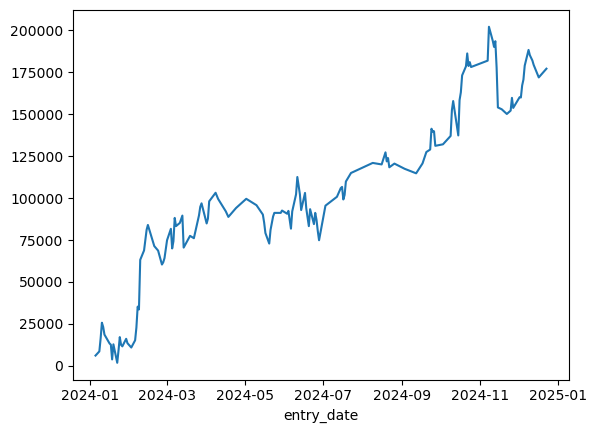

In [90]:
daily_profits
daily_profits.cumsum().plot()

In [28]:
if 'entry_date' in local_trade_log2.columns:

    local_trade_log2.set_index('entry_date' , inplace=True)

    local_trade_log2.sort_index( ascending=True, inplace=True)

if 'exit_date' in local_trade_log2.columns:
    local_trade_log2['exit_date'] = pd.to_datetime(local_trade_log2['exit_date'])

# Calculate the absolute percentage difference between entry and exit prices
local_trade_log2['price_change_pct'] = (local_trade_log2['exit_price'] - local_trade_log2['entry_price']).abs() / local_trade_log2['entry_price']

# Count trades before filtering
trades_before_filtering = len(local_trade_log2)

average_trade_profit = local_trade_log2['profit'].mean()

# First ensure consistent case for Side column

if 'side' in local_trade_log2.columns:
    local_trade_log2.rename(columns={'side': 'Side'}, inplace=True)


local_trade_log2['Side'] = local_trade_log2['Side'].str.lower()

# Calculate profit in bps (handles both buy/long and sell/short)
local_trade_log2['profit_bps'] = np.where(
    local_trade_log2['Side'].isin(['buy', 'long']),
    ((local_trade_log2['exit_price'] - local_trade_log2['entry_price']) / local_trade_log2['entry_price']) * 10000,
    ((local_trade_log2['entry_price'] - local_trade_log2['exit_price']) / local_trade_log2['entry_price']) * 10000)

# open_positions = list(long_position_count.values())
# print(f"Max open long positions are: {np.max(open_positions)}")

# open__short_positions = list(short_position_count.values())
# print(f"Max open shrt positions are: {np.max(open__short_positions)}")

total_trade_count = len(local_trade_log2)
max_entries_per_day = local_trade_log2.groupby(local_trade_log2.index.date).size().max()

# Identify losing trades and percentage

losers = local_trade_log2[local_trade_log2['profit'] < 0]
num_losing_trades = len(losers)
losers_percentage = (num_losing_trades / total_trade_count) * 100 if total_trade_count > 0 else 0

winners = local_trade_log2[local_trade_log2['profit'] > 0]

# # 1. Create a pandas Series from your PnL data
# pnl_series = pd.Series(total_pnl_series)

# # 2. Find the minimum value in the series
# max_unrealized_loss = pnl_series.min()

# print(f"The highest unrealized loss (minimum PnL) was: ${max_unrealized_loss:,.2f}")

# Updated side checks throughout
num_long_trades = len(local_trade_log2[local_trade_log2['Side'].isin(['buy', 'long'])])
num_short_trades = len(local_trade_log2[local_trade_log2['Side'].isin(['sell', 'short'])])
print(f"Number of long trades: {num_long_trades} and short trades: {num_short_trades} out of total trades: {total_trade_count}")

# Updated profit calculations
avg_long_profit_bps = local_trade_log2[local_trade_log2['Side'].isin(['buy', 'long'])]['profit_bps'].mean()
avg_short_profit_bps = local_trade_log2[local_trade_log2['Side'].isin(['sell', 'short'])]['profit_bps'].mean()
print(f"Average long trade profit: {avg_long_profit_bps:.2f} bps and short: {avg_short_profit_bps:.2f} bps")

profit_total_long = local_trade_log2[local_trade_log2['Side'].isin(['buy', 'long'])]['profit'].sum()
profit_total_short = local_trade_log2[local_trade_log2['Side'].isin(['sell', 'short'])]['profit'].sum()
print(f"Net long profit: {profit_total_long:.2f} and short profit: {profit_total_short:.2f}")

# Compute holding period
local_trade_log2['holding_days'] = (local_trade_log2['exit_date'] - local_trade_log2.index).dt.days

# Compute equity curve (EC)
local_trade_log2['EC'] = (position_cap*100) + local_trade_log2['profit'].cumsum()

#============================================

# The index should be the 'exit_date' because that's when the equity changes
equity_at_exit = pd.Series(data=local_trade_log2['EC'].values, index=pd.to_datetime(local_trade_log2['exit_date']))

print(f"Equity at exit is : {equity_at_exit}")

# Print average trade profit
print(f"Average Trade Profit: {average_trade_profit:.2f}")

# Print profit in basis points (bps)
print("Profit (bps) for each trade:")
print(f"Avergae trade profit in bps : {local_trade_log2['profit_bps'].mean()}" )

# Print total trade count
print(f"Total Trade Count: {total_trade_count}")

# Print max entries per day
print(f"Max Entries Per Day: {max_entries_per_day}")

# Print number of losing trades
print(f"Number of Losing Trades: {num_losing_trades}")

print(f"Losing Trades Percentage: {losers_percentage:.2f}%")

# Print holding period
print("Avg Holding Period in (Days) :")
print(local_trade_log2['holding_days'].mean())

# Add: Number of trades with loss greater than 10% (i.e. -1000 bps)
loss_threshold_bps = -1000  # -10%
deep_losers = local_trade_log2[local_trade_log2['profit_bps'] < loss_threshold_bps]
num_deep_losers = len(deep_losers)

print(f"Number of Losing Trades > 10% Loss: {num_deep_losers}")

# Add: Average loss of all losing trades
avg_losing_trade = losers['profit'].mean()
print(f"Average Loss per Losing Trade: {avg_losing_trade:.4f}")

# Calculate average profit percentage (in % terms)
average_profit_percent = local_trade_log2['profit'].mean() / position_cap * 100
print(f"\nAverage Profit Percentage per Trade: {average_profit_percent:.2f}%")

# Calculate Trade Expectancy (in monetary terms)
win_rate = len(winners) / total_trade_count
avg_win = winners['profit'].mean()
avg_loss = losers['profit'].mean()
trade_expectancy = (win_rate * avg_win) - ((1 - win_rate) * abs(avg_loss))
print(f"Trade Expectancy: ${trade_expectancy:.2f} per trade")

# Calculate Risk-Adjusted Metrics
risk_reward_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else float('inf')
print(f"Risk-Reward Ratio: {risk_reward_ratio:.2f}:1")


# Add: Average loss of all losing trades
avg_winning_trade = winners['profit'].mean()
print(f"Average Loss per Losing Trade: {avg_winning_trade:.4f}")


abs_profit_df =  pd.DataFrame()
for symbol , data in absolute_symbol_pnl_series.items():

    tdf = pd.DataFrame(data , columns=['timestamp' , symbol])
    tdf.set_index('timestamp' , inplace=True)

    # Reindex to match df_index, filling missing values with 0
    abs_profit_df[symbol] = tdf.reindex(com_df2.index, fill_value=0)

max_unrealised_drawdown = abs_profit_df.sum(axis=1).min()
print(f"Max unrealised loss ( which is unrealised drawdown on notional) is {max_unrealised_drawdown}")


# Long/Short specific metrics
# Update all calculations to use the new condition
long_trades = local_trade_log2[local_trade_log2['Side'].isin(['buy', 'long'])]
short_trades = local_trade_log2[local_trade_log2['Side'].isin(['sell', 'short'])]

num_long_trades = len(long_trades)
num_short_trades = len(short_trades)

# Profit metrics
avg_long_profit_bps = long_trades['profit_bps'].mean()
avg_short_profit_bps = short_trades['profit_bps'].mean()
profit_total_long = long_trades['profit'].sum()
profit_total_short = short_trades['profit'].sum()

# Win/loss metrics
def calculate_consecutive_wins_losses(trades):
    trades = trades.sort_index()
    consecutive = []
    current_streak = 0
    prev_result = None

    for profit in trades['profit']:
        current_result = 'win' if profit > 0 else 'loss'
        if current_result == prev_result or prev_result is None:
            current_streak += 1
        else:
            consecutive.append((prev_result, current_streak))
            current_streak = 1
        prev_result = current_result

    if current_streak > 0:
        consecutive.append((prev_result, current_streak))

    return pd.DataFrame(consecutive, columns=['type', 'length'])

# Calculate for long and short separately
long_consecutive = calculate_consecutive_wins_losses(long_trades)
short_consecutive = calculate_consecutive_wins_losses(short_trades)

def print_streak_stats(name, df):
    if len(df) > 0:
        max_win_streak = df[df['type'] == 'win']['length'].max()
        max_loss_streak = df[df['type'] == 'loss']['length'].max()
        avg_win_streak = df[df['type'] == 'win']['length'].mean()
        avg_loss_streak = df[df['type'] == 'loss']['length'].mean()
        print(f"\n{name} Streaks:")
        print(f"Max Winning Streak: {max_win_streak}")
        print(f"Max Losing Streak: {max_loss_streak}")
        print(f"Avg Winning Streak: {avg_win_streak:.1f}")
        print(f"Avg Losing Streak: {avg_loss_streak:.1f}")

print_streak_stats("Long", long_consecutive)
print_streak_stats("Short", short_consecutive)

# Winning ratios
long_winners = len(long_trades[long_trades['profit'] > 0])
short_winners = len(short_trades[short_trades['profit'] > 0])

long_win_ratio = long_winners / num_long_trades if num_long_trades > 0 else 0
short_win_ratio = short_winners / num_short_trades if num_short_trades > 0 else 0

print(f"\nLong Trades Win Ratio: {long_win_ratio:.2%}")
print(f"\nShort Trades Win Ratio: {short_win_ratio:.2%}")

# Print all metrics
print("\n==========================================")
print(f"Number of long trades: {num_long_trades}")
print(f"Number of short trades: {num_short_trades}")
print(f"Total trades: {total_trade_count}")

print(f"\nAverage long trade profit: {avg_long_profit_bps:.2f} bps")
print(f"Average short trade profit: {avg_short_profit_bps:.2f} bps")
print(f"Net long profit: {profit_total_long:.2f}")
print(f"Net short profit: {profit_total_short:.2f}")

import matplotlib.pyplot as plt

# Scatter plot of trades
plt.figure(figsize=(12, 6))

# X-axis: trade index (or entry date if you want timeline)
x = range(len(local_trade_log2))

# Y-axis: profit
y = local_trade_log2['profit']

# Scatter: green for winners, red for losers
colors = ['green' if p > 0 else 'red' for p in y]

plt.scatter(x, y, c=colors, alpha=0.7, edgecolors='k')

# Add horizontal line at 0 (break-even)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title("Scatter of Trade Profits")
plt.xlabel("Trade Index")
plt.ylabel("Profit ($)")
plt.show()



from IPython.display import HTML
import matplotlib.pyplot as plt
import base64
from io import BytesIO

# Create equity curve plot
plt.figure(figsize=(10, 6))
local_trade_log2['EC'].plot(title='Equity Curve', grid=True)
plt.ylabel('Portfolio Value')
plt.tight_layout()

# Save plot to temporary buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
plt.close()
plot_data = base64.b64encode(buffer.getvalue()).decode('utf-8')


#=== symbols specific

# 2. Group by the symbol name and calculate the sum of profits for each.
symbol_profits = local_trade_log2.groupby('name')['profit'].sum()

# Display the total profit for each symbol
print("--- Total Profit per Symbol ---")
print(symbol_profits)


# 3. Sort the results to easily find the best and worst.
sorted_symbols = symbol_profits.sort_values(ascending=False)


# 4. Extract the best and worst symbols from the sorted list.
# The best symbol is the first item (index 0).
best_symbol = sorted_symbols.index[0]
best_profit = sorted_symbols.iloc[0]

# The worst symbol is the last item (index -1).
worst_symbol = sorted_symbols.index[-1]
worst_loss = sorted_symbols.iloc[-1]


# 3. Sort the profits in ASCENDING order.
#    This places the symbols with the largest losses at the top.
sorted_by_loss = symbol_profits.sort_values(ascending=True)


# 4. Select the first 10 rows from the sorted list using .head(10).
worst_10_symbols = sorted_by_loss.head(10)


# 5. Print the final result.
print("--- 10 Worst Performing Symbols (by Total Profit) ---")
print(worst_10_symbols)

#======================================



# --- NEW: Calculate and print the additional statistics ---

# Count the number of symbols with negative total profit (losers)
num_loss_making_symbols = (symbol_profits <= 0).sum()

# Count the number of symbols with positive total profit (winners)
num_profit_making_symbols = (symbol_profits > 0).sum()

# Calculate the ratio of losers to winners
# Add a check to prevent division by zero if there are no winners
if num_profit_making_symbols > 0:
    loss_to_profit_ratio = num_loss_making_symbols / num_profit_making_symbols
else:
    loss_to_profit_ratio = float('inf') # Indicate infinite ratio if no winners

# Print the new stats
print("\n--- Symbol Profit/Loss Summary ---")
print(f"Number of Profit-Making Symbols: {num_profit_making_symbols}")
print(f"Number of Loss-Making Symbols:   {num_loss_making_symbols}")
print(f"Ratio of Loss-Makers to Profit-Makers: {loss_to_profit_ratio:.2f}")




def find_max_daily_gmv(trade_log):

    """
    Calculates the maximum and mean Gross Merchandise Value (GMV) on a single day
    from a trade log DataFrame. The mean calculation accounts for all days in the
    period, including non-trading days.

    Args:
        trade_log (pd.DataFrame): DataFrame containing the trade log. 
                                  Index must be a datetime object ('entry_date').
                                  Must contain 'entry_price', 'exit_price', 
                                  'qty', and 'exit_date' columns.

    Returns:
        tuple: A tuple containing the max_gmv_value and the mean_gmv_value.
    """

    # Calculate the total value of each entry and exit transaction
    trade_log['entry_value'] = trade_log['entry_price'] * trade_log['qty']
    trade_log['exit_value'] = trade_log['exit_price'] * trade_log['qty']

    # Group all entry values by their calendar day and sum them up
    daily_entries = trade_log.groupby(trade_log.index.date)['entry_value'].sum()

    # Group all exit values by their calendar day and sum them up
    # CORRECTED: Group exits by 'exit_date', not the index ('entry_date')
    daily_exits = trade_log.groupby(trade_log['exit_date'].dt.date)['exit_value'].sum()

    # Combine the daily entry and exit sums to get the total GMV for each day
    # This series only contains days where a trade occurred.
    daily_gmv = daily_entries.add(daily_exits, fill_value=0)

    # Find the maximum value. This can be done before reindexing for efficiency.
    if daily_gmv.empty:
        return 0, 0
    max_gmv_value = daily_gmv.max()

    # --- MODIFICATION TO ACCOUNT FOR NON-TRADING DAYS ---

    # 1. Determine the full date range of the backtest period.
    #    We use the earliest entry and latest exit to define the period.
    start_date = trade_log.index.min().date()
    end_date = trade_log['exit_date'].max().date()
    all_days_in_period = pd.date_range(start=start_date, end=end_date, freq='D')

    # 2. Reindex the 'daily_gmv' Series to include all days.
    #    This assigns a GMV of 0 to all non-trading days.
    daily_gmv = daily_gmv.reindex(all_days_in_period, fill_value=0)
    
    # --- END OF MODIFICATION ---

    # Now, this calculation correctly finds the mean over the entire period.
    mean_gmv_value = daily_gmv.mean()

    return max_gmv_value, mean_gmv_value


max_gmv , mean_gmv = find_max_daily_gmv(local_trade_log2)

print(f"Average daily GMV is {mean_gmv}")
print(f"Max daily gmv is {max_gmv}")


print(f"Return on average GMV is {local_trade_log2['profit'].sum()/mean_gmv}")
print(f"Return on average GMV is {local_trade_log2['profit'].sum()/max_gmv}")



# Create HTML report
html_report = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Backtest Performance Report</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; }}
        h1 {{ color: #2c3e50; border-bottom: 2px solid #3498db; }}
        h2 {{ color: #2980b9; }}
        .metric-container {{ display: flex; flex-wrap: wrap; gap: 20px; }}
        .metric-card {{
            background: #f8f9fa;
            border: 1px solid #dee2e6;
            border-radius: 5px;
            padding: 15px;
            flex: 1 1 300px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }}
        .metric-title {{ font-weight: bold; color: #2c3e50; }}
        .metric-value {{ font-size: 1.2em; color: #27ae60; }}
        .negative {{ color: #e74c3c; }}
        .plot-container {{ margin: 30px 0; text-align: center; }}
        table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
        th, td {{ padding: 10px; text-align: left; border-bottom: 1px solid #ddd; }}
        th {{ background-color: #3498db; color: white; }}
        tr:nth-child(even) {{ background-color: #f2f2f2; }}
    </style>
</head>
<body>
    <h1>Strategy Backtest Performance Report</h1>

    <div class="plot-container">
        <h2>Equity Curve</h2>
        <img src="data:image/png;base64,{plot_data}" alt="Equity Curve">
    </div>

    <h2>Key Performance Metrics</h2>
    <div class="metric-container">
        <div class="metric-card">
            <div class="metric-title">Total Trades</div>
            <div class="metric-value">{total_trade_count:,}</div>
        </div>
        <div class="metric-card">
            <div class="metric-title">Win Rate</div>
            <div class="metric-value">{100 - losers_percentage:.1f}%</div>
        </div>
        <div class="metric-card">
            <div class="metric-title">Average Trade Profit</div>
            <div class="metric-value">${average_trade_profit:,.2f}</div>
        </div>
        <div class="metric-card">
            <div class="metric-title">Trade Expectancy</div>
            <div class="metric-value">${trade_expectancy:,.2f}</div>
        </div>
        <div class="metric-card">
            <div class="metric-title">Risk-Reward Ratio</div>
            <div class="metric-value">{risk_reward_ratio:.2f}:1</div>
        </div>
        <div class="metric-card">
            <div class="metric-title">Max Drawdown</div>
            <div class="metric-value negative">${max_unrealised_drawdown:,.2f}</div>
        </div>
    </div>

    <h2>Long/Short Breakdown</h2>
    <table>
        <tr>
            <th>Metric</th>
            <th>Long Trades</th>
            <th>Short Trades</th>
        </tr>
        <tr>
            <td>Count</td>
            <td>{num_long_trades:,}</td>
            <td>{num_short_trades:,}</td>
        </tr>
        <tr>
            <td>Win Rate</td>
            <td>{long_win_ratio:.1%}</td>
            <td>{short_win_ratio:.1%}</td>
        </tr>
        <tr>
            <td>Avg Profit (bps)</td>
            <td>{avg_long_profit_bps:.1f}</td>
            <td>{avg_short_profit_bps:.1f}</td>
        </tr>
        <tr>
            <td>Total Profit</td>
            <td>${profit_total_long:,.2f}</td>
            <td>${profit_total_short:,.2f}</td>
        </tr>
        <tr>
            <td>Max Win Streak</td>
            <td>{long_consecutive[long_consecutive['type']=='win']['length'].max() if len(long_consecutive) > 0 else 0}</td>
            <td>{short_consecutive[short_consecutive['type']=='win']['length'].max() if len(short_consecutive) > 0 else 0}</td>
        </tr>
        <tr>
            <td>Max Loss Streak</td>
            <td>{long_consecutive[long_consecutive['type']=='loss']['length'].max() if len(long_consecutive) > 0 else 0}</td>
            <td>{short_consecutive[short_consecutive['type']=='loss']['length'].max() if len(short_consecutive) > 0 else 0}</td>
        </tr>
    </table>

    <h2>Position Sizing</h2>
    <div class="metric-container">
        
        <div class="metric-card">
            <div class="metric-title">Max Entries Per Day</div>
            <div class="metric-value">{max_entries_per_day}</div>
        </div>
    </div>

    <h2>Trade Duration</h2>
    <div class="metric-container">
        <div class="metric-card">
            <div class="metric-title">Avg Holding Days</div>
            <div class="metric-value">{local_trade_log2['holding_days'].mean():.1f}</div>
        </div>
    </div>
</body>
</html>
"""

# Display the report
HTML(html_report)

# To save the report to a file
with open('Nasdaq_Vol_stocks.html', 'w') as f:
    f.write(html_report)

local_trade_log2.to_csv("Nasdaq_TL.csv", index=True)

# Convert total_pnl_series dict (timestamp → pnl) into DataFrame
mtm_equity_df = pd.DataFrame(list(total_pnl_series.items()), columns=["timestamp", "MTM_PnL"])

# Sort by timestamp (important to keep the curve ordered)
mtm_equity_df.sort_values("timestamp", inplace=True)

# Add equity column: starting capital + cumulative PnL
mtm_equity_df["Equity"] = intial_capital + mtm_equity_df["MTM_PnL"].cumsum()

# Set timestamp as index for convenience
mtm_equity_df.set_index("timestamp", inplace=True)

# Define full path
mtm_equity_file = os.path.join(trades_strategy_folder, "MTM_equity.csv")

# Save to CSV
mtm_equity_df.to_csv(mtm_equity_file)

print(f"✅ MTM equity curve saved at: {mtm_equity_file}")


# for symbol, data in absolute_symbol_pnl_series.items():
#     if not data:
#         print(f"No data for {symbol}, skipping.")
#         continue
#     try:
#         tdf = pd.DataFrame(data, columns=['timestamp', 'pnl_absolute'])
#         tdf.set_index('timestamp', inplace=True)
#         file_path = os.path.join(df_folder, f"{symbol}_pnl.csv")
#         tdf.to_csv(file_path)
#         print(f"Successfully saved {file_path}")
#     except Exception as e:
#         print(f"Error processing {symbol}: {e}")


import quantstats as qs
qs.extend_pandas()

qs.reports.basic(local_trade_log2['EC'])

# --- 2. Plotting the 'EC' column ---
plt.figure(figsize=(12, 6)) # Optional: Adjust the figure size

local_trade_log2['EC'].plot(grid=True) # The main plotting command

# --- 3. Add labels and a title for clarity ---
plt.title('EC Over Time')
plt.xlabel('Date')
plt.ylabel('EC Value')

# --- 4. Display the plot ---
plt.show()


Number of long trades: 0 and short trades: 136 out of total trades: 136
Average long trade profit: nan bps and short: 901.26 bps
Net long profit: 0.00 and short profit: 1207000.00
Equity at exit is : exit_date
2024-01-05 12:08:00    9958000.00000000
2024-01-09 13:06:00   10034000.00000000
2024-01-10 10:33:00    9995000.00000000
2024-01-10 14:15:00   10052000.00000000
2024-01-12 11:39:00   10014000.00000000
                             ...       
2024-11-22 10:10:00   11199000.00000000
2024-12-02 14:38:00   11223000.00000000
2024-12-05 12:06:00   11184000.00000000
2024-12-06 13:08:00   11142000.00000000
2024-12-09 14:17:00   11207000.00000000
Length: 136, dtype: float64
Average Trade Profit: 8875.00
Profit (bps) for each trade:
Avergae trade profit in bps : 901.2552975795084
Total Trade Count: 136
Max Entries Per Day: 5
Number of Losing Trades: 71
Losing Trades Percentage: 52.21%
Avg Holding Period in (Days) :
0.0
Number of Losing Trades > 10% Loss: 70
Average Loss per Losing Trade: -41

NameError: name 'absolute_symbol_pnl_series' is not defined